## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 217)
Hypercube shape: (512, 217, 204)


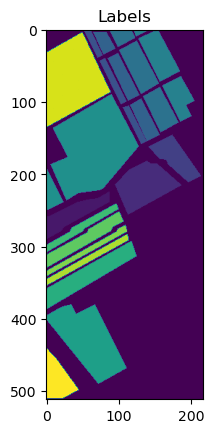

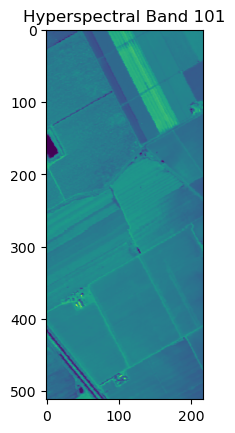

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Salinas_gt.mat'
data_files = 'Salinas_corrected.mat'
label_files = 'salinas_gt'
hypercube_files = 'salinas_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 54129
Extracted windows shape: (54129, 5, 5, 204)
Corresponding labels shape: (54129,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 2009 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 3726 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 1976 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 1394 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 2678 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 3959 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 3579 samples
Shuffled class indices fo


 -- Test set created with: 
	53729 samples
	shape (53729, 5, 5, 204) --




All datasets saved to the 'indices' folder.
(320, 5, 5, 204)
(80, 5, 5, 204)
(53729, 5, 5, 204)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 320
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (43303, 5, 5, 204)
Validation data shape: (10826, 5, 5, 204)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

204


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/677], Loss: 0.1593, PSNR: 7.1235


	 Training Batch [200/677], Loss: 0.0882, PSNR: 9.6416


	 Training Batch [400/677], Loss: 0.0461, PSNR: 12.4570


	 Training Batch [600/677], Loss: 0.0242, PSNR: 15.2114


Epoch [1/50] Training Loss: 0.0669, PSNR: 11.6395
	[Val]   Batch [1/170] Loss: 0.0211, PSNR: 15.8404
	[Val]   Batch [10/170] Loss: 0.0207, PSNR: 16.0197
	[Val]   Batch [20/170] Loss: 0.0209, PSNR: 15.9139
	[Val]   Batch [30/170] Loss: 0.0216, PSNR: 15.7057
	[Val]   Batch [40/170] Loss: 0.0217, PSNR: 15.7773


	[Val]   Batch [50/170] Loss: 0.0205, PSNR: 15.9913
	[Val]   Batch [60/170] Loss: 0.0214, PSNR: 15.8675
	[Val]   Batch [70/170] Loss: 0.0211, PSNR: 15.9382
	[Val]   Batch [80/170] Loss: 0.0213, PSNR: 15.7819
	[Val]   Batch [90/170] Loss: 0.0207, PSNR: 16.0006


	[Val]   Batch [100/170] Loss: 0.0208, PSNR: 15.9281
	[Val]   Batch [110/170] Loss: 0.0208, PSNR: 15.9193
	[Val]   Batch [120/170] Loss: 0.0197, PSNR: 14.2168
	[Val]   Batch [130/170] Loss: 0.0207, PSNR: 16.0164
	[Val]   Batch [140/170] Loss: 0.0203, PSNR: 16.0686


	[Val]   Batch [150/170] Loss: 0.0217, PSNR: 15.8213
	[Val]   Batch [160/170] Loss: 0.0214, PSNR: 15.8444
	[Val]   Batch [170/170] Loss: 0.0220, PSNR: 15.1680
Epoch [1/50] Validation Loss: 0.0210, PSNR: 15.8389

LOG: Epoch [2/50]
	 Training Batch [1/677], Loss: 0.0199, PSNR: 16.1216


	 Training Batch [200/677], Loss: 0.0153, PSNR: 17.2619


	 Training Batch [400/677], Loss: 0.0104, PSNR: 19.0019


	 Training Batch [600/677], Loss: 0.0087, PSNR: 19.7625


Epoch [2/50] Training Loss: 0.0127, PSNR: 18.2134
	[Val]   Batch [1/170] Loss: 0.0084, PSNR: 19.8345
	[Val]   Batch [10/170] Loss: 0.0079, PSNR: 20.1836
	[Val]   Batch [20/170] Loss: 0.0081, PSNR: 20.0428
	[Val]   Batch [30/170] Loss: 0.0087, PSNR: 19.6335
	[Val]   Batch [40/170] Loss: 0.0089, PSNR: 19.6283


	[Val]   Batch [50/170] Loss: 0.0077, PSNR: 20.2223
	[Val]   Batch [60/170] Loss: 0.0087, PSNR: 19.7748
	[Val]   Batch [70/170] Loss: 0.0085, PSNR: 19.8862
	[Val]   Batch [80/170] Loss: 0.0086, PSNR: 19.7318
	[Val]   Batch [90/170] Loss: 0.0082, PSNR: 20.0455


	[Val]   Batch [100/170] Loss: 0.0082, PSNR: 19.9524
	[Val]   Batch [110/170] Loss: 0.0081, PSNR: 20.0216
	[Val]   Batch [120/170] Loss: 0.0070, PSNR: 18.7026
	[Val]   Batch [130/170] Loss: 0.0082, PSNR: 20.0371
	[Val]   Batch [140/170] Loss: 0.0076, PSNR: 20.3490


	[Val]   Batch [150/170] Loss: 0.0090, PSNR: 19.6625
	[Val]   Batch [160/170] Loss: 0.0087, PSNR: 19.7683
	[Val]   Batch [170/170] Loss: 0.0090, PSNR: 19.0387
Epoch [2/50] Validation Loss: 0.0083, PSNR: 19.8775

LOG: Epoch [3/50]
	 Training Batch [1/677], Loss: 0.0076, PSNR: 19.8504


	 Training Batch [200/677], Loss: 0.0067, PSNR: 20.5763


	 Training Batch [400/677], Loss: 0.0056, PSNR: 21.6238


	 Training Batch [600/677], Loss: 0.0057, PSNR: 21.6227


Epoch [3/50] Training Loss: 0.0064, PSNR: 21.1067
	[Val]   Batch [1/170] Loss: 0.0047, PSNR: 22.4032
	[Val]   Batch [10/170] Loss: 0.0044, PSNR: 22.7203
	[Val]   Batch [20/170] Loss: 0.0045, PSNR: 22.6021
	[Val]   Batch [30/170] Loss: 0.0049, PSNR: 22.1663
	[Val]   Batch [40/170] Loss: 0.0050, PSNR: 22.1828


	[Val]   Batch [50/170] Loss: 0.0044, PSNR: 22.6971
	[Val]   Batch [60/170] Loss: 0.0049, PSNR: 22.3178
	[Val]   Batch [70/170] Loss: 0.0047, PSNR: 22.4700
	[Val]   Batch [80/170] Loss: 0.0047, PSNR: 22.3103
	[Val]   Batch [90/170] Loss: 0.0046, PSNR: 22.5695


	[Val]   Batch [100/170] Loss: 0.0046, PSNR: 22.4426
	[Val]   Batch [110/170] Loss: 0.0045, PSNR: 22.5563
	[Val]   Batch [120/170] Loss: 0.0040, PSNR: 21.1586
	[Val]   Batch [130/170] Loss: 0.0046, PSNR: 22.5494
	[Val]   Batch [140/170] Loss: 0.0042, PSNR: 22.9008


	[Val]   Batch [150/170] Loss: 0.0050, PSNR: 22.2282
	[Val]   Batch [160/170] Loss: 0.0048, PSNR: 22.3404
	[Val]   Batch [170/170] Loss: 0.0049, PSNR: 21.6795
Epoch [3/50] Validation Loss: 0.0046, PSNR: 22.4291

LOG: Epoch [4/50]
	 Training Batch [1/677], Loss: 0.0044, PSNR: 22.6281


	 Training Batch [200/677], Loss: 0.0039, PSNR: 23.2958


	 Training Batch [400/677], Loss: 0.0033, PSNR: 23.9310


	 Training Batch [600/677], Loss: 0.0030, PSNR: 24.3158


Epoch [4/50] Training Loss: 0.0036, PSNR: 23.5320
	[Val]   Batch [1/170] Loss: 0.0027, PSNR: 24.7428
	[Val]   Batch [10/170] Loss: 0.0026, PSNR: 25.0181
	[Val]   Batch [20/170] Loss: 0.0027, PSNR: 24.8611
	[Val]   Batch [30/170] Loss: 0.0029, PSNR: 24.4111
	[Val]   Batch [40/170] Loss: 0.0028, PSNR: 24.6112


	[Val]   Batch [50/170] Loss: 0.0026, PSNR: 24.9011
	[Val]   Batch [60/170] Loss: 0.0028, PSNR: 24.6370
	[Val]   Batch [70/170] Loss: 0.0027, PSNR: 24.8809
	[Val]   Batch [80/170] Loss: 0.0028, PSNR: 24.6726
	[Val]   Batch [90/170] Loss: 0.0027, PSNR: 24.8770


	[Val]   Batch [100/170] Loss: 0.0028, PSNR: 24.6218
	[Val]   Batch [110/170] Loss: 0.0026, PSNR: 24.9124
	[Val]   Batch [120/170] Loss: 0.0025, PSNR: 23.2051
	[Val]   Batch [130/170] Loss: 0.0028, PSNR: 24.7164
	[Val]   Batch [140/170] Loss: 0.0025, PSNR: 25.1801


	[Val]   Batch [150/170] Loss: 0.0029, PSNR: 24.5673
	[Val]   Batch [160/170] Loss: 0.0028, PSNR: 24.7074
	[Val]   Batch [170/170] Loss: 0.0029, PSNR: 23.9925
Epoch [4/50] Validation Loss: 0.0027, PSNR: 24.7168

LOG: Epoch [5/50]
	 Training Batch [1/677], Loss: 0.0030, PSNR: 24.3555


	 Training Batch [200/677], Loss: 0.0024, PSNR: 25.2161


	 Training Batch [400/677], Loss: 0.0022, PSNR: 25.6766


	 Training Batch [600/677], Loss: 0.0022, PSNR: 25.7445


Epoch [5/50] Training Loss: 0.0024, PSNR: 25.3145
	[Val]   Batch [1/170] Loss: 0.0019, PSNR: 26.3321
	[Val]   Batch [10/170] Loss: 0.0018, PSNR: 26.6020
	[Val]   Batch [20/170] Loss: 0.0019, PSNR: 26.4000
	[Val]   Batch [30/170] Loss: 0.0021, PSNR: 25.9076
	[Val]   Batch [40/170] Loss: 0.0019, PSNR: 26.2732


	[Val]   Batch [50/170] Loss: 0.0019, PSNR: 26.3955
	[Val]   Batch [60/170] Loss: 0.0020, PSNR: 26.1927
	[Val]   Batch [70/170] Loss: 0.0018, PSNR: 26.5384
	[Val]   Batch [80/170] Loss: 0.0019, PSNR: 26.2639
	[Val]   Batch [90/170] Loss: 0.0019, PSNR: 26.4637


	[Val]   Batch [100/170] Loss: 0.0020, PSNR: 26.1089
	[Val]   Batch [110/170] Loss: 0.0018, PSNR: 26.5887
	[Val]   Batch [120/170] Loss: 0.0018, PSNR: 24.6448
	[Val]   Batch [130/170] Loss: 0.0020, PSNR: 26.1856
	[Val]   Batch [140/170] Loss: 0.0017, PSNR: 26.7566


	[Val]   Batch [150/170] Loss: 0.0020, PSNR: 26.1353
	[Val]   Batch [160/170] Loss: 0.0019, PSNR: 26.3069
	[Val]   Batch [170/170] Loss: 0.0020, PSNR: 25.5677
Epoch [5/50] Validation Loss: 0.0019, PSNR: 26.2739

LOG: Epoch [6/50]
	 Training Batch [1/677], Loss: 0.0018, PSNR: 26.5075


	 Training Batch [200/677], Loss: 0.0017, PSNR: 26.8695


	 Training Batch [400/677], Loss: 0.0019, PSNR: 26.4179


	 Training Batch [600/677], Loss: 0.0016, PSNR: 27.0210


Epoch [6/50] Training Loss: 0.0018, PSNR: 26.5802
	[Val]   Batch [1/170] Loss: 0.0014, PSNR: 27.6157
	[Val]   Batch [10/170] Loss: 0.0013, PSNR: 27.8820
	[Val]   Batch [20/170] Loss: 0.0014, PSNR: 27.6224
	[Val]   Batch [30/170] Loss: 0.0016, PSNR: 27.1122
	[Val]   Batch [40/170] Loss: 0.0014, PSNR: 27.6045


	[Val]   Batch [50/170] Loss: 0.0014, PSNR: 27.6138
	[Val]   Batch [60/170] Loss: 0.0015, PSNR: 27.4369
	[Val]   Batch [70/170] Loss: 0.0014, PSNR: 27.8451
	[Val]   Batch [80/170] Loss: 0.0014, PSNR: 27.5443
	[Val]   Batch [90/170] Loss: 0.0014, PSNR: 27.7399


	[Val]   Batch [100/170] Loss: 0.0015, PSNR: 27.2717
	[Val]   Batch [110/170] Loss: 0.0013, PSNR: 27.9502
	[Val]   Batch [120/170] Loss: 0.0014, PSNR: 25.7984
	[Val]   Batch [130/170] Loss: 0.0015, PSNR: 27.3537
	[Val]   Batch [140/170] Loss: 0.0013, PSNR: 28.0408


	[Val]   Batch [150/170] Loss: 0.0015, PSNR: 27.3679
	[Val]   Batch [160/170] Loss: 0.0014, PSNR: 27.5724
	[Val]   Batch [170/170] Loss: 0.0015, PSNR: 26.8542
Epoch [6/50] Validation Loss: 0.0014, PSNR: 27.5240

LOG: Epoch [7/50]
	 Training Batch [1/677], Loss: 0.0014, PSNR: 27.7127


	 Training Batch [200/677], Loss: 0.0015, PSNR: 27.3203


	 Training Batch [400/677], Loss: 0.0013, PSNR: 28.1508


	 Training Batch [600/677], Loss: 0.0013, PSNR: 28.0366


Epoch [7/50] Training Loss: 0.0014, PSNR: 27.5577
	[Val]   Batch [1/170] Loss: 0.0011, PSNR: 28.6533
	[Val]   Batch [10/170] Loss: 0.0011, PSNR: 28.8938
	[Val]   Batch [20/170] Loss: 0.0011, PSNR: 28.5965
	[Val]   Batch [30/170] Loss: 0.0013, PSNR: 28.0653
	[Val]   Batch [40/170] Loss: 0.0011, PSNR: 28.6860


	[Val]   Batch [50/170] Loss: 0.0011, PSNR: 28.5680
	[Val]   Batch [60/170] Loss: 0.0012, PSNR: 28.4284
	[Val]   Batch [70/170] Loss: 0.0011, PSNR: 28.9305
	[Val]   Batch [80/170] Loss: 0.0011, PSNR: 28.5589


	[Val]   Batch [90/170] Loss: 0.0011, PSNR: 28.7923
	[Val]   Batch [100/170] Loss: 0.0012, PSNR: 28.2205
	[Val]   Batch [110/170] Loss: 0.0010, PSNR: 29.0470
	[Val]   Batch [120/170] Loss: 0.0011, PSNR: 26.7277
	[Val]   Batch [130/170] Loss: 0.0012, PSNR: 28.3001


	[Val]   Batch [140/170] Loss: 0.0010, PSNR: 29.0776
	[Val]   Batch [150/170] Loss: 0.0012, PSNR: 28.3406
	[Val]   Batch [160/170] Loss: 0.0011, PSNR: 28.5896
	[Val]   Batch [170/170] Loss: 0.0012, PSNR: 27.8633
Epoch [7/50] Validation Loss: 0.0011, PSNR: 28.5209

LOG: Epoch [8/50]
	 Training Batch [1/677], Loss: 0.0013, PSNR: 27.7726


	 Training Batch [200/677], Loss: 0.0013, PSNR: 28.0742


	 Training Batch [400/677], Loss: 0.0011, PSNR: 28.6225


	 Training Batch [600/677], Loss: 0.0011, PSNR: 28.5518


Epoch [8/50] Training Loss: 0.0012, PSNR: 28.3501
	[Val]   Batch [1/170] Loss: 0.0009, PSNR: 29.6294
	[Val]   Batch [10/170] Loss: 0.0009, PSNR: 29.8653
	[Val]   Batch [20/170] Loss: 0.0009, PSNR: 29.5419
	[Val]   Batch [30/170] Loss: 0.0010, PSNR: 28.9870
	[Val]   Batch [40/170] Loss: 0.0009, PSNR: 29.6896


	[Val]   Batch [50/170] Loss: 0.0009, PSNR: 29.4534
	[Val]   Batch [60/170] Loss: 0.0010, PSNR: 29.3789
	[Val]   Batch [70/170] Loss: 0.0008, PSNR: 29.9496
	[Val]   Batch [80/170] Loss: 0.0009, PSNR: 29.5608
	[Val]   Batch [90/170] Loss: 0.0009, PSNR: 29.7806


	[Val]   Batch [100/170] Loss: 0.0010, PSNR: 29.1648
	[Val]   Batch [110/170] Loss: 0.0008, PSNR: 30.0873
	[Val]   Batch [120/170] Loss: 0.0009, PSNR: 27.6008
	[Val]   Batch [130/170] Loss: 0.0010, PSNR: 29.2396
	[Val]   Batch [140/170] Loss: 0.0008, PSNR: 30.0585


	[Val]   Batch [150/170] Loss: 0.0010, PSNR: 29.2923
	[Val]   Batch [160/170] Loss: 0.0009, PSNR: 29.5565
	[Val]   Batch [170/170] Loss: 0.0009, PSNR: 28.8782
Epoch [8/50] Validation Loss: 0.0009, PSNR: 29.4821

LOG: Epoch [9/50]
	 Training Batch [1/677], Loss: 0.0010, PSNR: 29.1691


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.6273


	 Training Batch [400/677], Loss: 0.0008, PSNR: 29.8460


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.4516


Epoch [9/50] Training Loss: 0.0010, PSNR: 29.0490
	[Val]   Batch [1/170] Loss: 0.0007, PSNR: 30.3684
	[Val]   Batch [10/170] Loss: 0.0007, PSNR: 30.6392
	[Val]   Batch [20/170] Loss: 0.0008, PSNR: 30.2979
	[Val]   Batch [30/170] Loss: 0.0009, PSNR: 29.7457
	[Val]   Batch [40/170] Loss: 0.0007, PSNR: 30.4431
	[Val]   Batch [50/170] Loss: 0.0008, PSNR: 30.1712


	[Val]   Batch [60/170] Loss: 0.0008, PSNR: 30.1335
	[Val]   Batch [70/170] Loss: 0.0007, PSNR: 30.7023
	[Val]   Batch [80/170] Loss: 0.0007, PSNR: 30.3480
	[Val]   Batch [90/170] Loss: 0.0007, PSNR: 30.5802


	[Val]   Batch [100/170] Loss: 0.0008, PSNR: 29.9511
	[Val]   Batch [110/170] Loss: 0.0007, PSNR: 30.8648
	[Val]   Batch [120/170] Loss: 0.0008, PSNR: 28.3379
	[Val]   Batch [130/170] Loss: 0.0008, PSNR: 30.0246
	[Val]   Batch [140/170] Loss: 0.0007, PSNR: 30.8343


	[Val]   Batch [150/170] Loss: 0.0008, PSNR: 30.0476
	[Val]   Batch [160/170] Loss: 0.0008, PSNR: 30.3005
	[Val]   Batch [170/170] Loss: 0.0008, PSNR: 29.6840
Epoch [9/50] Validation Loss: 0.0008, PSNR: 30.2350

LOG: Epoch [10/50]
	 Training Batch [1/677], Loss: 0.0012, PSNR: 28.3461


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.4835


	 Training Batch [400/677], Loss: 0.0009, PSNR: 29.5915


	 Training Batch [600/677], Loss: 0.0008, PSNR: 29.9366


Epoch [10/50] Training Loss: 0.0009, PSNR: 29.7160
	[Val]   Batch [1/170] Loss: 0.0006, PSNR: 31.0726
	[Val]   Batch [10/170] Loss: 0.0006, PSNR: 31.3815
	[Val]   Batch [20/170] Loss: 0.0006, PSNR: 31.0087
	[Val]   Batch [30/170] Loss: 0.0007, PSNR: 30.4863
	[Val]   Batch [40/170] Loss: 0.0006, PSNR: 31.1652


	[Val]   Batch [50/170] Loss: 0.0007, PSNR: 30.8505
	[Val]   Batch [60/170] Loss: 0.0007, PSNR: 30.8605
	[Val]   Batch [70/170] Loss: 0.0006, PSNR: 31.3923
	[Val]   Batch [80/170] Loss: 0.0006, PSNR: 31.0921
	[Val]   Batch [90/170] Loss: 0.0006, PSNR: 31.3605


	[Val]   Batch [100/170] Loss: 0.0007, PSNR: 30.7265
	[Val]   Batch [110/170] Loss: 0.0006, PSNR: 31.6136
	[Val]   Batch [120/170] Loss: 0.0006, PSNR: 29.0912
	[Val]   Batch [130/170] Loss: 0.0007, PSNR: 30.7895
	[Val]   Batch [140/170] Loss: 0.0006, PSNR: 31.5760


	[Val]   Batch [150/170] Loss: 0.0007, PSNR: 30.7589
	[Val]   Batch [160/170] Loss: 0.0007, PSNR: 30.9717
	[Val]   Batch [170/170] Loss: 0.0006, PSNR: 30.4975
Epoch [10/50] Validation Loss: 0.0007, PSNR: 30.9608

LOG: Epoch [11/50]
	 Training Batch [1/677], Loss: 0.0008, PSNR: 30.1371


	 Training Batch [200/677], Loss: 0.0009, PSNR: 29.7991


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.9338


	 Training Batch [600/677], Loss: 0.0009, PSNR: 29.5304


Epoch [11/50] Training Loss: 0.0008, PSNR: 30.3216
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 31.8969
	[Val]   Batch [10/170] Loss: 0.0005, PSNR: 32.2117
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 31.7991
	[Val]   Batch [30/170] Loss: 0.0006, PSNR: 31.3811
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 31.9979


	[Val]   Batch [50/170] Loss: 0.0006, PSNR: 31.5960
	[Val]   Batch [60/170] Loss: 0.0006, PSNR: 31.7453
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.1765
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.0008
	[Val]   Batch [90/170] Loss: 0.0005, PSNR: 32.2598


	[Val]   Batch [100/170] Loss: 0.0006, PSNR: 31.6579
	[Val]   Batch [110/170] Loss: 0.0005, PSNR: 32.4735
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 29.8428
	[Val]   Batch [130/170] Loss: 0.0006, PSNR: 31.7212
	[Val]   Batch [140/170] Loss: 0.0005, PSNR: 32.3990


	[Val]   Batch [150/170] Loss: 0.0006, PSNR: 31.7082
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 31.7706
	[Val]   Batch [170/170] Loss: 0.0005, PSNR: 31.4983
Epoch [11/50] Validation Loss: 0.0005, PSNR: 31.8143

LOG: Epoch [12/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.7326


	 Training Batch [200/677], Loss: 0.0007, PSNR: 30.8472


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.8368


	 Training Batch [600/677], Loss: 0.0007, PSNR: 30.5774


Epoch [12/50] Training Loss: 0.0007, PSNR: 30.8216
	[Val]   Batch [1/170] Loss: 0.0005, PSNR: 32.3540
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 32.7041
	[Val]   Batch [20/170] Loss: 0.0005, PSNR: 32.2437
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 31.9236
	[Val]   Batch [40/170] Loss: 0.0005, PSNR: 32.4716


	[Val]   Batch [50/170] Loss: 0.0005, PSNR: 32.0476
	[Val]   Batch [60/170] Loss: 0.0005, PSNR: 32.2598
	[Val]   Batch [70/170] Loss: 0.0005, PSNR: 32.5998
	[Val]   Batch [80/170] Loss: 0.0005, PSNR: 32.4958
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 32.7971


	[Val]   Batch [100/170] Loss: 0.0005, PSNR: 32.2205
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 32.9126
	[Val]   Batch [120/170] Loss: 0.0005, PSNR: 30.3216
	[Val]   Batch [130/170] Loss: 0.0005, PSNR: 32.3027
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 32.8453


	[Val]   Batch [150/170] Loss: 0.0005, PSNR: 32.2508
	[Val]   Batch [160/170] Loss: 0.0005, PSNR: 32.2124
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.1059
Epoch [12/50] Validation Loss: 0.0005, PSNR: 32.2942

LOG: Epoch [13/50]
	 Training Batch [1/677], Loss: 0.0007, PSNR: 30.4739


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.7669


	 Training Batch [400/677], Loss: 0.0007, PSNR: 30.1101


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.5847


Epoch [13/50] Training Loss: 0.0006, PSNR: 31.3004
	[Val]   Batch [1/170] Loss: 0.0004, PSNR: 32.8770
	[Val]   Batch [10/170] Loss: 0.0004, PSNR: 33.2469
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 32.6916
	[Val]   Batch [30/170] Loss: 0.0005, PSNR: 32.4655
	[Val]   Batch [40/170] Loss: 0.0004, PSNR: 32.9438


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 32.6267
	[Val]   Batch [60/170] Loss: 0.0004, PSNR: 32.7648
	[Val]   Batch [70/170] Loss: 0.0004, PSNR: 33.0119
	[Val]   Batch [80/170] Loss: 0.0004, PSNR: 32.9992
	[Val]   Batch [90/170] Loss: 0.0004, PSNR: 33.3739


	[Val]   Batch [100/170] Loss: 0.0004, PSNR: 32.7855
	[Val]   Batch [110/170] Loss: 0.0004, PSNR: 33.3918
	[Val]   Batch [120/170] Loss: 0.0004, PSNR: 30.9047
	[Val]   Batch [130/170] Loss: 0.0004, PSNR: 32.8357
	[Val]   Batch [140/170] Loss: 0.0004, PSNR: 33.3882


	[Val]   Batch [150/170] Loss: 0.0004, PSNR: 32.7615
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 32.6324
	[Val]   Batch [170/170] Loss: 0.0004, PSNR: 32.5805
Epoch [13/50] Validation Loss: 0.0004, PSNR: 32.7943

LOG: Epoch [14/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.4260


	 Training Batch [200/677], Loss: 0.0005, PSNR: 31.7537


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.7763


	 Training Batch [600/677], Loss: 0.0006, PSNR: 31.5686


Epoch [14/50] Training Loss: 0.0005, PSNR: 31.7394
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.7819
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.1522
	[Val]   Batch [20/170] Loss: 0.0004, PSNR: 33.5847
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.4363
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 33.8974


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.3765
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 33.7481
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.9287
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.0116
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.3313


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.7483
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.3634
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.7206
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 33.8150
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.3007


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 33.7786
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.5409
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.8277
Epoch [14/50] Validation Loss: 0.0003, PSNR: 33.7433

LOG: Epoch [15/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.0794


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.4818


	 Training Batch [400/677], Loss: 0.0004, PSNR: 32.7601


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.0053


Epoch [15/50] Training Loss: 0.0005, PSNR: 32.0534
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 33.9405
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 34.2904
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 33.6938
	[Val]   Batch [30/170] Loss: 0.0004, PSNR: 33.5381
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 33.9690


	[Val]   Batch [50/170] Loss: 0.0004, PSNR: 33.5628
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 33.8637
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 33.9725
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.0706
	[Val]   Batch [90/170] Loss: 0.0003, PSNR: 34.4356


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 33.8507
	[Val]   Batch [110/170] Loss: 0.0003, PSNR: 34.4383
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 31.9637
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 33.9586
	[Val]   Batch [140/170] Loss: 0.0003, PSNR: 34.4182


	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 33.8412
	[Val]   Batch [160/170] Loss: 0.0004, PSNR: 33.6094
	[Val]   Batch [170/170] Loss: 0.0003, PSNR: 33.9306
Epoch [15/50] Validation Loss: 0.0003, PSNR: 33.8482

LOG: Epoch [16/50]
	 Training Batch [1/677], Loss: 0.0006, PSNR: 31.3272


	 Training Batch [200/677], Loss: 0.0006, PSNR: 31.0334


	 Training Batch [400/677], Loss: 0.0006, PSNR: 31.0842


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.3101


Epoch [16/50] Training Loss: 0.0005, PSNR: 32.3615
	[Val]   Batch [1/170] Loss: 0.0003, PSNR: 34.6640
	[Val]   Batch [10/170] Loss: 0.0003, PSNR: 35.0819
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.4017
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.3968
	[Val]   Batch [40/170] Loss: 0.0003, PSNR: 34.7712


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.2116
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 34.7193
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 34.7257
	[Val]   Batch [80/170] Loss: 0.0003, PSNR: 34.9586
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.3052


	[Val]   Batch [100/170] Loss: 0.0003, PSNR: 34.7663
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.2549
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.5855
	[Val]   Batch [130/170] Loss: 0.0003, PSNR: 34.8267


	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.1924
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 34.7749
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.3513
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 34.8842
Epoch [16/50] Validation Loss: 0.0003, PSNR: 34.6461

LOG: Epoch [17/50]
	 Training Batch [1/677], Loss: 0.0005, PSNR: 32.5539


	 Training Batch [200/677], Loss: 0.0006, PSNR: 30.9409


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.1684


	 Training Batch [600/677], Loss: 0.0004, PSNR: 33.4728


Epoch [17/50] Training Loss: 0.0004, PSNR: 32.6390
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.1303
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.4788
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.7859
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 34.8424
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.1762


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.5586
	[Val]   Batch [60/170] Loss: 0.0003, PSNR: 35.1674
	[Val]   Batch [70/170] Loss: 0.0003, PSNR: 35.1308
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.4090
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.7371


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.1826
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.6681
	[Val]   Batch [120/170] Loss: 0.0003, PSNR: 32.9830
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.2444


	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.5988
	[Val]   Batch [150/170] Loss: 0.0003, PSNR: 35.2011
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.7471
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.3917
Epoch [17/50] Validation Loss: 0.0003, PSNR: 35.0575

LOG: Epoch [18/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.2871


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.4206


	 Training Batch [400/677], Loss: 0.0005, PSNR: 31.9570


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.1210


Epoch [18/50] Training Loss: 0.0004, PSNR: 32.8695
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.3151
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.6525
	[Val]   Batch [20/170] Loss: 0.0003, PSNR: 34.9292
	[Val]   Batch [30/170] Loss: 0.0003, PSNR: 35.0603
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.3609


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.7483
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.3818
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.3196
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.5916


	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 35.9860
	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.4292
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 35.8657
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.1983
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.5374


	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.7664
	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.4326
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 34.9083
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.5823
Epoch [18/50] Validation Loss: 0.0002, PSNR: 35.2445

LOG: Epoch [19/50]
	 Training Batch [1/677], Loss: 0.0004, PSNR: 33.2426


	 Training Batch [200/677], Loss: 0.0005, PSNR: 32.3226


	 Training Batch [400/677], Loss: 0.0004, PSNR: 33.3840


	 Training Batch [600/677], Loss: 0.0005, PSNR: 32.0076


Epoch [19/50] Training Loss: 0.0004, PSNR: 33.1248
	[Val]   Batch [1/170] Loss: 0.0002, PSNR: 35.4713
	[Val]   Batch [10/170] Loss: 0.0002, PSNR: 35.8457
	[Val]   Batch [20/170] Loss: 0.0002, PSNR: 35.1662
	[Val]   Batch [30/170] Loss: 0.0002, PSNR: 35.2193
	[Val]   Batch [40/170] Loss: 0.0002, PSNR: 35.4829


	[Val]   Batch [50/170] Loss: 0.0003, PSNR: 34.9541
	[Val]   Batch [60/170] Loss: 0.0002, PSNR: 35.5487
	[Val]   Batch [70/170] Loss: 0.0002, PSNR: 35.4261
	[Val]   Batch [80/170] Loss: 0.0002, PSNR: 35.7535
	[Val]   Batch [90/170] Loss: 0.0002, PSNR: 36.1627


	[Val]   Batch [100/170] Loss: 0.0002, PSNR: 35.5983
	[Val]   Batch [110/170] Loss: 0.0002, PSNR: 36.0301
	[Val]   Batch [120/170] Loss: 0.0002, PSNR: 33.4617
	[Val]   Batch [130/170] Loss: 0.0002, PSNR: 35.6939
	[Val]   Batch [140/170] Loss: 0.0002, PSNR: 35.9938


	[Val]   Batch [150/170] Loss: 0.0002, PSNR: 35.5886
	[Val]   Batch [160/170] Loss: 0.0003, PSNR: 35.0325
	[Val]   Batch [170/170] Loss: 0.0002, PSNR: 35.7418
Epoch [19/50] Validation Loss: 0.0002, PSNR: 35.4067
Early stopping triggered at epoch 19. No improvement for 3 epochs.


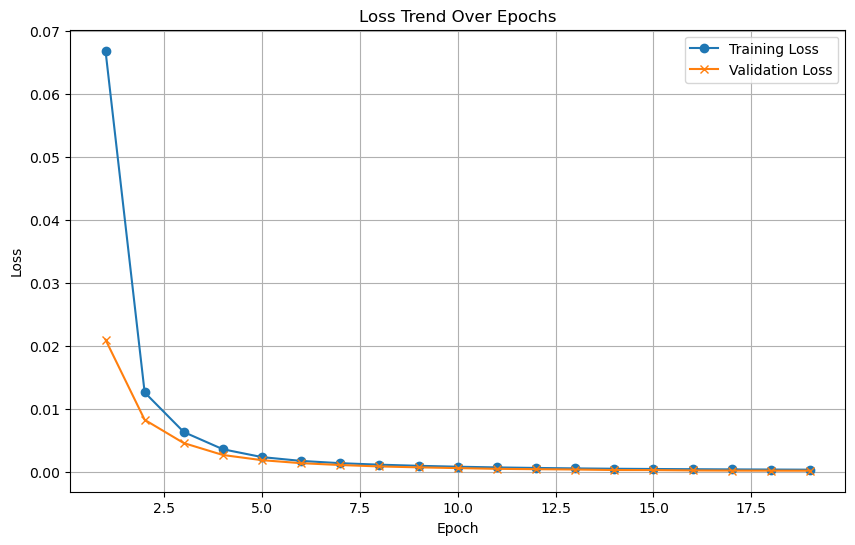

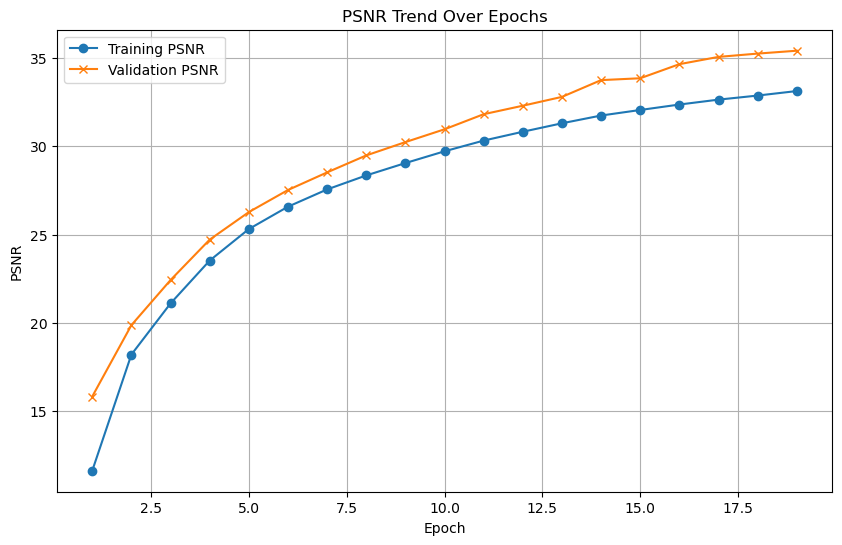

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/210 for test dataset.


    Processed batch 101/210 for test dataset.


    Processed batch 201/210 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.8033
    Validation Batch [1/1], Loss: 2.7775
Validation Loss: 2.7775, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7775. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7390
    Validation Batch [1/1], Loss: 2.7775
Validation Loss: 2.7775, Validation Accuracy: 6.25%
Validation loss improved from 2.7775 to 2.7775. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7084
    Validation Batch [1/1], Loss: 2.7775
Validation Loss: 2.7775, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.6826
    Validation Batch [1/1], Loss: 2.7776
Validation Loss: 2.7776, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] comple

Epoch [16/1000] completed, Average Training Loss: 2.4806
    Validation Batch [1/1], Loss: 2.7775
Validation Loss: 2.7775, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.4642
    Validation Batch [1/1], Loss: 2.7774
Validation Loss: 2.7774, Validation Accuracy: 6.25%
Validation loss improved from 2.7775 to 2.7774. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.4603
    Validation Batch [1/1], Loss: 2.7775
Validation Loss: 2.7775, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.4562
    Validation Batch [1/1], Loss: 2.7777
Validation Loss: 2.7777, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.4356

Epoch [38/1000] completed, Average Training Loss: 2.2519
    Validation Batch [1/1], Loss: 2.7491
Validation Loss: 2.7491, Validation Accuracy: 7.50%
Validation loss improved from 2.7532 to 2.7491. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.2345
    Validation Batch [1/1], Loss: 2.7447
Validation Loss: 2.7447, Validation Accuracy: 7.50%
Validation loss improved from 2.7491 to 2.7447. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.2330
    Validation Batch [1/1], Loss: 2.7388
Validation Loss: 2.7388, Validation Accuracy: 7.50%
Validation loss improved from 2.7447 to 2.7388. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.2095
    Validation Batch [1/1], Loss: 2.7320
Validation Loss: 2.7320, Validation Accuracy: 7.50%
Validation loss improved from 2.7388 to 2.7320. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/10

    Validation Batch [1/1], Loss: 2.3407
Validation Loss: 2.3407, Validation Accuracy: 32.50%
Validation loss improved from 2.3694 to 2.3407. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 2.0401
    Validation Batch [1/1], Loss: 2.3223
Validation Loss: 2.3223, Validation Accuracy: 32.50%
Validation loss improved from 2.3407 to 2.3223. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 2.0392
    Validation Batch [1/1], Loss: 2.3060
Validation Loss: 2.3060, Validation Accuracy: 32.50%
Validation loss improved from 2.3223 to 2.3060. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 2.0451
    Validation Batch [1/1], Loss: 2.2774
Validation Loss: 2.2774, Validation Accuracy: 32.50%
Validation loss improved from 2.3060 to 2.2774. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 2.0131
    Vali

Epoch [74/1000] completed, Average Training Loss: 1.9154
    Validation Batch [1/1], Loss: 2.0197
Validation Loss: 2.0197, Validation Accuracy: 56.25%
Validation loss improved from 2.0440 to 2.0197. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 1.9079
    Validation Batch [1/1], Loss: 1.9979
Validation Loss: 1.9979, Validation Accuracy: 56.25%
Validation loss improved from 2.0197 to 1.9979. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [76/1000] completed, Average Training Loss: 1.9011
    Validation Batch [1/1], Loss: 1.9882
Validation Loss: 1.9882, Validation Accuracy: 57.50%
Validation loss improved from 1.9979 to 1.9882. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 1.8935
    Validation Batch [1/1], Loss: 1.9652
Validation Loss: 1.9652, Validation Accuracy: 60.00%
Validation loss improved from 1.9882 to 1.9652. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [7

Epoch [96/1000] completed, Average Training Loss: 1.7886
    Validation Batch [1/1], Loss: 1.7277
Validation Loss: 1.7277, Validation Accuracy: 82.50%
Validation loss improved from 1.7358 to 1.7277. Saving model...

LOG: Epoch [97/1000] - Training
Epoch [97/1000] completed, Average Training Loss: 1.7414
    Validation Batch [1/1], Loss: 1.7223
Validation Loss: 1.7223, Validation Accuracy: 82.50%
Validation loss improved from 1.7277 to 1.7223. Saving model...

LOG: Epoch [98/1000] - Training
Epoch [98/1000] completed, Average Training Loss: 1.7463
    Validation Batch [1/1], Loss: 1.7086
Validation Loss: 1.7086, Validation Accuracy: 81.25%
Validation loss improved from 1.7223 to 1.7086. Saving model...

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.7089
    Validation Batch [1/1], Loss: 1.6903
Validation Loss: 1.6903, Validation Accuracy: 87.50%
Validation loss improved from 1.7086 to 1.6903. Saving model...

LOG: Epoch [100/1000] - Training
Epoch [

Epoch [119/1000] completed, Average Training Loss: 1.5487
    Validation Batch [1/1], Loss: 1.5460
Validation Loss: 1.5460, Validation Accuracy: 87.50%
Validation loss improved from 1.5657 to 1.5460. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 1.5655
    Validation Batch [1/1], Loss: 1.5432
Validation Loss: 1.5432, Validation Accuracy: 85.00%
Validation loss improved from 1.5460 to 1.5432. Saving model...

LOG: Epoch [121/1000] - Training
Epoch [121/1000] completed, Average Training Loss: 1.5443
    Validation Batch [1/1], Loss: 1.5028
Validation Loss: 1.5028, Validation Accuracy: 87.50%
Validation loss improved from 1.5432 to 1.5028. Saving model...

LOG: Epoch [122/1000] - Training
Epoch [122/1000] completed, Average Training Loss: 1.5257
    Validation Batch [1/1], Loss: 1.5085
Validation Loss: 1.5085, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000

    Validation Batch [1/1], Loss: 1.3836
Validation Loss: 1.3836, Validation Accuracy: 87.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.4022
    Validation Batch [1/1], Loss: 1.3532
Validation Loss: 1.3532, Validation Accuracy: 88.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.3779
    Validation Batch [1/1], Loss: 1.3155
Validation Loss: 1.3155, Validation Accuracy: 90.00%
Validation loss improved from 1.3385 to 1.3155. Saving model...

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.3463
    Validation Batch [1/1], Loss: 1.3182
Validation Loss: 1.3182, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [145/1000] - Training
Epoch [145/1000] completed, Average Training Loss: 1.3433
    Validation Batch [1/1], Loss: 1.3325
Vali

Epoch [164/1000] completed, Average Training Loss: 1.1825
    Validation Batch [1/1], Loss: 1.1197
Validation Loss: 1.1197, Validation Accuracy: 92.50%
Validation loss improved from 1.1468 to 1.1197. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.2005
    Validation Batch [1/1], Loss: 1.1036
Validation Loss: 1.1036, Validation Accuracy: 93.75%
Validation loss improved from 1.1197 to 1.1036. Saving model...

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.2004
    Validation Batch [1/1], Loss: 1.1774
Validation Loss: 1.1774, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.1713
    Validation Batch [1/1], Loss: 1.1394
Validation Loss: 1.1394, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Av

Epoch [186/1000] completed, Average Training Loss: 1.0324
    Validation Batch [1/1], Loss: 0.9587
Validation Loss: 0.9587, Validation Accuracy: 90.00%
Validation loss improved from 0.9665 to 0.9587. Saving model...

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 1.0278
    Validation Batch [1/1], Loss: 0.9613
Validation Loss: 0.9613, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 1.0092
    Validation Batch [1/1], Loss: 0.9869
Validation Loss: 0.9869, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.9589
    Validation Batch [1/1], Loss: 1.0215
Validation Loss: 1.0215, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training 

Epoch [209/1000] completed, Average Training Loss: 0.8562
    Validation Batch [1/1], Loss: 0.8888
Validation Loss: 0.8888, Validation Accuracy: 86.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.8200
    Validation Batch [1/1], Loss: 0.8094
Validation Loss: 0.8094, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.8627
    Validation Batch [1/1], Loss: 0.7907
Validation Loss: 0.7907, Validation Accuracy: 95.00%
Validation loss improved from 0.8048 to 0.7907. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.8291
    Validation Batch [1/1], Loss: 0.8111
Validation Loss: 0.8111, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training 

Epoch [232/1000] completed, Average Training Loss: 0.6769
    Validation Batch [1/1], Loss: 0.6855
Validation Loss: 0.6855, Validation Accuracy: 91.25%
Validation loss improved from 0.6860 to 0.6855. Saving model...

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.7063
    Validation Batch [1/1], Loss: 0.7066
Validation Loss: 0.7066, Validation Accuracy: 92.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.6796
    Validation Batch [1/1], Loss: 0.6801
Validation Loss: 0.6801, Validation Accuracy: 95.00%
Validation loss improved from 0.6855 to 0.6801. Saving model...

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.6843
    Validation Batch [1/1], Loss: 0.6589
Validation Loss: 0.6589, Validation Accuracy: 95.00%
Validation loss improved from 0.6801 to 0.6589. Saving model...

LOG: Epoch [236/1000] - Training
Epoch [236/1000

    Validation Batch [1/1], Loss: 0.6351
Validation Loss: 0.6351, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [255/1000] - Training
Epoch [255/1000] completed, Average Training Loss: 0.5964
    Validation Batch [1/1], Loss: 0.5901
Validation Loss: 0.5901, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.5882
    Validation Batch [1/1], Loss: 0.5952
Validation Loss: 0.5952, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.5801
    Validation Batch [1/1], Loss: 0.6781
Validation Loss: 0.6781, Validation Accuracy: 91.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.5700
    Validation Batch [1/1], Loss: 0.5731
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.4873
Validation Loss: 0.4873, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.4700
    Validation Batch [1/1], Loss: 0.4832
Validation Loss: 0.4832, Validation Accuracy: 95.00%
Validation loss improved from 0.4865 to 0.4832. Saving model...

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.4861
    Validation Batch [1/1], Loss: 0.4716
Validation Loss: 0.4716, Validation Accuracy: 95.00%
Validation loss improved from 0.4832 to 0.4716. Saving model...

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.4754
    Validation Batch [1/1], Loss: 0.4772
Validation Loss: 0.4772, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.4682
    Validation Batch [1/1], Lo

Epoch [302/1000] completed, Average Training Loss: 0.3902
    Validation Batch [1/1], Loss: 0.4110
Validation Loss: 0.4110, Validation Accuracy: 95.00%
Validation loss improved from 0.4332 to 0.4110. Saving model...

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.3698
    Validation Batch [1/1], Loss: 0.3941
Validation Loss: 0.3941, Validation Accuracy: 96.25%
Validation loss improved from 0.4110 to 0.3941. Saving model...

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.3671
    Validation Batch [1/1], Loss: 0.3964
Validation Loss: 0.3964, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.3741
    Validation Batch [1/1], Loss: 0.4060
Validation Loss: 0.4060, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Av

    Validation Batch [1/1], Loss: 0.3953
Validation Loss: 0.3953, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.3403
    Validation Batch [1/1], Loss: 0.3589
Validation Loss: 0.3589, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [326/1000] - Training
Epoch [326/1000] completed, Average Training Loss: 0.3089
    Validation Batch [1/1], Loss: 0.3506
Validation Loss: 0.3506, Validation Accuracy: 96.25%
Validation loss improved from 0.3559 to 0.3506. Saving model...

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.3177
    Validation Batch [1/1], Loss: 0.3456
Validation Loss: 0.3456, Validation Accuracy: 96.25%
Validation loss improved from 0.3506 to 0.3456. Saving model...

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training Loss: 0.3300
    Validation Batch [1/1], Lo

Epoch [347/1000] completed, Average Training Loss: 0.2845
    Validation Batch [1/1], Loss: 0.3061
Validation Loss: 0.3061, Validation Accuracy: 96.25%
Validation loss improved from 0.3102 to 0.3061. Saving model...

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.2823
    Validation Batch [1/1], Loss: 0.3117
Validation Loss: 0.3117, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.2838
    Validation Batch [1/1], Loss: 0.3208
Validation Loss: 0.3208, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.2582
    Validation Batch [1/1], Loss: 0.3219
Validation Loss: 0.3219, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training 

Epoch [370/1000] completed, Average Training Loss: 0.2204
    Validation Batch [1/1], Loss: 0.2765
Validation Loss: 0.2765, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.2219
    Validation Batch [1/1], Loss: 0.2799
Validation Loss: 0.2799, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.2319
    Validation Batch [1/1], Loss: 0.2727
Validation Loss: 0.2727, Validation Accuracy: 96.25%
Validation loss improved from 0.2764 to 0.2727. Saving model...

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.2062
    Validation Batch [1/1], Loss: 0.2842
Validation Loss: 0.2842, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training 

Epoch [394/1000] completed, Average Training Loss: 0.1714
    Validation Batch [1/1], Loss: 0.2581
Validation Loss: 0.2581, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.1995
    Validation Batch [1/1], Loss: 0.2484
Validation Loss: 0.2484, Validation Accuracy: 96.25%
Validation loss improved from 0.2503 to 0.2484. Saving model...

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.1874
    Validation Batch [1/1], Loss: 0.2644
Validation Loss: 0.2644, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.1740
    Validation Batch [1/1], Loss: 0.2804
Validation Loss: 0.2804, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.2539
Validation Loss: 0.2539, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.1712
    Validation Batch [1/1], Loss: 0.2416
Validation Loss: 0.2416, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.1626
    Validation Batch [1/1], Loss: 0.2381
Validation Loss: 0.2381, Validation Accuracy: 96.25%
Validation loss improved from 0.2406 to 0.2381. Saving model...

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.1533
    Validation Batch [1/1], Loss: 0.2369
Validation Loss: 0.2369, Validation Accuracy: 95.00%
Validation loss improved from 0.2381 to 0.2369. Saving model...

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.1539
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 0.2500
Validation Loss: 0.2500, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.1337
    Validation Batch [1/1], Loss: 0.2495
Validation Loss: 0.2495, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.1317
    Validation Batch [1/1], Loss: 0.2348
Validation Loss: 0.2348, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.1438
    Validation Batch [1/1], Loss: 0.2324
Validation Loss: 0.2324, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.1420
    Validation Batch [1/1], Loss: 0.2286
Validation Loss

Epoch [462/1000] completed, Average Training Loss: 0.1227
    Validation Batch [1/1], Loss: 0.2182
Validation Loss: 0.2182, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.1194
    Validation Batch [1/1], Loss: 0.2427
Validation Loss: 0.2427, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Average Training Loss: 0.1234
    Validation Batch [1/1], Loss: 0.2664
Validation Loss: 0.2664, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.1120
    Validation Batch [1/1], Loss: 0.2441
Validation Loss: 0.2441, Validation Accuracy: 93.75%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.120

Epoch [484/1000] completed, Average Training Loss: 0.1066
    Validation Batch [1/1], Loss: 0.2123
Validation Loss: 0.2123, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.1055
    Validation Batch [1/1], Loss: 0.2246
Validation Loss: 0.2246, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.1034
    Validation Batch [1/1], Loss: 0.2189
Validation Loss: 0.2189, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.1032
    Validation Batch [1/1], Loss: 0.2138
Validation Loss: 0.2138, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [488/1000] - Training
Epoch [488/1000] completed, Average Training Loss: 0.1110
  

Epoch [508/1000] completed, Average Training Loss: 0.0999
    Validation Batch [1/1], Loss: 0.2208
Validation Loss: 0.2208, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.0943
    Validation Batch [1/1], Loss: 0.2248
Validation Loss: 0.2248, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0892
    Validation Batch [1/1], Loss: 0.2143
Validation Loss: 0.2143, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.0879
    Validation Batch [1/1], Loss: 0.2049
Validation Loss: 0.2049, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.087

Epoch [530/1000] completed, Average Training Loss: 0.0833
    Validation Batch [1/1], Loss: 0.2079
Validation Loss: 0.2079, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0717
    Validation Batch [1/1], Loss: 0.2073
Validation Loss: 0.2073, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0770
    Validation Batch [1/1], Loss: 0.2127
Validation Loss: 0.2127, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0902
    Validation Batch [1/1], Loss: 0.2185
Validation Loss: 0.2185, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0829
 

Epoch [554/1000] completed, Average Training Loss: 0.0707
    Validation Batch [1/1], Loss: 0.1982
Validation Loss: 0.1982, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.0728
    Validation Batch [1/1], Loss: 0.1959
Validation Loss: 0.1959, Validation Accuracy: 96.25%
Validation loss improved from 0.1980 to 0.1959. Saving model...

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0769
    Validation Batch [1/1], Loss: 0.1980
Validation Loss: 0.1980, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0718
    Validation Batch [1/1], Loss: 0.2021
Validation Loss: 0.2021, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training

    Validation Batch [1/1], Loss: 0.1961
Validation Loss: 0.1961, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [577/1000] - Training
Epoch [577/1000] completed, Average Training Loss: 0.0720
    Validation Batch [1/1], Loss: 0.2160
Validation Loss: 0.2160, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [578/1000] - Training
Epoch [578/1000] completed, Average Training Loss: 0.0628
    Validation Batch [1/1], Loss: 0.2042
Validation Loss: 0.2042, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [579/1000] - Training
Epoch [579/1000] completed, Average Training Loss: 0.0648
    Validation Batch [1/1], Loss: 0.2124
Validation Loss: 0.2124, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [580/1000] - Training
Epoch [580/1000] completed, Average Training Loss: 0.0564
    Validation Batch [1/1], Loss: 0.2160
Validation Loss: 0.

Epoch [600/1000] completed, Average Training Loss: 0.0646
    Validation Batch [1/1], Loss: 0.1961
Validation Loss: 0.1961, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [601/1000] - Training
Epoch [601/1000] completed, Average Training Loss: 0.0622
    Validation Batch [1/1], Loss: 0.2052
Validation Loss: 0.2052, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [602/1000] - Training
Epoch [602/1000] completed, Average Training Loss: 0.0582
    Validation Batch [1/1], Loss: 0.2102
Validation Loss: 0.2102, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [603/1000] - Training
Epoch [603/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.2083
Validation Loss: 0.2083, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [604/1000] - Training
Epoch [604/1000] completed, Average Training Loss: 0.057

Epoch [624/1000] completed, Average Training Loss: 0.0519
    Validation Batch [1/1], Loss: 0.2179
Validation Loss: 0.2179, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [625/1000] - Training
Epoch [625/1000] completed, Average Training Loss: 0.0547
    Validation Batch [1/1], Loss: 0.2244
Validation Loss: 0.2244, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [626/1000] - Training
Epoch [626/1000] completed, Average Training Loss: 0.0509
    Validation Batch [1/1], Loss: 0.2233
Validation Loss: 0.2233, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [627/1000] - Training
Epoch [627/1000] completed, Average Training Loss: 0.0532
    Validation Batch [1/1], Loss: 0.2200
Validation Loss: 0.2200, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [628/1000] - Training
Epoch [628/1000] completed, Average Training Loss: 0.048

Epoch [647/1000] completed, Average Training Loss: 0.0586
    Validation Batch [1/1], Loss: 0.2102
Validation Loss: 0.2102, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [648/1000] - Training
Epoch [648/1000] completed, Average Training Loss: 0.0539
    Validation Batch [1/1], Loss: 0.2134
Validation Loss: 0.2134, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [649/1000] - Training
Epoch [649/1000] completed, Average Training Loss: 0.0641
    Validation Batch [1/1], Loss: 0.2101
Validation Loss: 0.2101, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [650/1000] - Training
Epoch [650/1000] completed, Average Training Loss: 0.0438
    Validation Batch [1/1], Loss: 0.2112
Validation Loss: 0.2112, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [651/1000] - Training
Epoch [651/1000] completed, Average Training Loss: 0.047

Epoch [670/1000] completed, Average Training Loss: 0.0428
    Validation Batch [1/1], Loss: 0.2235
Validation Loss: 0.2235, Validation Accuracy: 95.00%
Validation loss did not improve. Patience: 96/100

LOG: Epoch [671/1000] - Training
Epoch [671/1000] completed, Average Training Loss: 0.0502
    Validation Batch [1/1], Loss: 0.2173
Validation Loss: 0.2173, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [672/1000] - Training
Epoch [672/1000] completed, Average Training Loss: 0.0463
    Validation Batch [1/1], Loss: 0.2108
Validation Loss: 0.2108, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [673/1000] - Training
Epoch [673/1000] completed, Average Training Loss: 0.0502
    Validation Batch [1/1], Loss: 0.2085
Validation Loss: 0.2085, Validation Accuracy: 96.25%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [674/1000] - Training
Epoch [674/1000] completed, Average Training Loss: 0.048

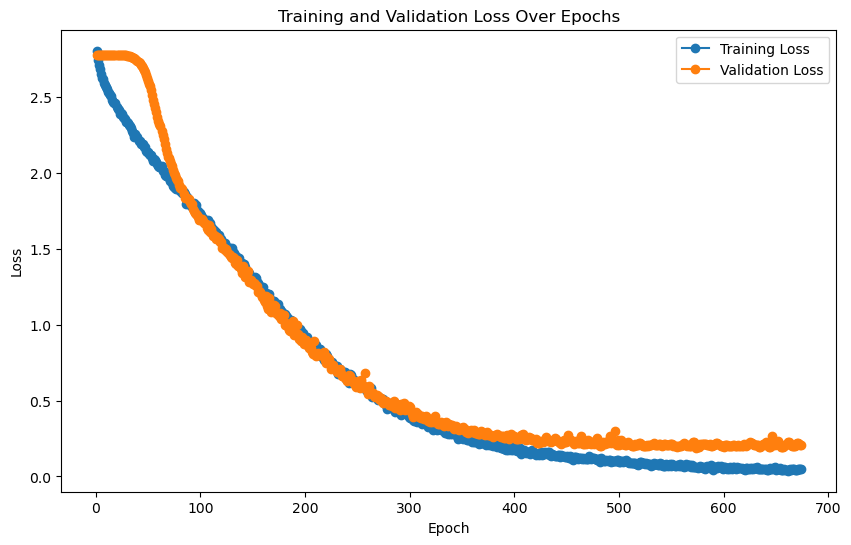

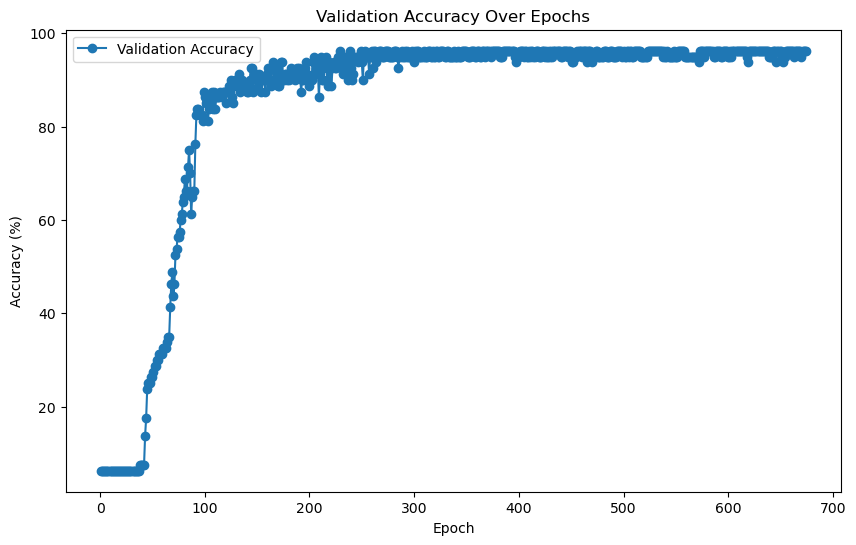


Evaluating on the test set...
    Test Batch [1/210], Loss: 0.1169



Final Test Loss: 0.3311, Test Accuracy: 90.05%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/210 for test dataset.
  Processed batch 20/210 for test dataset.
  Processed batch 30/210 for test dataset.


  Processed batch 40/210 for test dataset.
  Processed batch 50/210 for test dataset.
  Processed batch 60/210 for test dataset.
  Processed batch 70/210 for test dataset.
  Processed batch 80/210 for test dataset.


  Processed batch 90/210 for test dataset.
  Processed batch 100/210 for test dataset.
  Processed batch 110/210 for test dataset.
  Processed batch 120/210 for test dataset.
  Processed batch 130/210 for test dataset.


  Processed batch 140/210 for test dataset.
  Processed batch 150/210 for test dataset.


  Processed batch 160/210 for test dataset.
  Processed batch 170/210 for test dataset.
  Processed batch 180/210 for test dataset.
  Processed batch 190/210 for test dataset.
  Processed batch 200/210 for test dataset.


  Processed batch 210/210 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)

LOG: Training features shape: (320, 64), Training labels shape: (320,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (53729, 64), Test labels shape: (53729,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 93.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.60      0.60      0.60         5
           8       1.00      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)
Train reps shape: (320, 64)
Train labels shape: (320,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (53729, 64)
Test labels shape: (53729,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7988  |  Val Loss: 2.6783
Validation loss improved from inf to 2.6783.
[Epoch 2/1000] Train Loss: 2.6195  |  Val Loss: 2.5487
Validation loss improved from 2.6783 to 2.5487.
[Epoch 3/1000] Train Loss: 2.5041  |  Val Loss: 2.4288
Validation loss improved from 2.5487 to 2.4288.
[Epoch 4/1000] Train Loss: 2.3871  |  Val Loss: 2.3183
Validation loss improved from 2.4288 to 2.3183.
[Epoch 5/1000] Train Loss: 2.2792  |  Val Loss: 2.2097
Validation loss improved from 2.3183 to 2.2097.
[Epoch 6/1000] Train Loss: 2.1661  |  Val Loss: 2.0973
Validation loss improved from 2.2097 to 2.0973.
[Epoch 7/1000] Train Loss: 2.0501  |  Val Loss: 1.9847
Validation loss improved from 2.0973 to 1.9847.
[Epoch 8/1000] Train Loss: 1.9325  |  Val Loss: 1.8581
Validation loss improved from 1.9847 to 1.8581.
[Epoch 9/1000] Train Loss: 1.8126  |  Val Loss: 1.7316
Validation loss improved from 1.8581 to 1.7316.
[Epoch 10/1000] Train Loss: 1.6855  |  Val Loss: 1.6141
Validation loss impr

[Epoch 12/1000] Train Loss: 1.4553  |  Val Loss: 1.3917
Validation loss improved from 1.5004 to 1.3917.
[Epoch 13/1000] Train Loss: 1.3540  |  Val Loss: 1.2971
Validation loss improved from 1.3917 to 1.2971.
[Epoch 14/1000] Train Loss: 1.2555  |  Val Loss: 1.1999
Validation loss improved from 1.2971 to 1.1999.
[Epoch 15/1000] Train Loss: 1.1635  |  Val Loss: 1.1075
Validation loss improved from 1.1999 to 1.1075.
[Epoch 16/1000] Train Loss: 1.0813  |  Val Loss: 1.0241
Validation loss improved from 1.1075 to 1.0241.
[Epoch 17/1000] Train Loss: 1.0018  |  Val Loss: 0.9549
Validation loss improved from 1.0241 to 0.9549.
[Epoch 18/1000] Train Loss: 0.9240  |  Val Loss: 0.8890
Validation loss improved from 0.9549 to 0.8890.
[Epoch 19/1000] Train Loss: 0.8505  |  Val Loss: 0.8222
Validation loss improved from 0.8890 to 0.8222.
[Epoch 20/1000] Train Loss: 0.7958  |  Val Loss: 0.7711
Validation loss improved from 0.8222 to 0.7711.
[Epoch 21/1000] Train Loss: 0.7456  |  Val Loss: 0.7242
Validati

[Epoch 22/1000] Train Loss: 0.7025  |  Val Loss: 0.6931
Validation loss improved from 0.7242 to 0.6931.
[Epoch 23/1000] Train Loss: 0.6582  |  Val Loss: 0.6451
Validation loss improved from 0.6931 to 0.6451.
[Epoch 24/1000] Train Loss: 0.6221  |  Val Loss: 0.6209
Validation loss improved from 0.6451 to 0.6209.
[Epoch 25/1000] Train Loss: 0.5869  |  Val Loss: 0.5737
Validation loss improved from 0.6209 to 0.5737.
[Epoch 26/1000] Train Loss: 0.5572  |  Val Loss: 0.5558
Validation loss improved from 0.5737 to 0.5558.
[Epoch 27/1000] Train Loss: 0.5362  |  Val Loss: 0.5368
Validation loss improved from 0.5558 to 0.5368.
[Epoch 28/1000] Train Loss: 0.5227  |  Val Loss: 0.5023
Validation loss improved from 0.5368 to 0.5023.
[Epoch 29/1000] Train Loss: 0.4964  |  Val Loss: 0.4907
Validation loss improved from 0.5023 to 0.4907.
[Epoch 30/1000] Train Loss: 0.4704  |  Val Loss: 0.4691
Validation loss improved from 0.4907 to 0.4691.


[Epoch 31/1000] Train Loss: 0.4593  |  Val Loss: 0.4518
Validation loss improved from 0.4691 to 0.4518.
[Epoch 32/1000] Train Loss: 0.4419  |  Val Loss: 0.4497
Validation loss improved from 0.4518 to 0.4497.
[Epoch 33/1000] Train Loss: 0.4230  |  Val Loss: 0.4186
Validation loss improved from 0.4497 to 0.4186.
[Epoch 34/1000] Train Loss: 0.4083  |  Val Loss: 0.4041
Validation loss improved from 0.4186 to 0.4041.
[Epoch 35/1000] Train Loss: 0.3966  |  Val Loss: 0.4010
Validation loss improved from 0.4041 to 0.4010.
[Epoch 36/1000] Train Loss: 0.3830  |  Val Loss: 0.4001
Validation loss improved from 0.4010 to 0.4001.
[Epoch 37/1000] Train Loss: 0.3703  |  Val Loss: 0.3776
Validation loss improved from 0.4001 to 0.3776.
[Epoch 38/1000] Train Loss: 0.3626  |  Val Loss: 0.3533
Validation loss improved from 0.3776 to 0.3533.
[Epoch 39/1000] Train Loss: 0.3538  |  Val Loss: 0.3564
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 40/1000] Train Loss: 0.3564  |  Val Loss: 0.3494
Validation loss improved from 0.3533 to 0.3494.
[Epoch 41/1000] Train Loss: 0.3598  |  Val Loss: 0.3440
Validation loss improved from 0.3494 to 0.3440.
[Epoch 42/1000] Train Loss: 0.3430  |  Val Loss: 0.3577
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 43/1000] Train Loss: 0.3408  |  Val Loss: 0.3634
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 44/1000] Train Loss: 0.3199  |  Val Loss: 0.3243
Validation loss improved from 0.3440 to 0.3243.
[Epoch 45/1000] Train Loss: 0.3035  |  Val Loss: 0.3078
Validation loss improved from 0.3243 to 0.3078.
[Epoch 46/1000] Train Loss: 0.3020  |  Val Loss: 0.3138
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 47/1000] Train Loss: 0.2976  |  Val Loss: 0.3105
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 48/1000] Train Loss: 0.2855  |  Val Loss: 0.3147
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 49/1000] Train Loss: 0.2837  |  Val Loss: 0.3050
Validation loss improved from 0.3078 to 0.3050.
[Epoch 50/1000] Train Loss: 0.2780  |  Val Loss: 0.2923
Validation loss improved from 0.3050 to 0.2923.
[Epoch 51/1000] Train Loss: 0.2697  |  Val Loss: 0.2892
Validation loss improved from 0.2923 to 0.2892.
[Epoch 52/1000] Train Loss: 0.2652  |  Val Loss: 0.2905
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 53/1000] Train Loss: 0.2536  |  Val Loss: 0.2837
Validation loss improved from 0.2892 to 0.2837.
[Epoch 54/1000] Train Loss: 0.2569  |  Val Loss: 0.2732
Validation loss improved from 0.2837 to 0.2732.
[Epoch 55/1000] Train Loss: 0.2553  |  Val Loss: 0.2717
Validation loss improved from 0.2732 to 0.2717.
[Epoch 56/1000] Train Loss: 0.2509  |  Val Loss: 0.2789
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 0.2397  |  Val Loss: 0.2662
Validation loss improved from 0.2717 to 0.2662.
[Epoch 58/1000] Train Loss: 0.2428  |  Val Loss: 0.2

[Epoch 59/1000] Train Loss: 0.2371  |  Val Loss: 0.2634
Validation loss improved from 0.2662 to 0.2634.
[Epoch 60/1000] Train Loss: 0.2335  |  Val Loss: 0.2580
Validation loss improved from 0.2634 to 0.2580.
[Epoch 61/1000] Train Loss: 0.2307  |  Val Loss: 0.2676
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 0.2236  |  Val Loss: 0.2701
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 63/1000] Train Loss: 0.2227  |  Val Loss: 0.2511
Validation loss improved from 0.2580 to 0.2511.
[Epoch 64/1000] Train Loss: 0.2171  |  Val Loss: 0.2538
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 65/1000] Train Loss: 0.2150  |  Val Loss: 0.2535
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 66/1000] Train Loss: 0.2148  |  Val Loss: 0.2477
Validation loss improved from 0.2511 to 0.2477.
[Epoch 67/1000] Train Loss: 0.2129  |  Val Loss: 0.2553
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 68/1000] Train Loss: 0.2126  |  Val Loss: 0.2418
Validation loss improved from 0.2477 to 0.2418.
[Epoch 69/1000] Train Loss: 0.2098  |  Val Loss: 0.2448
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 70/1000] Train Loss: 0.2100  |  Val Loss: 0.2665
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 71/1000] Train Loss: 0.2030  |  Val Loss: 0.2469
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 72/1000] Train Loss: 0.1978  |  Val Loss: 0.2468
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 73/1000] Train Loss: 0.2016  |  Val Loss: 0.2431
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 74/1000] Train Loss: 0.1969  |  Val Loss: 0.2412
Validation loss improved from 0.2418 to 0.2412.
[Epoch 75/1000] Train Loss: 0.1958  |  Val Loss: 0.2578
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 76/1000] Train Loss: 0.1922  |  Val Loss: 0.2383
Validation loss improved from 0.2412 to 0.2383.


[Epoch 77/1000] Train Loss: 0.1996  |  Val Loss: 0.2325
Validation loss improved from 0.2383 to 0.2325.
[Epoch 78/1000] Train Loss: 0.1870  |  Val Loss: 0.2518
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 0.1870  |  Val Loss: 0.2504
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 80/1000] Train Loss: 0.1913  |  Val Loss: 0.2448
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 81/1000] Train Loss: 0.1790  |  Val Loss: 0.2412
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 82/1000] Train Loss: 0.1763  |  Val Loss: 0.2444
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 83/1000] Train Loss: 0.1758  |  Val Loss: 0.2326
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 84/1000] Train Loss: 0.1750  |  Val Loss: 0.2405
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 85/1000] Train Loss: 0.1746  |  Val Loss: 0.2425
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 86/1000] 

[Epoch 87/1000] Train Loss: 0.1651  |  Val Loss: 0.2354
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 88/1000] Train Loss: 0.1650  |  Val Loss: 0.2452
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 89/1000] Train Loss: 0.1613  |  Val Loss: 0.2437
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 90/1000] Train Loss: 0.1598  |  Val Loss: 0.2339
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 91/1000] Train Loss: 0.1590  |  Val Loss: 0.2449
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 92/1000] Train Loss: 0.1571  |  Val Loss: 0.2382
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 93/1000] Train Loss: 0.1589  |  Val Loss: 0.2325
Validation loss improved from 0.2325 to 0.2325.
[Epoch 94/1000] Train Loss: 0.1582  |  Val Loss: 0.2453
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 95/1000] Train Loss: 0.1623  |  Val Loss: 0.2297
Validation loss improved from 0.2325 to 0.2297.
[Epoch 96/1000] Train Loss: 0.1503  |  Val Loss: 0.2418
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 97/1000] Train Loss: 0.1505  |  Val Loss: 0.2461
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 98/1000] Train Loss: 0.1561  |  Val Loss: 0.2407
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 99/1000] Train Loss: 0.1573  |  Val Loss: 0.2487
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 100/1000] Train Loss: 0.1490  |  Val Loss: 0.2347
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 101/1000] Train Loss: 0.1482  |  Val Loss: 0.2287
Validation loss improved from 0.2297 to 0.2287.
[Epoch 102/1000] Train Loss: 0.1458  |  Val Loss: 0.2406
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 103/1000] Train Loss: 0.1427  |  Val Loss: 0.2342
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 104/1000] T

[Epoch 107/1000] Train Loss: 0.1428  |  Val Loss: 0.2343
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 108/1000] Train Loss: 0.1320  |  Val Loss: 0.2407
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 109/1000] Train Loss: 0.1333  |  Val Loss: 0.2443
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 110/1000] Train Loss: 0.1291  |  Val Loss: 0.2410
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 111/1000] Train Loss: 0.1302  |  Val Loss: 0.2501
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 112/1000] Train Loss: 0.1291  |  Val Loss: 0.2292
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 113/1000] Train Loss: 0.1279  |  Val Loss: 0.2329
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 114/1000] Train Loss: 0.1260  |  Val Loss: 0.2356
!! Validation loss did NOT improve !! Patience: 13/100


[Epoch 115/1000] Train Loss: 0.1242  |  Val Loss: 0.2432
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 116/1000] Train Loss: 0.1222  |  Val Loss: 0.2390
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 117/1000] Train Loss: 0.1240  |  Val Loss: 0.2375
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 118/1000] Train Loss: 0.1225  |  Val Loss: 0.2390
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 119/1000] Train Loss: 0.1260  |  Val Loss: 0.2556
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 120/1000] Train Loss: 0.1362  |  Val Loss: 0.2438
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 121/1000] Train Loss: 0.1305  |  Val Loss: 0.2498
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 122/1000] Train Loss: 0.1125  |  Val Loss: 0.2577
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 123/1000] Train Loss: 0.1210  |  Val Loss: 0.2635
!! Validation loss did NOT improve !! Patience:

[Epoch 127/1000] Train Loss: 0.1153  |  Val Loss: 0.2286
Validation loss improved from 0.2287 to 0.2286.
[Epoch 128/1000] Train Loss: 0.1108  |  Val Loss: 0.2412
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 129/1000] Train Loss: 0.1175  |  Val Loss: 0.2705
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 130/1000] Train Loss: 0.1132  |  Val Loss: 0.2516
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 131/1000] Train Loss: 0.1028  |  Val Loss: 0.2351
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 132/1000] Train Loss: 0.1128  |  Val Loss: 0.2567
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 133/1000] Train Loss: 0.1088  |  Val Loss: 0.2544
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 134/1000] Train Loss: 0.1149  |  Val Loss: 0.2413
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 135/1000] Train Loss: 0.1011  |  Val Loss: 0.2587
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 136/1000] Train Loss: 0.1069  |  Val Loss: 0.2508
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 137/1000] Train Loss: 0.1032  |  Val Loss: 0.2411
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 138/1000] Train Loss: 0.1028  |  Val Loss: 0.2481
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 139/1000] Train Loss: 0.1045  |  Val Loss: 0.2595
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 147/1000] Train Loss: 0.0925  |  Val Loss: 0.2529
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 148/1000] Train Loss: 0.0939  |  Val Loss: 0.2539
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 149/1000] Train Loss: 0.0901  |  Val Loss: 0.2689
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 150/1000] Train Loss: 0.0900  |  Val Loss: 0.2527
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 151/1000] Train Loss: 0.0923  |  Val Loss: 0.2474
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 152/1000] Train Loss: 0.0921  |  Val Loss: 0.2742
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 153/1000] Train Loss: 0.0874  |  Val Loss: 0.2822
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 154/1000] Train Loss: 0.0845  |  Val Loss: 0.2537
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 155/1000] Train Loss: 0.0924  |  Val Loss: 0.2701
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 156/1000] Train Loss: 0.0945  |  Val Loss: 0.2627
!! Validation loss did NOT improve !! Patience:

[Epoch 168/1000] Train Loss: 0.0805  |  Val Loss: 0.2753
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 169/1000] Train Loss: 0.0812  |  Val Loss: 0.2593
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 170/1000] Train Loss: 0.0754  |  Val Loss: 0.2854
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 171/1000] Train Loss: 0.0751  |  Val Loss: 0.2823
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 172/1000] Train Loss: 0.0822  |  Val Loss: 0.2803
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 173/1000] Train Loss: 0.0719  |  Val Loss: 0.2923
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 174/1000] Train Loss: 0.0730  |  Val Loss: 0.2842
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 175/1000] Train Loss: 0.0717  |  Val Loss: 0.2741
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 176/1000] Train Loss: 0.0719  |  Val Loss: 0.3000
!! Validation loss did NOT improve !! Patience:

[Epoch 187/1000] Train Loss: 0.0692  |  Val Loss: 0.3110
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 188/1000] Train Loss: 0.0777  |  Val Loss: 0.3287
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 189/1000] Train Loss: 0.0859  |  Val Loss: 0.2950
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 190/1000] Train Loss: 0.0692  |  Val Loss: 0.3031
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 191/1000] Train Loss: 0.0694  |  Val Loss: 0.3152
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 192/1000] Train Loss: 0.0685  |  Val Loss: 0.3095
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 193/1000] Train Loss: 0.0660  |  Val Loss: 0.3126
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 194/1000] Train Loss: 0.0655  |  Val Loss: 0.3207
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 195/1000] Train Loss: 0.0581  |  Val Loss: 0.3283
!! Validation loss did NOT improve !! Patience:

[Epoch 205/1000] Train Loss: 0.0598  |  Val Loss: 0.3397
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 206/1000] Train Loss: 0.0626  |  Val Loss: 0.3077
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 207/1000] Train Loss: 0.0547  |  Val Loss: 0.3505
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 208/1000] Train Loss: 0.0572  |  Val Loss: 0.3290
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 209/1000] Train Loss: 0.0564  |  Val Loss: 0.3065
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 210/1000] Train Loss: 0.0806  |  Val Loss: 0.3119
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 211/1000] Train Loss: 0.0837  |  Val Loss: 0.3747
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 212/1000] Train Loss: 0.0912  |  Val Loss: 0.3761
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 213/1000] Train Loss: 0.0672  |  Val Loss: 0.3587
!! Validation loss did NOT improve !! Patience:

[Epoch 225/1000] Train Loss: 0.0503  |  Val Loss: 0.3960
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 226/1000] Train Loss: 0.0481  |  Val Loss: 0.3812
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 227/1000] Train Loss: 0.0452  |  Val Loss: 0.3740
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 227 !!
No improvement for 100 epochs.


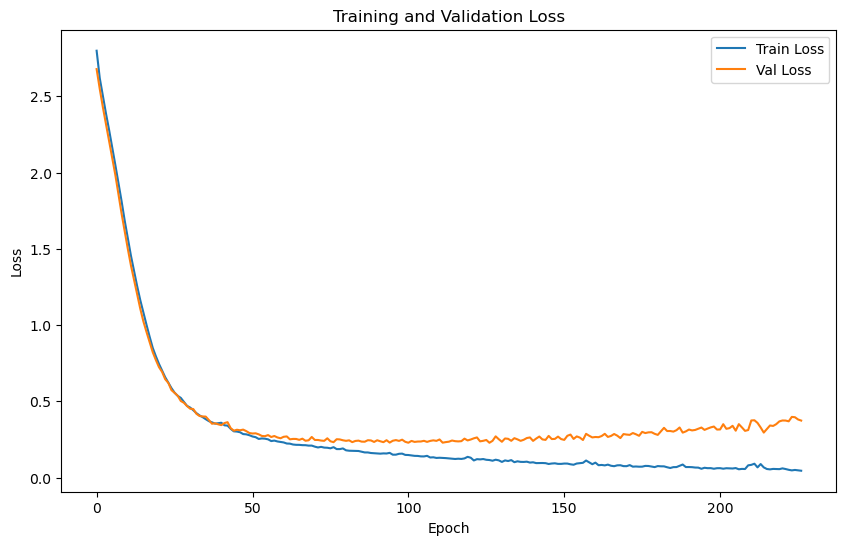

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.5663 | Test Accuracy: 87.49%


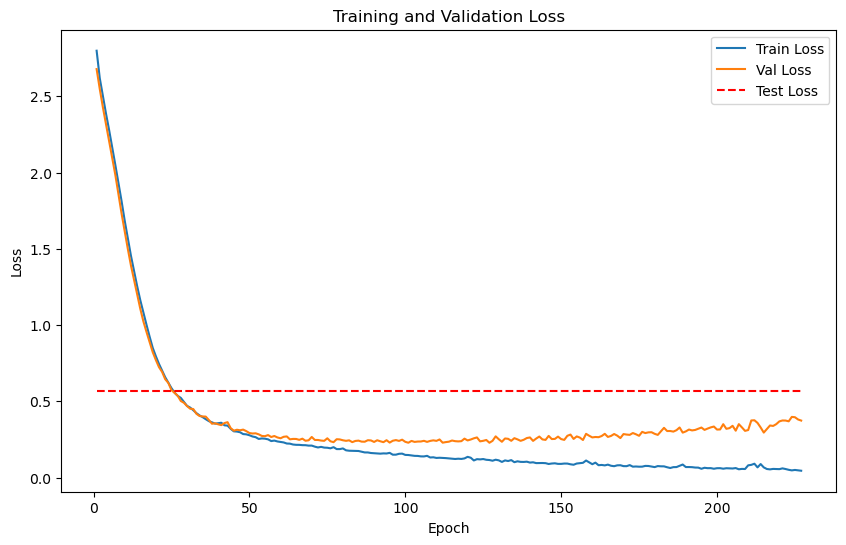

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53729, 64), 
Test labels shape: (53729,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.1884
Epoch [1/2000], Avg Train Loss: 8.1884
Epoch [1/2000], Avg Val Loss: 3.2084
Validation loss improved from inf to 3.2084. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.1847
Epoch [2/2000], Avg Train Loss: 8.1847
Epoch [2/2000], Avg Val Loss: 3.1881
Validation loss improved from 3.2084 to 3.1881. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.8510
Epoch [3/2000], Avg Train Loss: 7.8510
Epoch [3/2000], Avg Val Loss: 3.1684
Validation loss improved from 3.1881 to 3.1684. Saving model...

LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 7.9184
Epoch [4/2000], Avg Train Loss: 7.9184
Epoch [4/2000], Avg Val Loss: 3.1495
Validation loss improved from 3.1684 to 3.1495. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.9332
Epoch [5/2000], Avg Train Loss: 7.9332
Epoch [5/2000], Avg Val Loss: 3.1312
Validation loss improved from 3.1495 to 3.1312. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.7501
Epoch [6/2000], Avg Train Loss: 7.7501
Epoch [6/2000], Avg Val Loss: 3.1136
Validation loss improved from 3.1312 to 3.1136. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.7467
Epoch [7/2000], Avg Train Loss: 7.7467
Epoch [7/2000], Avg Val Loss: 3.0968
Validation loss improved from 3.1136 to 3.0968. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 7.5705
Epoch [8/2000], Avg Train Loss: 7.5705
Epoch [8/2000], Avg Val Loss: 3.0806
Validation loss improved from 3.0968 to 3.0806. Saving m

    Batch [1/1], Train Loss: 6.9250
Epoch [19/2000], Avg Train Loss: 6.9250
Epoch [19/2000], Avg Val Loss: 2.9378
Validation loss improved from 2.9482 to 2.9378. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 6.8719
Epoch [20/2000], Avg Train Loss: 6.8719
Epoch [20/2000], Avg Val Loss: 2.9278
Validation loss improved from 2.9378 to 2.9278. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.7435
Epoch [21/2000], Avg Train Loss: 6.7435
Epoch [21/2000], Avg Val Loss: 2.9183
Validation loss improved from 2.9278 to 2.9183. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.9978
Epoch [22/2000], Avg Train Loss: 6.9978
Epoch [22/2000], Avg Val Loss: 2.9092
Validation loss improved from 2.9183 to 2.9092. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.7395
Epoch [23/2000], Avg Train Loss: 6.7395
Epoch [23/2000], Avg Val Loss: 2.9005
Validation loss improved from 2.9092 to 2.

    Batch [1/1], Train Loss: 6.0922
Epoch [39/2000], Avg Train Loss: 6.0922
Epoch [39/2000], Avg Val Loss: 2.8071
Validation loss improved from 2.8109 to 2.8071. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.0554
Epoch [40/2000], Avg Train Loss: 6.0554
Epoch [40/2000], Avg Val Loss: 2.8036
Validation loss improved from 2.8071 to 2.8036. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 5.9586
Epoch [41/2000], Avg Train Loss: 5.9586
Epoch [41/2000], Avg Val Loss: 2.8003
Validation loss improved from 2.8036 to 2.8003. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 5.8906
Epoch [42/2000], Avg Train Loss: 5.8906
Epoch [42/2000], Avg Val Loss: 2.7971
Validation loss improved from 2.8003 to 2.7971. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 5.9658
Epoch [43/2000], Avg Train Loss: 5.9658
Epoch [43/2000], Avg Val Loss: 2.7941
Validation loss improved from 2.7971 to 2.

    Batch [1/1], Train Loss: 5.6165
Epoch [54/2000], Avg Train Loss: 5.6165
Epoch [54/2000], Avg Val Loss: 2.7715
Validation loss improved from 2.7729 to 2.7715. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.5136
Epoch [55/2000], Avg Train Loss: 5.5136
Epoch [55/2000], Avg Val Loss: 2.7702
Validation loss improved from 2.7715 to 2.7702. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.4703
Epoch [56/2000], Avg Train Loss: 5.4703
Epoch [56/2000], Avg Val Loss: 2.7689
Validation loss improved from 2.7702 to 2.7689. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.4740
Epoch [57/2000], Avg Train Loss: 5.4740
Epoch [57/2000], Avg Val Loss: 2.7678
Validation loss improved from 2.7689 to 2.7678. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.5357
Epoch [58/2000], Avg Train Loss: 5.5357
Epoch [58/2000], Avg Val Loss: 2.7667
Validation loss improved from 2.7678 to 2.

Epoch [74/2000], Avg Val Loss: 2.7562
Validation loss improved from 2.7566 to 2.7562. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.1430
Epoch [75/2000], Avg Train Loss: 5.1430
Epoch [75/2000], Avg Val Loss: 2.7557
Validation loss improved from 2.7562 to 2.7557. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.1704
Epoch [76/2000], Avg Train Loss: 5.1704
Epoch [76/2000], Avg Val Loss: 2.7553
Validation loss improved from 2.7557 to 2.7553. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.1998
Epoch [77/2000], Avg Train Loss: 5.1998
Epoch [77/2000], Avg Val Loss: 2.7549
Validation loss improved from 2.7553 to 2.7549. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.2090
Epoch [78/2000], Avg Train Loss: 5.2090
Epoch [78/2000], Avg Val Loss: 2.7546
Validation loss improved from 2.7549 to 2.7546. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.0407
Epoch [88/2000], Avg Train Loss: 5.0407
Epoch [88/2000], Avg Val Loss: 2.7514
Validation loss improved from 2.7517 to 2.7514. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 5.0075
Epoch [89/2000], Avg Train Loss: 5.0075
Epoch [89/2000], Avg Val Loss: 2.7510
Validation loss improved from 2.7514 to 2.7510. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.0527
Epoch [90/2000], Avg Train Loss: 5.0527
Epoch [90/2000], Avg Val Loss: 2.7507
Validation loss improved from 2.7510 to 2.7507. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 5.0282
Epoch [91/2000], Avg Train Loss: 5.0282
Epoch [91/2000], Avg Val Loss: 2.7503
Validation loss improved from 2.7507 to 2.7503. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 5.0783
Epoch [92/2000], Avg Train Loss: 5.0783
Epoch [92/2000], Avg Val Loss: 2.7500
Validation loss improved from 2.7503 to 2.

    Batch [1/1], Train Loss: 4.8728
Epoch [110/2000], Avg Train Loss: 4.8728
Epoch [110/2000], Avg Val Loss: 2.7420
Validation loss improved from 2.7425 to 2.7420. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.8427
Epoch [111/2000], Avg Train Loss: 4.8427
Epoch [111/2000], Avg Val Loss: 2.7414
Validation loss improved from 2.7420 to 2.7414. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.8513
Epoch [112/2000], Avg Train Loss: 4.8513
Epoch [112/2000], Avg Val Loss: 2.7409
Validation loss improved from 2.7414 to 2.7409. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.8263
Epoch [113/2000], Avg Train Loss: 4.8263
Epoch [113/2000], Avg Val Loss: 2.7403
Validation loss improved from 2.7409 to 2.7403. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.8489
Epoch [114/2000], Avg Train Loss: 4.8489
Epoch [114/2000], Avg Val Loss: 2.7397
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8227
Epoch [120/2000], Avg Train Loss: 4.8227
Epoch [120/2000], Avg Val Loss: 2.7362
Validation loss improved from 2.7368 to 2.7362. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 4.8404
Epoch [121/2000], Avg Train Loss: 4.8404
Epoch [121/2000], Avg Val Loss: 2.7356
Validation loss improved from 2.7362 to 2.7356. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 4.7917
Epoch [122/2000], Avg Train Loss: 4.7917
Epoch [122/2000], Avg Val Loss: 2.7350
Validation loss improved from 2.7356 to 2.7350. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 4.8089
Epoch [123/2000], Avg Train Loss: 4.8089
Epoch [123/2000], Avg Val Loss: 2.7344
Validation loss improved from 2.7350 to 2.7344. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 4.7979
Epoch [124/2000], Avg Train Loss: 4.7979
Epoch [124/2000], Avg Val Loss: 2.7337
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6601
Epoch [147/2000], Avg Train Loss: 4.6601
Epoch [147/2000], Avg Val Loss: 2.7151
Validation loss improved from 2.7160 to 2.7151. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.6826
Epoch [148/2000], Avg Train Loss: 4.6826
Epoch [148/2000], Avg Val Loss: 2.7142
Validation loss improved from 2.7151 to 2.7142. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 4.6427
Epoch [149/2000], Avg Train Loss: 4.6427
Epoch [149/2000], Avg Val Loss: 2.7133
Validation loss improved from 2.7142 to 2.7133. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 4.6741
Epoch [150/2000], Avg Train Loss: 4.6741
Epoch [150/2000], Avg Val Loss: 2.7125
Validation loss improved from 2.7133 to 2.7125. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 4.6508
Epoch [151/2000], Avg Train Loss: 4.6508
Epoch [151/2000], Avg Val Loss: 2.7116
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6328
Epoch [157/2000], Avg Train Loss: 4.6328
Epoch [157/2000], Avg Val Loss: 2.7062
Validation loss improved from 2.7071 to 2.7062. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.6872
Epoch [158/2000], Avg Train Loss: 4.6872
Epoch [158/2000], Avg Val Loss: 2.7053
Validation loss improved from 2.7062 to 2.7053. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.6080
Epoch [159/2000], Avg Train Loss: 4.6080
Epoch [159/2000], Avg Val Loss: 2.7043
Validation loss improved from 2.7053 to 2.7043. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 4.6293
Epoch [160/2000], Avg Train Loss: 4.6293
Epoch [160/2000], Avg Val Loss: 2.7034
Validation loss improved from 2.7043 to 2.7034. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.5805
Epoch [161/2000], Avg Train Loss: 4.5805
Epoch [161/2000], Avg Val Loss: 2.7025
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5880
Epoch [181/2000], Avg Train Loss: 4.5880
Epoch [181/2000], Avg Val Loss: 2.6836
Validation loss improved from 2.6846 to 2.6836. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 4.4996
Epoch [182/2000], Avg Train Loss: 4.4996
Epoch [182/2000], Avg Val Loss: 2.6826
Validation loss improved from 2.6836 to 2.6826. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 4.5442
Epoch [183/2000], Avg Train Loss: 4.5442
Epoch [183/2000], Avg Val Loss: 2.6816
Validation loss improved from 2.6826 to 2.6816. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 4.5644
Epoch [184/2000], Avg Train Loss: 4.5644
Epoch [184/2000], Avg Val Loss: 2.6806
Validation loss improved from 2.6816 to 2.6806. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 4.5650
Epoch [185/2000], Avg Train Loss: 4.5650
Epoch [185/2000], Avg Val Loss: 2.6796
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5804
Epoch [192/2000], Avg Train Loss: 4.5804
Epoch [192/2000], Avg Val Loss: 2.6724
Validation loss improved from 2.6734 to 2.6724. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.5270
Epoch [193/2000], Avg Train Loss: 4.5270
Epoch [193/2000], Avg Val Loss: 2.6714
Validation loss improved from 2.6724 to 2.6714. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.5564
Epoch [194/2000], Avg Train Loss: 4.5564
Epoch [194/2000], Avg Val Loss: 2.6704
Validation loss improved from 2.6714 to 2.6704. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 4.5104
Epoch [195/2000], Avg Train Loss: 4.5104
Epoch [195/2000], Avg Val Loss: 2.6694
Validation loss improved from 2.6704 to 2.6694. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 4.5329
Epoch [196/2000], Avg Train Loss: 4.5329
Epoch [196/2000], Avg Val Loss: 2.6684
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4754
Epoch [218/2000], Avg Train Loss: 4.4754
Epoch [218/2000], Avg Val Loss: 2.6450
Validation loss improved from 2.6461 to 2.6450. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.4726
Epoch [219/2000], Avg Train Loss: 4.4726
Epoch [219/2000], Avg Val Loss: 2.6439
Validation loss improved from 2.6450 to 2.6439. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.4705
Epoch [220/2000], Avg Train Loss: 4.4705
Epoch [220/2000], Avg Val Loss: 2.6429
Validation loss improved from 2.6439 to 2.6429. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.4572
Epoch [221/2000], Avg Train Loss: 4.4572
Epoch [221/2000], Avg Val Loss: 2.6418
Validation loss improved from 2.6429 to 2.6418. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 4.4473
Epoch [222/2000], Avg Train Loss: 4.4473
Epoch [222/2000], Avg Val Loss: 2.6407
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4186
Epoch [226/2000], Avg Train Loss: 4.4186
Epoch [226/2000], Avg Val Loss: 2.6363
Validation loss improved from 2.6374 to 2.6363. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 4.3948
Epoch [227/2000], Avg Train Loss: 4.3948
Epoch [227/2000], Avg Val Loss: 2.6352
Validation loss improved from 2.6363 to 2.6352. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 4.4600
Epoch [228/2000], Avg Train Loss: 4.4600
Epoch [228/2000], Avg Val Loss: 2.6341
Validation loss improved from 2.6352 to 2.6341. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 4.4856
Epoch [229/2000], Avg Train Loss: 4.4856
Epoch [229/2000], Avg Val Loss: 2.6330
Validation loss improved from 2.6341 to 2.6330. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 4.4156
Epoch [230/2000], Avg Train Loss: 4.4156
Epoch [230/2000], Avg Val Loss: 2.6319
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3799
Epoch [256/2000], Avg Train Loss: 4.3799
Epoch [256/2000], Avg Val Loss: 2.6044
Validation loss improved from 2.6055 to 2.6044. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 4.3534
Epoch [257/2000], Avg Train Loss: 4.3534
Epoch [257/2000], Avg Val Loss: 2.6034
Validation loss improved from 2.6044 to 2.6034. Saving model...

LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 4.3434
Epoch [258/2000], Avg Train Loss: 4.3434
Epoch [258/2000], Avg Val Loss: 2.6024
Validation loss improved from 2.6034 to 2.6024. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 4.3824
Epoch [259/2000], Avg Train Loss: 4.3824
Epoch [259/2000], Avg Val Loss: 2.6013
Validation loss improved from 2.6024 to 2.6013. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 4.3543
Epoch [260/2000], Avg Train Loss: 4.3543
Epoch [260/2000], Avg Val Loss: 2.6003
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2875
Epoch [292/2000], Avg Train Loss: 4.2875
Epoch [292/2000], Avg Val Loss: 2.5689
Validation loss improved from 2.5699 to 2.5689. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 4.3216
Epoch [293/2000], Avg Train Loss: 4.3216
Epoch [293/2000], Avg Val Loss: 2.5679
Validation loss improved from 2.5689 to 2.5679. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 4.3056
Epoch [294/2000], Avg Train Loss: 4.3056
Epoch [294/2000], Avg Val Loss: 2.5668
Validation loss improved from 2.5679 to 2.5668. Saving model...

LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 4.2820
Epoch [295/2000], Avg Train Loss: 4.2820
Epoch [295/2000], Avg Val Loss: 2.5658
Validation loss improved from 2.5668 to 2.5658. Saving model...

LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 4.3018
Epoch [296/2000], Avg Train Loss: 4.3018
Epoch [296/2000], Avg Val Loss: 2.5648
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2392
Epoch [329/2000], Avg Train Loss: 4.2392
Epoch [329/2000], Avg Val Loss: 2.5343
Validation loss improved from 2.5353 to 2.5343. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 4.2491
Epoch [330/2000], Avg Train Loss: 4.2491
Epoch [330/2000], Avg Val Loss: 2.5334
Validation loss improved from 2.5343 to 2.5334. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 4.2515
Epoch [331/2000], Avg Train Loss: 4.2515
Epoch [331/2000], Avg Val Loss: 2.5324
Validation loss improved from 2.5334 to 2.5324. Saving model...

LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 4.2433
Epoch [332/2000], Avg Train Loss: 4.2433
Epoch [332/2000], Avg Val Loss: 2.5315
Validation loss improved from 2.5324 to 2.5315. Saving model...

LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 4.2680
Epoch [333/2000], Avg Train Loss: 4.2680
Epoch [333/2000], Avg Val Loss: 2.5306
Validation loss improved fro

Epoch [365/2000], Avg Val Loss: 2.5021
Validation loss improved from 2.5029 to 2.5021. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 4.2343
Epoch [366/2000], Avg Train Loss: 4.2343
Epoch [366/2000], Avg Val Loss: 2.5012
Validation loss improved from 2.5021 to 2.5012. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 4.1955
Epoch [367/2000], Avg Train Loss: 4.1955
Epoch [367/2000], Avg Val Loss: 2.5003
Validation loss improved from 2.5012 to 2.5003. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 4.1830
Epoch [368/2000], Avg Train Loss: 4.1830
Epoch [368/2000], Avg Val Loss: 2.4995
Validation loss improved from 2.5003 to 2.4995. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 4.2096
Epoch [369/2000], Avg Train Loss: 4.2096
Epoch [369/2000], Avg Val Loss: 2.4986
Validation loss improved from 2.4995 to 2.4986. Saving model...

LOG: Epoch [370/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1634
Epoch [402/2000], Avg Train Loss: 4.1634
Epoch [402/2000], Avg Val Loss: 2.4734
Validation loss improved from 2.4741 to 2.4734. Saving model...

LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 4.1662
Epoch [403/2000], Avg Train Loss: 4.1662
Epoch [403/2000], Avg Val Loss: 2.4727
Validation loss improved from 2.4734 to 2.4727. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 4.1208
Epoch [404/2000], Avg Train Loss: 4.1208
Epoch [404/2000], Avg Val Loss: 2.4720
Validation loss improved from 2.4727 to 2.4720. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 4.1586
Epoch [405/2000], Avg Train Loss: 4.1586
Epoch [405/2000], Avg Val Loss: 2.4713
Validation loss improved from 2.4720 to 2.4713. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 4.1587
Epoch [406/2000], Avg Train Loss: 4.1587
Epoch [406/2000], Avg Val Loss: 2.4706
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0723
Epoch [437/2000], Avg Train Loss: 4.0723
Epoch [437/2000], Avg Val Loss: 2.4476
Validation loss improved from 2.4483 to 2.4476. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 4.1098
Epoch [438/2000], Avg Train Loss: 4.1098
Epoch [438/2000], Avg Val Loss: 2.4469
Validation loss improved from 2.4476 to 2.4469. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 4.0974
Epoch [439/2000], Avg Train Loss: 4.0974
Epoch [439/2000], Avg Val Loss: 2.4462
Validation loss improved from 2.4469 to 2.4462. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 4.0960
Epoch [440/2000], Avg Train Loss: 4.0960
Epoch [440/2000], Avg Val Loss: 2.4455
Validation loss improved from 2.4462 to 2.4455. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 4.1001
Epoch [441/2000], Avg Train Loss: 4.1001
Epoch [441/2000], Avg Val Loss: 2.4448
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0583
Epoch [477/2000], Avg Train Loss: 4.0583
Epoch [477/2000], Avg Val Loss: 2.4222
Validation loss improved from 2.4229 to 2.4222. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 4.1159
Epoch [478/2000], Avg Train Loss: 4.1159
Epoch [478/2000], Avg Val Loss: 2.4216
Validation loss improved from 2.4222 to 2.4216. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 4.0742
Epoch [479/2000], Avg Train Loss: 4.0742
Epoch [479/2000], Avg Val Loss: 2.4210
Validation loss improved from 2.4216 to 2.4210. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 4.0335
Epoch [480/2000], Avg Train Loss: 4.0335
Epoch [480/2000], Avg Val Loss: 2.4204
Validation loss improved from 2.4210 to 2.4204. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 4.0534
Epoch [481/2000], Avg Train Loss: 4.0534
Epoch [481/2000], Avg Val Loss: 2.4199
Validation loss improved fro

Epoch [513/2000], Avg Val Loss: 2.4026
Validation loss improved from 2.4032 to 2.4026. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 4.0137
Epoch [514/2000], Avg Train Loss: 4.0137
Epoch [514/2000], Avg Val Loss: 2.4021
Validation loss improved from 2.4026 to 2.4021. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 4.0351
Epoch [515/2000], Avg Train Loss: 4.0351
Epoch [515/2000], Avg Val Loss: 2.4014
Validation loss improved from 2.4021 to 2.4014. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 4.0189
Epoch [516/2000], Avg Train Loss: 4.0189
Epoch [516/2000], Avg Val Loss: 2.4008
Validation loss improved from 2.4014 to 2.4008. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 4.0649
Epoch [517/2000], Avg Train Loss: 4.0649
Epoch [517/2000], Avg Val Loss: 2.4002
Validation loss improved from 2.4008 to 2.4002. Saving model...

LOG: Epoch [518/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9784
Epoch [550/2000], Avg Train Loss: 3.9784
Epoch [550/2000], Avg Val Loss: 2.3821
Validation loss improved from 2.3827 to 2.3821. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 3.9951
Epoch [551/2000], Avg Train Loss: 3.9951
Epoch [551/2000], Avg Val Loss: 2.3815
Validation loss improved from 2.3821 to 2.3815. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 3.9716
Epoch [552/2000], Avg Train Loss: 3.9716
Epoch [552/2000], Avg Val Loss: 2.3810
Validation loss improved from 2.3815 to 2.3810. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 4.0163
Epoch [553/2000], Avg Train Loss: 4.0163
Epoch [553/2000], Avg Val Loss: 2.3804
Validation loss improved from 2.3810 to 2.3804. Saving model...

LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 3.9957
Epoch [554/2000], Avg Train Loss: 3.9957
Epoch [554/2000], Avg Val Loss: 2.3799
Validation loss improved fro

Epoch [587/2000], Avg Val Loss: 2.3638
Validation loss improved from 2.3642 to 2.3638. Saving model...

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 3.9556
Epoch [588/2000], Avg Train Loss: 3.9556
Epoch [588/2000], Avg Val Loss: 2.3633
Validation loss improved from 2.3638 to 2.3633. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 3.9846
Epoch [589/2000], Avg Train Loss: 3.9846
Epoch [589/2000], Avg Val Loss: 2.3629
Validation loss improved from 2.3633 to 2.3629. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 3.9488
Epoch [590/2000], Avg Train Loss: 3.9488
Epoch [590/2000], Avg Val Loss: 2.3625
Validation loss improved from 2.3629 to 2.3625. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 3.9679
Epoch [591/2000], Avg Train Loss: 3.9679
Epoch [591/2000], Avg Val Loss: 2.3621
Validation loss improved from 2.3625 to 2.3621. Saving model...

LOG: Epoch [592/2000] - Training
    Bat

Epoch [626/2000], Avg Val Loss: 2.3483
Validation loss improved from 2.3487 to 2.3483. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 3.9274
Epoch [627/2000], Avg Train Loss: 3.9274
Epoch [627/2000], Avg Val Loss: 2.3480
Validation loss improved from 2.3483 to 2.3480. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 3.8950
Epoch [628/2000], Avg Train Loss: 3.8950
Epoch [628/2000], Avg Val Loss: 2.3476
Validation loss improved from 2.3480 to 2.3476. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 3.9293
Epoch [629/2000], Avg Train Loss: 3.9293
Epoch [629/2000], Avg Val Loss: 2.3473
Validation loss improved from 2.3476 to 2.3473. Saving model...

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 3.9046
Epoch [630/2000], Avg Train Loss: 3.9046
Epoch [630/2000], Avg Val Loss: 2.3469
Validation loss improved from 2.3473 to 2.3469. Saving model...

LOG: Epoch [631/2000] - Training
    Bat

Epoch [662/2000], Avg Val Loss: 2.3340
Validation loss improved from 2.3344 to 2.3340. Saving model...

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 3.9155
Epoch [663/2000], Avg Train Loss: 3.9155
Epoch [663/2000], Avg Val Loss: 2.3337
Validation loss improved from 2.3340 to 2.3337. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 3.9203
Epoch [664/2000], Avg Train Loss: 3.9203
Epoch [664/2000], Avg Val Loss: 2.3333
Validation loss improved from 2.3337 to 2.3333. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 3.8739
Epoch [665/2000], Avg Train Loss: 3.8739
Epoch [665/2000], Avg Val Loss: 2.3330
Validation loss improved from 2.3333 to 2.3330. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 3.9099
Epoch [666/2000], Avg Train Loss: 3.9099
Epoch [666/2000], Avg Val Loss: 2.3327
Validation loss improved from 2.3330 to 2.3327. Saving model...

LOG: Epoch [667/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8676
Epoch [697/2000], Avg Train Loss: 3.8676
Epoch [697/2000], Avg Val Loss: 2.3216
Validation loss improved from 2.3220 to 2.3216. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 3.8956
Epoch [698/2000], Avg Train Loss: 3.8956
Epoch [698/2000], Avg Val Loss: 2.3213
Validation loss improved from 2.3216 to 2.3213. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 3.8745
Epoch [699/2000], Avg Train Loss: 3.8745
Epoch [699/2000], Avg Val Loss: 2.3210
Validation loss improved from 2.3213 to 2.3210. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 3.8897
Epoch [700/2000], Avg Train Loss: 3.8897
Epoch [700/2000], Avg Val Loss: 2.3207
Validation loss improved from 2.3210 to 2.3207. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 3.8985
Epoch [701/2000], Avg Train Loss: 3.8985
Epoch [701/2000], Avg Val Loss: 2.3204
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8512
Epoch [733/2000], Avg Train Loss: 3.8512
Epoch [733/2000], Avg Val Loss: 2.3080
Validation loss improved from 2.3084 to 2.3080. Saving model...

LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 3.8949
Epoch [734/2000], Avg Train Loss: 3.8949
Epoch [734/2000], Avg Val Loss: 2.3077
Validation loss improved from 2.3080 to 2.3077. Saving model...

LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 3.8896
Epoch [735/2000], Avg Train Loss: 3.8896
Epoch [735/2000], Avg Val Loss: 2.3074
Validation loss improved from 2.3077 to 2.3074. Saving model...

LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 3.8814
Epoch [736/2000], Avg Train Loss: 3.8814
Epoch [736/2000], Avg Val Loss: 2.3071
Validation loss improved from 2.3074 to 2.3071. Saving model...

LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 3.8189
Epoch [737/2000], Avg Train Loss: 3.8189
Epoch [737/2000], Avg Val Loss: 2.3068
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8868
Epoch [771/2000], Avg Train Loss: 3.8868
Epoch [771/2000], Avg Val Loss: 2.2966
Validation loss improved from 2.2969 to 2.2966. Saving model...

LOG: Epoch [772/2000] - Training
    Batch [1/1], Train Loss: 3.8160
Epoch [772/2000], Avg Train Loss: 3.8160
Epoch [772/2000], Avg Val Loss: 2.2964
Validation loss improved from 2.2966 to 2.2964. Saving model...

LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 3.8228
Epoch [773/2000], Avg Train Loss: 3.8228
Epoch [773/2000], Avg Val Loss: 2.2962
Validation loss improved from 2.2964 to 2.2962. Saving model...

LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 3.8553
Epoch [774/2000], Avg Train Loss: 3.8553
Epoch [774/2000], Avg Val Loss: 2.2960
Validation loss improved from 2.2962 to 2.2960. Saving model...

LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 3.8435
Epoch [775/2000], Avg Train Loss: 3.8435
Epoch [775/2000], Avg Val Loss: 2.2957
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8418
Epoch [806/2000], Avg Train Loss: 3.8418
Epoch [806/2000], Avg Val Loss: 2.2890
Validation loss improved from 2.2893 to 2.2890. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 3.8212
Epoch [807/2000], Avg Train Loss: 3.8212
Epoch [807/2000], Avg Val Loss: 2.2888
Validation loss improved from 2.2890 to 2.2888. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 3.8200
Epoch [808/2000], Avg Train Loss: 3.8200
Epoch [808/2000], Avg Val Loss: 2.2886
Validation loss improved from 2.2888 to 2.2886. Saving model...

LOG: Epoch [809/2000] - Training
    Batch [1/1], Train Loss: 3.8028
Epoch [809/2000], Avg Train Loss: 3.8028
Epoch [809/2000], Avg Val Loss: 2.2884
Validation loss improved from 2.2886 to 2.2884. Saving model...

LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 3.8278
Epoch [810/2000], Avg Train Loss: 3.8278
Epoch [810/2000], Avg Val Loss: 2.2882
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7828
Epoch [840/2000], Avg Train Loss: 3.7828
Epoch [840/2000], Avg Val Loss: 2.2809
Validation loss improved from 2.2811 to 2.2809. Saving model...

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 3.7610
Epoch [841/2000], Avg Train Loss: 3.7610
Epoch [841/2000], Avg Val Loss: 2.2808
Validation loss improved from 2.2809 to 2.2808. Saving model...

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 3.7774
Epoch [842/2000], Avg Train Loss: 3.7774
Epoch [842/2000], Avg Val Loss: 2.2806
Validation loss improved from 2.2808 to 2.2806. Saving model...

LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 3.8084
Epoch [843/2000], Avg Train Loss: 3.8084
Epoch [843/2000], Avg Val Loss: 2.2805
Validation loss improved from 2.2806 to 2.2805. Saving model...

LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 3.7860
Epoch [844/2000], Avg Train Loss: 3.7860
Epoch [844/2000], Avg Val Loss: 2.2803
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8150
Epoch [877/2000], Avg Train Loss: 3.8150
Epoch [877/2000], Avg Val Loss: 2.2709
Validation loss improved from 2.2713 to 2.2709. Saving model...

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 3.8019
Epoch [878/2000], Avg Train Loss: 3.8019
Epoch [878/2000], Avg Val Loss: 2.2705
Validation loss improved from 2.2709 to 2.2705. Saving model...

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 3.7589
Epoch [879/2000], Avg Train Loss: 3.7589
Epoch [879/2000], Avg Val Loss: 2.2700
Validation loss improved from 2.2705 to 2.2700. Saving model...

LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 3.8423
Epoch [880/2000], Avg Train Loss: 3.8423
Epoch [880/2000], Avg Val Loss: 2.2697
Validation loss improved from 2.2700 to 2.2697. Saving model...

LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 3.8008
Epoch [881/2000], Avg Train Loss: 3.8008
Epoch [881/2000], Avg Val Loss: 2.2694
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7718
Epoch [915/2000], Avg Train Loss: 3.7718
Epoch [915/2000], Avg Val Loss: 2.2586
Validation loss improved from 2.2588 to 2.2586. Saving model...

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 3.7380
Epoch [916/2000], Avg Train Loss: 3.7380
Epoch [916/2000], Avg Val Loss: 2.2583
Validation loss improved from 2.2586 to 2.2583. Saving model...

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 3.7762
Epoch [917/2000], Avg Train Loss: 3.7762
Epoch [917/2000], Avg Val Loss: 2.2578
Validation loss improved from 2.2583 to 2.2578. Saving model...

LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 3.7913
Epoch [918/2000], Avg Train Loss: 3.7913
Epoch [918/2000], Avg Val Loss: 2.2573
Validation loss improved from 2.2578 to 2.2573. Saving model...

LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 3.7541
Epoch [919/2000], Avg Train Loss: 3.7541
Epoch [919/2000], Avg Val Loss: 2.2567
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7556
Epoch [953/2000], Avg Train Loss: 3.7556
Epoch [953/2000], Avg Val Loss: 2.2435
Validation loss improved from 2.2439 to 2.2435. Saving model...

LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 3.7331
Epoch [954/2000], Avg Train Loss: 3.7331
Epoch [954/2000], Avg Val Loss: 2.2431
Validation loss improved from 2.2435 to 2.2431. Saving model...

LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 3.7278
Epoch [955/2000], Avg Train Loss: 3.7278
Epoch [955/2000], Avg Val Loss: 2.2427
Validation loss improved from 2.2431 to 2.2427. Saving model...

LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 3.7350
Epoch [956/2000], Avg Train Loss: 3.7350
Epoch [956/2000], Avg Val Loss: 2.2423
Validation loss improved from 2.2427 to 2.2423. Saving model...

LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 3.7215
Epoch [957/2000], Avg Train Loss: 3.7215
Epoch [957/2000], Avg Val Loss: 2.2418
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7096
Epoch [987/2000], Avg Train Loss: 3.7096
Epoch [987/2000], Avg Val Loss: 2.2359
Validation loss did not improve. Patience: 5/100

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 3.7237
Epoch [988/2000], Avg Train Loss: 3.7237
Epoch [988/2000], Avg Val Loss: 2.2359
Validation loss did not improve. Patience: 6/100

LOG: Epoch [989/2000] - Training
    Batch [1/1], Train Loss: 3.7290
Epoch [989/2000], Avg Train Loss: 3.7290
Epoch [989/2000], Avg Val Loss: 2.2359
Validation loss did not improve. Patience: 7/100

LOG: Epoch [990/2000] - Training
    Batch [1/1], Train Loss: 3.7360
Epoch [990/2000], Avg Train Loss: 3.7360
Epoch [990/2000], Avg Val Loss: 2.2359
Validation loss did not improve. Patience: 8/100

LOG: Epoch [991/2000] - Training
    Batch [1/1], Train Loss: 3.7386
Epoch [991/2000], Avg Train Loss: 3.7386
Epoch [991/2000], Avg Val Loss: 2.2360
Validation loss did not improve. Patience: 9/100

LOG: Epoch [992/2000] - Training
    B

    Batch [1/1], Train Loss: 3.6806
Epoch [1025/2000], Avg Train Loss: 3.6806
Epoch [1025/2000], Avg Val Loss: 2.2283
Validation loss improved from 2.2286 to 2.2283. Saving model...

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 3.7095
Epoch [1026/2000], Avg Train Loss: 3.7095
Epoch [1026/2000], Avg Val Loss: 2.2278
Validation loss improved from 2.2283 to 2.2278. Saving model...

LOG: Epoch [1027/2000] - Training
    Batch [1/1], Train Loss: 3.6843
Epoch [1027/2000], Avg Train Loss: 3.6843
Epoch [1027/2000], Avg Val Loss: 2.2274
Validation loss improved from 2.2278 to 2.2274. Saving model...

LOG: Epoch [1028/2000] - Training
    Batch [1/1], Train Loss: 3.6775
Epoch [1028/2000], Avg Train Loss: 3.6775
Epoch [1028/2000], Avg Val Loss: 2.2269
Validation loss improved from 2.2274 to 2.2269. Saving model...

LOG: Epoch [1029/2000] - Training
    Batch [1/1], Train Loss: 3.7131
Epoch [1029/2000], Avg Train Loss: 3.7131
Epoch [1029/2000], Avg Val Loss: 2.2265
Validation los

    Batch [1/1], Train Loss: 3.6939
Epoch [1063/2000], Avg Train Loss: 3.6939
Epoch [1063/2000], Avg Val Loss: 2.2160
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1064/2000] - Training
    Batch [1/1], Train Loss: 3.6862
Epoch [1064/2000], Avg Train Loss: 3.6862
Epoch [1064/2000], Avg Val Loss: 2.2157
Validation loss improved from 2.2159 to 2.2157. Saving model...

LOG: Epoch [1065/2000] - Training
    Batch [1/1], Train Loss: 3.6773
Epoch [1065/2000], Avg Train Loss: 3.6773
Epoch [1065/2000], Avg Val Loss: 2.2155
Validation loss improved from 2.2157 to 2.2155. Saving model...

LOG: Epoch [1066/2000] - Training
    Batch [1/1], Train Loss: 3.6720
Epoch [1066/2000], Avg Train Loss: 3.6720
Epoch [1066/2000], Avg Val Loss: 2.2150
Validation loss improved from 2.2155 to 2.2150. Saving model...

LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 3.6661
Epoch [1067/2000], Avg Train Loss: 3.6661
Epoch [1067/2000], Avg Val Loss: 2.2147
Validation loss improved from

    Batch [1/1], Train Loss: 3.6438
Epoch [1100/2000], Avg Train Loss: 3.6438
Epoch [1100/2000], Avg Val Loss: 2.2110
Validation loss improved from 2.2116 to 2.2110. Saving model...

LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 3.6985
Epoch [1101/2000], Avg Train Loss: 3.6985
Epoch [1101/2000], Avg Val Loss: 2.2106
Validation loss improved from 2.2110 to 2.2106. Saving model...

LOG: Epoch [1102/2000] - Training
    Batch [1/1], Train Loss: 3.6819
Epoch [1102/2000], Avg Train Loss: 3.6819
Epoch [1102/2000], Avg Val Loss: 2.2101
Validation loss improved from 2.2106 to 2.2101. Saving model...

LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 3.6737
Epoch [1103/2000], Avg Train Loss: 3.6737
Epoch [1103/2000], Avg Val Loss: 2.2096
Validation loss improved from 2.2101 to 2.2096. Saving model...

LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 3.6835
Epoch [1104/2000], Avg Train Loss: 3.6835
Epoch [1104/2000], Avg Val Loss: 2.2092
Validation los

    Batch [1/1], Train Loss: 3.6490
Epoch [1139/2000], Avg Train Loss: 3.6490
Epoch [1139/2000], Avg Val Loss: 2.1981
Validation loss improved from 2.1982 to 2.1981. Saving model...

LOG: Epoch [1140/2000] - Training
    Batch [1/1], Train Loss: 3.6554
Epoch [1140/2000], Avg Train Loss: 3.6554
Epoch [1140/2000], Avg Val Loss: 2.1980
Validation loss improved from 2.1981 to 2.1980. Saving model...

LOG: Epoch [1141/2000] - Training
    Batch [1/1], Train Loss: 3.6549
Epoch [1141/2000], Avg Train Loss: 3.6549
Epoch [1141/2000], Avg Val Loss: 2.1979
Validation loss improved from 2.1980 to 2.1979. Saving model...

LOG: Epoch [1142/2000] - Training
    Batch [1/1], Train Loss: 3.6408
Epoch [1142/2000], Avg Train Loss: 3.6408
Epoch [1142/2000], Avg Val Loss: 2.1977
Validation loss improved from 2.1979 to 2.1977. Saving model...

LOG: Epoch [1143/2000] - Training
    Batch [1/1], Train Loss: 3.6689
Epoch [1143/2000], Avg Train Loss: 3.6689
Epoch [1143/2000], Avg Val Loss: 2.1975
Validation los

    Batch [1/1], Train Loss: 3.6317
Epoch [1176/2000], Avg Train Loss: 3.6317
Epoch [1176/2000], Avg Val Loss: 2.1930
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 3.6418
Epoch [1177/2000], Avg Train Loss: 3.6418
Epoch [1177/2000], Avg Val Loss: 2.1931
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1178/2000] - Training
    Batch [1/1], Train Loss: 3.6557
Epoch [1178/2000], Avg Train Loss: 3.6557
Epoch [1178/2000], Avg Val Loss: 2.1932
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1179/2000] - Training
    Batch [1/1], Train Loss: 3.6230
Epoch [1179/2000], Avg Train Loss: 3.6230
Epoch [1179/2000], Avg Val Loss: 2.1932
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1180/2000] - Training
    Batch [1/1], Train Loss: 3.6232
Epoch [1180/2000], Avg Train Loss: 3.6232
Epoch [1180/2000], Avg Val Loss: 2.1931
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1181/2000

    Batch [1/1], Train Loss: 3.6037
Epoch [1213/2000], Avg Train Loss: 3.6037
Epoch [1213/2000], Avg Val Loss: 2.1885
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1214/2000] - Training
    Batch [1/1], Train Loss: 3.6294
Epoch [1214/2000], Avg Train Loss: 3.6294
Epoch [1214/2000], Avg Val Loss: 2.1881
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 3.6345
Epoch [1215/2000], Avg Train Loss: 3.6345
Epoch [1215/2000], Avg Val Loss: 2.1878
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1216/2000] - Training
    Batch [1/1], Train Loss: 3.6156
Epoch [1216/2000], Avg Train Loss: 3.6156
Epoch [1216/2000], Avg Val Loss: 2.1873
Validation loss improved from 2.1874 to 2.1873. Saving model...

LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train Loss: 3.6373
Epoch [1217/2000], Avg Train Loss: 3.6373
Epoch [1217/2000], Avg Val Loss: 2.1869
Validation loss improved from 2.1873 to 2.1869. Saving m

    Batch [1/1], Train Loss: 3.6259
Epoch [1248/2000], Avg Train Loss: 3.6259
Epoch [1248/2000], Avg Val Loss: 2.1847
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1249/2000] - Training
    Batch [1/1], Train Loss: 3.5735
Epoch [1249/2000], Avg Train Loss: 3.5735
Epoch [1249/2000], Avg Val Loss: 2.1844
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 3.6559
Epoch [1250/2000], Avg Train Loss: 3.6559
Epoch [1250/2000], Avg Val Loss: 2.1840
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1251/2000] - Training
    Batch [1/1], Train Loss: 3.6533
Epoch [1251/2000], Avg Train Loss: 3.6533
Epoch [1251/2000], Avg Val Loss: 2.1836
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1252/2000] - Training
    Batch [1/1], Train Loss: 3.6373
Epoch [1252/2000], Avg Train Loss: 3.6373
Epoch [1252/2000], Avg Val Loss: 2.1832
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1253/20

    Batch [1/1], Train Loss: 3.5821
Epoch [1285/2000], Avg Train Loss: 3.5821
Epoch [1285/2000], Avg Val Loss: 2.1751
Validation loss improved from 2.1751 to 2.1751. Saving model...

LOG: Epoch [1286/2000] - Training
    Batch [1/1], Train Loss: 3.6014
Epoch [1286/2000], Avg Train Loss: 3.6014
Epoch [1286/2000], Avg Val Loss: 2.1751
Validation loss improved from 2.1751 to 2.1751. Saving model...

LOG: Epoch [1287/2000] - Training
    Batch [1/1], Train Loss: 3.5728
Epoch [1287/2000], Avg Train Loss: 3.5728
Epoch [1287/2000], Avg Val Loss: 2.1753
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1288/2000] - Training
    Batch [1/1], Train Loss: 3.5865
Epoch [1288/2000], Avg Train Loss: 3.5865
Epoch [1288/2000], Avg Val Loss: 2.1753
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1289/2000] - Training
    Batch [1/1], Train Loss: 3.5779
Epoch [1289/2000], Avg Train Loss: 3.5779
Epoch [1289/2000], Avg Val Loss: 2.1754
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 3.5722
Epoch [1323/2000], Avg Train Loss: 3.5722
Epoch [1323/2000], Avg Val Loss: 2.1678
Validation loss improved from 2.1680 to 2.1678. Saving model...

LOG: Epoch [1324/2000] - Training
    Batch [1/1], Train Loss: 3.5963
Epoch [1324/2000], Avg Train Loss: 3.5963
Epoch [1324/2000], Avg Val Loss: 2.1677
Validation loss improved from 2.1678 to 2.1677. Saving model...

LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 3.5718
Epoch [1325/2000], Avg Train Loss: 3.5718
Epoch [1325/2000], Avg Val Loss: 2.1675
Validation loss improved from 2.1677 to 2.1675. Saving model...

LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 3.5561
Epoch [1326/2000], Avg Train Loss: 3.5561
Epoch [1326/2000], Avg Val Loss: 2.1674
Validation loss improved from 2.1675 to 2.1674. Saving model...

LOG: Epoch [1327/2000] - Training
    Batch [1/1], Train Loss: 3.5865
Epoch [1327/2000], Avg Train Loss: 3.5865
Epoch [1327/2000], Avg Val Loss: 2.1672
Validation los

Epoch [1360/2000], Avg Val Loss: 2.1623
Validation loss improved from 2.1634 to 2.1623. Saving model...

LOG: Epoch [1361/2000] - Training
    Batch [1/1], Train Loss: 3.5994
Epoch [1361/2000], Avg Train Loss: 3.5994
Epoch [1361/2000], Avg Val Loss: 2.1613
Validation loss improved from 2.1623 to 2.1613. Saving model...

LOG: Epoch [1362/2000] - Training
    Batch [1/1], Train Loss: 3.5457
Epoch [1362/2000], Avg Train Loss: 3.5457
Epoch [1362/2000], Avg Val Loss: 2.1605
Validation loss improved from 2.1613 to 2.1605. Saving model...

LOG: Epoch [1363/2000] - Training
    Batch [1/1], Train Loss: 3.5808
Epoch [1363/2000], Avg Train Loss: 3.5808
Epoch [1363/2000], Avg Val Loss: 2.1597
Validation loss improved from 2.1605 to 2.1597. Saving model...

LOG: Epoch [1364/2000] - Training
    Batch [1/1], Train Loss: 3.5863
Epoch [1364/2000], Avg Train Loss: 3.5863
Epoch [1364/2000], Avg Val Loss: 2.1590
Validation loss improved from 2.1597 to 2.1590. Saving model...

LOG: Epoch [1365/2000] - Tr

    Batch [1/1], Train Loss: 3.5325
Epoch [1398/2000], Avg Train Loss: 3.5325
Epoch [1398/2000], Avg Val Loss: 2.1522
Validation loss improved from 2.1529 to 2.1522. Saving model...

LOG: Epoch [1399/2000] - Training
    Batch [1/1], Train Loss: 3.5570
Epoch [1399/2000], Avg Train Loss: 3.5570
Epoch [1399/2000], Avg Val Loss: 2.1516
Validation loss improved from 2.1522 to 2.1516. Saving model...

LOG: Epoch [1400/2000] - Training
    Batch [1/1], Train Loss: 3.5315
Epoch [1400/2000], Avg Train Loss: 3.5315
Epoch [1400/2000], Avg Val Loss: 2.1509
Validation loss improved from 2.1516 to 2.1509. Saving model...

LOG: Epoch [1401/2000] - Training
    Batch [1/1], Train Loss: 3.5482
Epoch [1401/2000], Avg Train Loss: 3.5482
Epoch [1401/2000], Avg Val Loss: 2.1502
Validation loss improved from 2.1509 to 2.1502. Saving model...

LOG: Epoch [1402/2000] - Training
    Batch [1/1], Train Loss: 3.5708
Epoch [1402/2000], Avg Train Loss: 3.5708
Epoch [1402/2000], Avg Val Loss: 2.1497
Validation los

    Batch [1/1], Train Loss: 3.5606
Epoch [1436/2000], Avg Train Loss: 3.5606
Epoch [1436/2000], Avg Val Loss: 2.1478
Validation loss improved from 2.1483 to 2.1478. Saving model...

LOG: Epoch [1437/2000] - Training
    Batch [1/1], Train Loss: 3.5592
Epoch [1437/2000], Avg Train Loss: 3.5592
Epoch [1437/2000], Avg Val Loss: 2.1472
Validation loss improved from 2.1478 to 2.1472. Saving model...

LOG: Epoch [1438/2000] - Training
    Batch [1/1], Train Loss: 3.5688
Epoch [1438/2000], Avg Train Loss: 3.5688
Epoch [1438/2000], Avg Val Loss: 2.1467
Validation loss improved from 2.1472 to 2.1467. Saving model...

LOG: Epoch [1439/2000] - Training
    Batch [1/1], Train Loss: 3.5647
Epoch [1439/2000], Avg Train Loss: 3.5647
Epoch [1439/2000], Avg Val Loss: 2.1461
Validation loss improved from 2.1467 to 2.1461. Saving model...

LOG: Epoch [1440/2000] - Training
    Batch [1/1], Train Loss: 3.5441
Epoch [1440/2000], Avg Train Loss: 3.5441
Epoch [1440/2000], Avg Val Loss: 2.1456
Validation los

    Batch [1/1], Train Loss: 3.5255
Epoch [1476/2000], Avg Train Loss: 3.5255
Epoch [1476/2000], Avg Val Loss: 2.1456
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1477/2000] - Training
    Batch [1/1], Train Loss: 3.5571
Epoch [1477/2000], Avg Train Loss: 3.5571
Epoch [1477/2000], Avg Val Loss: 2.1456
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1478/2000] - Training
    Batch [1/1], Train Loss: 3.5273
Epoch [1478/2000], Avg Train Loss: 3.5273
Epoch [1478/2000], Avg Val Loss: 2.1456
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1479/2000] - Training
    Batch [1/1], Train Loss: 3.5477
Epoch [1479/2000], Avg Train Loss: 3.5477
Epoch [1479/2000], Avg Val Loss: 2.1458
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1480/2000] - Training
    Batch [1/1], Train Loss: 3.5273
Epoch [1480/2000], Avg Train Loss: 3.5273
Epoch [1480/2000], Avg Val Loss: 2.1459
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1481/20

    Batch [1/1], Train Loss: 3.5549
Epoch [1514/2000], Avg Train Loss: 3.5549
Epoch [1514/2000], Avg Val Loss: 2.1318
Validation loss improved from 2.1322 to 2.1318. Saving model...

LOG: Epoch [1515/2000] - Training
    Batch [1/1], Train Loss: 3.5155
Epoch [1515/2000], Avg Train Loss: 3.5155
Epoch [1515/2000], Avg Val Loss: 2.1316
Validation loss improved from 2.1318 to 2.1316. Saving model...

LOG: Epoch [1516/2000] - Training
    Batch [1/1], Train Loss: 3.5277
Epoch [1516/2000], Avg Train Loss: 3.5277
Epoch [1516/2000], Avg Val Loss: 2.1315
Validation loss improved from 2.1316 to 2.1315. Saving model...

LOG: Epoch [1517/2000] - Training
    Batch [1/1], Train Loss: 3.5015
Epoch [1517/2000], Avg Train Loss: 3.5015
Epoch [1517/2000], Avg Val Loss: 2.1317
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1518/2000] - Training
    Batch [1/1], Train Loss: 3.5523
Epoch [1518/2000], Avg Train Loss: 3.5523
Epoch [1518/2000], Avg Val Loss: 2.1319
Validation loss did not impro

    Batch [1/1], Train Loss: 3.5046
Epoch [1536/2000], Avg Train Loss: 3.5046
Epoch [1536/2000], Avg Val Loss: 2.1323
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1537/2000] - Training
    Batch [1/1], Train Loss: 3.5209
Epoch [1537/2000], Avg Train Loss: 3.5209
Epoch [1537/2000], Avg Val Loss: 2.1326
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1538/2000] - Training
    Batch [1/1], Train Loss: 3.5079
Epoch [1538/2000], Avg Train Loss: 3.5079
Epoch [1538/2000], Avg Val Loss: 2.1327
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1539/2000] - Training
    Batch [1/1], Train Loss: 3.5053
Epoch [1539/2000], Avg Train Loss: 3.5053
Epoch [1539/2000], Avg Val Loss: 2.1327
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1540/2000] - Training
    Batch [1/1], Train Loss: 3.5376
Epoch [1540/2000], Avg Train Loss: 3.5376
Epoch [1540/2000], Avg Val Loss: 2.1330
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1541/2000] 

    Batch [1/1], Train Loss: 3.5192
Epoch [1568/2000], Avg Train Loss: 3.5192
Epoch [1568/2000], Avg Val Loss: 2.1263
Validation loss improved from 2.1268 to 2.1263. Saving model...

LOG: Epoch [1569/2000] - Training
    Batch [1/1], Train Loss: 3.4804
Epoch [1569/2000], Avg Train Loss: 3.4804
Epoch [1569/2000], Avg Val Loss: 2.1258
Validation loss improved from 2.1263 to 2.1258. Saving model...

LOG: Epoch [1570/2000] - Training
    Batch [1/1], Train Loss: 3.5068
Epoch [1570/2000], Avg Train Loss: 3.5068
Epoch [1570/2000], Avg Val Loss: 2.1253
Validation loss improved from 2.1258 to 2.1253. Saving model...

LOG: Epoch [1571/2000] - Training
    Batch [1/1], Train Loss: 3.5189
Epoch [1571/2000], Avg Train Loss: 3.5189
Epoch [1571/2000], Avg Val Loss: 2.1248
Validation loss improved from 2.1253 to 2.1248. Saving model...

LOG: Epoch [1572/2000] - Training
    Batch [1/1], Train Loss: 3.5112
Epoch [1572/2000], Avg Train Loss: 3.5112
Epoch [1572/2000], Avg Val Loss: 2.1245
Validation los

    Batch [1/1], Train Loss: 3.4912
Epoch [1602/2000], Avg Train Loss: 3.4912
Epoch [1602/2000], Avg Val Loss: 2.1238
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1603/2000] - Training
    Batch [1/1], Train Loss: 3.5177
Epoch [1603/2000], Avg Train Loss: 3.5177
Epoch [1603/2000], Avg Val Loss: 2.1241
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1604/2000] - Training
    Batch [1/1], Train Loss: 3.4831
Epoch [1604/2000], Avg Train Loss: 3.4831
Epoch [1604/2000], Avg Val Loss: 2.1243
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1605/2000] - Training
    Batch [1/1], Train Loss: 3.5183
Epoch [1605/2000], Avg Train Loss: 3.5183
Epoch [1605/2000], Avg Val Loss: 2.1241
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1606/2000] - Training
    Batch [1/1], Train Loss: 3.5199
Epoch [1606/2000], Avg Train Loss: 3.5199
Epoch [1606/2000], Avg Val Loss: 2.1238
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1607/20

    Batch [1/1], Train Loss: 3.4749
Epoch [1639/2000], Avg Train Loss: 3.4749
Epoch [1639/2000], Avg Val Loss: 2.1269
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1640/2000] - Training
    Batch [1/1], Train Loss: 3.5231
Epoch [1640/2000], Avg Train Loss: 3.5231
Epoch [1640/2000], Avg Val Loss: 2.1270
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1641/2000] - Training
    Batch [1/1], Train Loss: 3.5048
Epoch [1641/2000], Avg Train Loss: 3.5048
Epoch [1641/2000], Avg Val Loss: 2.1270
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1642/2000] - Training
    Batch [1/1], Train Loss: 3.5387
Epoch [1642/2000], Avg Train Loss: 3.5387
Epoch [1642/2000], Avg Val Loss: 2.1269
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1643/2000] - Training
    Batch [1/1], Train Loss: 3.5072
Epoch [1643/2000], Avg Train Loss: 3.5072
Epoch [1643/2000], Avg Val Loss: 2.1268
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1644/20

    Batch [1/1], Train Loss: 3.4985
Epoch [1675/2000], Avg Train Loss: 3.4985
Epoch [1675/2000], Avg Val Loss: 2.1206
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1676/2000] - Training
    Batch [1/1], Train Loss: 3.4699
Epoch [1676/2000], Avg Train Loss: 3.4699
Epoch [1676/2000], Avg Val Loss: 2.1200
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1677/2000] - Training
    Batch [1/1], Train Loss: 3.4535
Epoch [1677/2000], Avg Train Loss: 3.4535
Epoch [1677/2000], Avg Val Loss: 2.1193
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1678/2000] - Training
    Batch [1/1], Train Loss: 3.4815
Epoch [1678/2000], Avg Train Loss: 3.4815
Epoch [1678/2000], Avg Val Loss: 2.1185
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1679/2000] - Training
    Batch [1/1], Train Loss: 3.4937
Epoch [1679/2000], Avg Train Loss: 3.4937
Epoch [1679/2000], Avg Val Loss: 2.1181
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1680/20

Epoch [1712/2000], Avg Val Loss: 2.1100
Validation loss improved from 2.1104 to 2.1100. Saving model...

LOG: Epoch [1713/2000] - Training
    Batch [1/1], Train Loss: 3.4959
Epoch [1713/2000], Avg Train Loss: 3.4959
Epoch [1713/2000], Avg Val Loss: 2.1096
Validation loss improved from 2.1100 to 2.1096. Saving model...

LOG: Epoch [1714/2000] - Training
    Batch [1/1], Train Loss: 3.4764
Epoch [1714/2000], Avg Train Loss: 3.4764
Epoch [1714/2000], Avg Val Loss: 2.1093
Validation loss improved from 2.1096 to 2.1093. Saving model...

LOG: Epoch [1715/2000] - Training
    Batch [1/1], Train Loss: 3.4805
Epoch [1715/2000], Avg Train Loss: 3.4805
Epoch [1715/2000], Avg Val Loss: 2.1089
Validation loss improved from 2.1093 to 2.1089. Saving model...

LOG: Epoch [1716/2000] - Training
    Batch [1/1], Train Loss: 3.4897
Epoch [1716/2000], Avg Train Loss: 3.4897
Epoch [1716/2000], Avg Val Loss: 2.1086
Validation loss improved from 2.1089 to 2.1086. Saving model...

LOG: Epoch [1717/2000] - Tr

Epoch [1749/2000], Avg Val Loss: 2.1130
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1750/2000] - Training
    Batch [1/1], Train Loss: 3.4429
Epoch [1750/2000], Avg Train Loss: 3.4429
Epoch [1750/2000], Avg Val Loss: 2.1133
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1751/2000] - Training
    Batch [1/1], Train Loss: 3.4446
Epoch [1751/2000], Avg Train Loss: 3.4446
Epoch [1751/2000], Avg Val Loss: 2.1137
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1752/2000] - Training
    Batch [1/1], Train Loss: 3.4570
Epoch [1752/2000], Avg Train Loss: 3.4570
Epoch [1752/2000], Avg Val Loss: 2.1141
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1753/2000] - Training
    Batch [1/1], Train Loss: 3.4499
Epoch [1753/2000], Avg Train Loss: 3.4499
Epoch [1753/2000], Avg Val Loss: 2.1141
Validation loss did not improve. Patience: 33/100

LOG: Epoch [1754/2000] - Training
    Batch [1/1], Train Loss: 3.4935
Epoch [1754/2000], Avg Trai

    Batch [1/1], Train Loss: 3.4499
Epoch [1787/2000], Avg Train Loss: 3.4499
Epoch [1787/2000], Avg Val Loss: 2.1086
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1788/2000] - Training
    Batch [1/1], Train Loss: 3.4624
Epoch [1788/2000], Avg Train Loss: 3.4624
Epoch [1788/2000], Avg Val Loss: 2.1084
Validation loss did not improve. Patience: 68/100

LOG: Epoch [1789/2000] - Training
    Batch [1/1], Train Loss: 3.4866
Epoch [1789/2000], Avg Train Loss: 3.4866
Epoch [1789/2000], Avg Val Loss: 2.1085
Validation loss did not improve. Patience: 69/100

LOG: Epoch [1790/2000] - Training
    Batch [1/1], Train Loss: 3.4715
Epoch [1790/2000], Avg Train Loss: 3.4715
Epoch [1790/2000], Avg Val Loss: 2.1089
Validation loss did not improve. Patience: 70/100

LOG: Epoch [1791/2000] - Training
    Batch [1/1], Train Loss: 3.4722
Epoch [1791/2000], Avg Train Loss: 3.4722
Epoch [1791/2000], Avg Val Loss: 2.1093
Validation loss did not improve. Patience: 71/100

LOG: Epoch [1792/20

Epoch [1820/2000], Avg Val Loss: 2.1079
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1820. No improvement for 100 epochs.


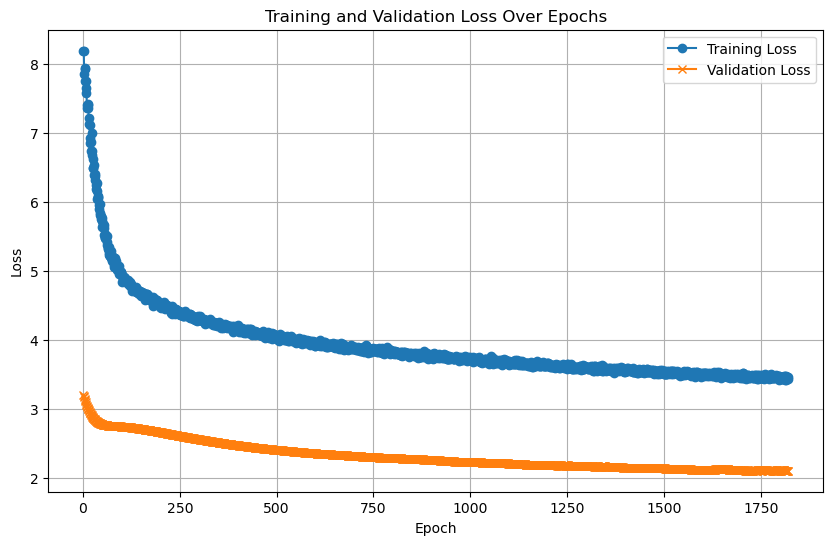

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/210], Loss: 4.4395
Test Batch [20/210], Loss: 4.5380
Test Batch [30/210], Loss: 4.6597
Test Batch [40/210], Loss: 4.9084
Test Batch [50/210], Loss: 6.0232
Test Batch [60/210], Loss: 5.2113


Test Batch [70/210], Loss: 4.8236
Test Batch [80/210], Loss: 5.0735
Test Batch [90/210], Loss: 4.6533
Test Batch [100/210], Loss: 4.6386
Test Batch [110/210], Loss: 4.7680
Test Batch [120/210], Loss: 4.9980
Test Batch [130/210], Loss: 4.8438
Test Batch [140/210], Loss: 4.8559
Test Batch [150/210], Loss: 4.7363


Test Batch [160/210], Loss: 5.0379
Test Batch [170/210], Loss: 4.9126
Test Batch [180/210], Loss: 5.0055
Test Batch [190/210], Loss: 4.6606
Test Batch [200/210], Loss: 5.0185
Test Batch [210/210], Loss: 4.4365

Test Loss: 4.8668


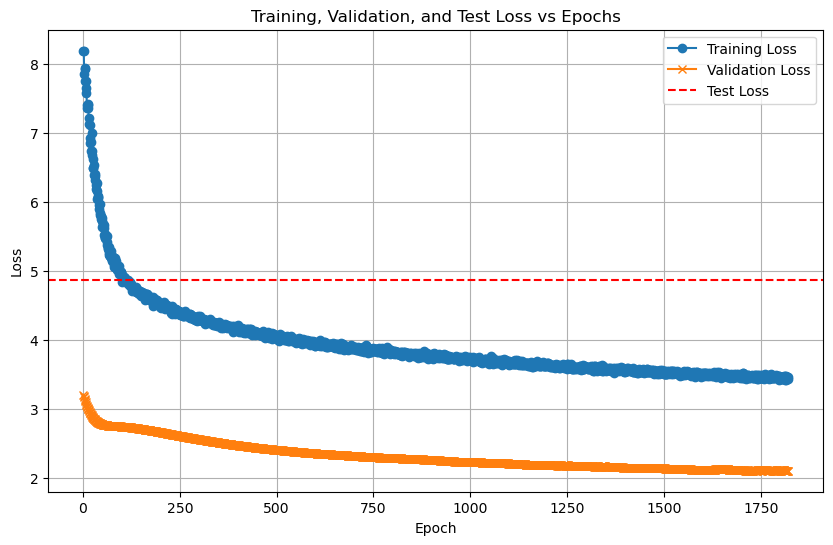

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/210 for test dataset.
  Processed batch 20/210 for test dataset.
  Processed batch 30/210 for test dataset.
  Processed batch 40/210 for test dataset.
  Processed batch 50/210 for test dataset.


  Processed batch 60/210 for test dataset.
  Processed batch 70/210 for test dataset.


  Processed batch 80/210 for test dataset.
  Processed batch 90/210 for test dataset.
  Processed batch 100/210 for test dataset.
  Processed batch 110/210 for test dataset.
  Processed batch 120/210 for test dataset.


  Processed batch 130/210 for test dataset.
  Processed batch 140/210 for test dataset.


  Processed batch 150/210 for test dataset.
  Processed batch 160/210 for test dataset.
  Processed batch 170/210 for test dataset.
  Processed batch 180/210 for test dataset.
  Processed batch 190/210 for test dataset.


  Processed batch 200/210 for test dataset.
  Processed batch 210/210 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7841  |  Val Loss: 2.7590
Validation loss improved from inf to 2.7590.
[Epoch 2/1000] Train Loss: 2.7424  |  Val Loss: 2.7208
Validation loss improved from 2.7590 to 2.7208.
[Epoch 3/1000] Train Loss: 2.7059  |  Val Loss: 2.6840
Validation loss improved from 2.7208 to 2.6840.
[Epoch 4/1000] Train Loss: 2.6707  |  Val Loss: 2.6511
Validation loss improved from 2.6840 to 2.6511.
[Epoch 5/1000] Train Loss: 2.6373  |  Val Loss: 2.6196
Validation loss improved from 2.6511 to 2.6196.
[Epoch 6/1000] Train Loss: 2.6071  |  Val Loss: 2.5892
Validation loss improved from 2.6196 to 2.5892.
[Epoch 7/1000] Train Loss: 2.5779  |  Val Loss: 2.5606
Validation loss improved from 2.5892 to 2.5606.
[Epoch 8/1000] Train Loss: 2.5497  |  Val Loss: 2.5305
Validation loss improved from 2.5606 to 2.5305.
[Epoch 9/1000] Train Loss: 2.5202  |  Val Loss: 2.5017
Validation loss improved from 2.5305 to 2.5017.
[Epoch 10/1000] Train Loss: 2.4930  |  Val Loss: 2.4745
Validation loss impr

[Epoch 18/1000] Train Loss: 2.2944  |  Val Loss: 2.2776
Validation loss improved from 2.3010 to 2.2776.
[Epoch 19/1000] Train Loss: 2.2708  |  Val Loss: 2.2553
Validation loss improved from 2.2776 to 2.2553.
[Epoch 20/1000] Train Loss: 2.2480  |  Val Loss: 2.2331
Validation loss improved from 2.2553 to 2.2331.
[Epoch 21/1000] Train Loss: 2.2254  |  Val Loss: 2.2110
Validation loss improved from 2.2331 to 2.2110.
[Epoch 22/1000] Train Loss: 2.2034  |  Val Loss: 2.1887
Validation loss improved from 2.2110 to 2.1887.
[Epoch 23/1000] Train Loss: 2.1809  |  Val Loss: 2.1669
Validation loss improved from 2.1887 to 2.1669.
[Epoch 24/1000] Train Loss: 2.1585  |  Val Loss: 2.1456
Validation loss improved from 2.1669 to 2.1456.
[Epoch 25/1000] Train Loss: 2.1365  |  Val Loss: 2.1242
Validation loss improved from 2.1456 to 2.1242.
[Epoch 26/1000] Train Loss: 2.1154  |  Val Loss: 2.1027
Validation loss improved from 2.1242 to 2.1027.
[Epoch 27/1000] Train Loss: 2.0934  |  Val Loss: 2.0813
Validati

[Epoch 38/1000] Train Loss: 1.8534  |  Val Loss: 1.8512
Validation loss improved from 1.8715 to 1.8512.
[Epoch 39/1000] Train Loss: 1.8324  |  Val Loss: 1.8306
Validation loss improved from 1.8512 to 1.8306.
[Epoch 40/1000] Train Loss: 1.8110  |  Val Loss: 1.8105
Validation loss improved from 1.8306 to 1.8105.
[Epoch 41/1000] Train Loss: 1.7892  |  Val Loss: 1.7906
Validation loss improved from 1.8105 to 1.7906.
[Epoch 42/1000] Train Loss: 1.7687  |  Val Loss: 1.7708
Validation loss improved from 1.7906 to 1.7708.
[Epoch 43/1000] Train Loss: 1.7474  |  Val Loss: 1.7511
Validation loss improved from 1.7708 to 1.7511.
[Epoch 44/1000] Train Loss: 1.7263  |  Val Loss: 1.7317
Validation loss improved from 1.7511 to 1.7317.
[Epoch 45/1000] Train Loss: 1.7052  |  Val Loss: 1.7120
Validation loss improved from 1.7317 to 1.7120.
[Epoch 46/1000] Train Loss: 1.6845  |  Val Loss: 1.6927
Validation loss improved from 1.7120 to 1.6927.
[Epoch 47/1000] Train Loss: 1.6634  |  Val Loss: 1.6733
Validati

[Epoch 57/1000] Train Loss: 1.4633  |  Val Loss: 1.4903
Validation loss improved from 1.5077 to 1.4903.
[Epoch 58/1000] Train Loss: 1.4443  |  Val Loss: 1.4734
Validation loss improved from 1.4903 to 1.4734.
[Epoch 59/1000] Train Loss: 1.4253  |  Val Loss: 1.4568
Validation loss improved from 1.4734 to 1.4568.
[Epoch 60/1000] Train Loss: 1.4072  |  Val Loss: 1.4404
Validation loss improved from 1.4568 to 1.4404.
[Epoch 61/1000] Train Loss: 1.3892  |  Val Loss: 1.4246
Validation loss improved from 1.4404 to 1.4246.
[Epoch 62/1000] Train Loss: 1.3713  |  Val Loss: 1.4091
Validation loss improved from 1.4246 to 1.4091.
[Epoch 63/1000] Train Loss: 1.3537  |  Val Loss: 1.3932
Validation loss improved from 1.4091 to 1.3932.
[Epoch 64/1000] Train Loss: 1.3364  |  Val Loss: 1.3780
Validation loss improved from 1.3932 to 1.3780.
[Epoch 65/1000] Train Loss: 1.3199  |  Val Loss: 1.3633
Validation loss improved from 1.3780 to 1.3633.
[Epoch 66/1000] Train Loss: 1.3023  |  Val Loss: 1.3487
Validati

[Epoch 76/1000] Train Loss: 1.1512  |  Val Loss: 1.2156
Validation loss improved from 1.2279 to 1.2156.
[Epoch 77/1000] Train Loss: 1.1374  |  Val Loss: 1.2028
Validation loss improved from 1.2156 to 1.2028.
[Epoch 78/1000] Train Loss: 1.1237  |  Val Loss: 1.1906
Validation loss improved from 1.2028 to 1.1906.
[Epoch 79/1000] Train Loss: 1.1101  |  Val Loss: 1.1783
Validation loss improved from 1.1906 to 1.1783.
[Epoch 80/1000] Train Loss: 1.0966  |  Val Loss: 1.1663
Validation loss improved from 1.1783 to 1.1663.
[Epoch 81/1000] Train Loss: 1.0836  |  Val Loss: 1.1547
Validation loss improved from 1.1663 to 1.1547.
[Epoch 82/1000] Train Loss: 1.0702  |  Val Loss: 1.1430
Validation loss improved from 1.1547 to 1.1430.
[Epoch 83/1000] Train Loss: 1.0572  |  Val Loss: 1.1307
Validation loss improved from 1.1430 to 1.1307.
[Epoch 84/1000] Train Loss: 1.0443  |  Val Loss: 1.1189
Validation loss improved from 1.1307 to 1.1189.
[Epoch 85/1000] Train Loss: 1.0310  |  Val Loss: 1.1076
Validati

[Epoch 96/1000] Train Loss: 0.8900  |  Val Loss: 0.9796
Validation loss improved from 0.9912 to 0.9796.
[Epoch 97/1000] Train Loss: 0.8771  |  Val Loss: 0.9676
Validation loss improved from 0.9796 to 0.9676.
[Epoch 98/1000] Train Loss: 0.8643  |  Val Loss: 0.9552
Validation loss improved from 0.9676 to 0.9552.
[Epoch 99/1000] Train Loss: 0.8515  |  Val Loss: 0.9432
Validation loss improved from 0.9552 to 0.9432.
[Epoch 100/1000] Train Loss: 0.8392  |  Val Loss: 0.9312
Validation loss improved from 0.9432 to 0.9312.
[Epoch 101/1000] Train Loss: 0.8261  |  Val Loss: 0.9193
Validation loss improved from 0.9312 to 0.9193.
[Epoch 102/1000] Train Loss: 0.8134  |  Val Loss: 0.9083
Validation loss improved from 0.9193 to 0.9083.
[Epoch 103/1000] Train Loss: 0.8011  |  Val Loss: 0.8967
Validation loss improved from 0.9083 to 0.8967.
[Epoch 104/1000] Train Loss: 0.7886  |  Val Loss: 0.8849
Validation loss improved from 0.8967 to 0.8849.
[Epoch 105/1000] Train Loss: 0.7762  |  Val Loss: 0.8738
Va

[Epoch 117/1000] Train Loss: 0.6382  |  Val Loss: 0.7467
Validation loss improved from 0.7567 to 0.7467.
[Epoch 118/1000] Train Loss: 0.6275  |  Val Loss: 0.7365
Validation loss improved from 0.7467 to 0.7365.
[Epoch 119/1000] Train Loss: 0.6170  |  Val Loss: 0.7272
Validation loss improved from 0.7365 to 0.7272.
[Epoch 120/1000] Train Loss: 0.6068  |  Val Loss: 0.7172
Validation loss improved from 0.7272 to 0.7172.
[Epoch 121/1000] Train Loss: 0.5965  |  Val Loss: 0.7072
Validation loss improved from 0.7172 to 0.7072.
[Epoch 122/1000] Train Loss: 0.5863  |  Val Loss: 0.6973
Validation loss improved from 0.7072 to 0.6973.
[Epoch 123/1000] Train Loss: 0.5762  |  Val Loss: 0.6879
Validation loss improved from 0.6973 to 0.6879.
[Epoch 124/1000] Train Loss: 0.5669  |  Val Loss: 0.6792
Validation loss improved from 0.6879 to 0.6792.
[Epoch 125/1000] Train Loss: 0.5567  |  Val Loss: 0.6701
Validation loss improved from 0.6792 to 0.6701.
[Epoch 126/1000] Train Loss: 0.5474  |  Val Loss: 0.660

[Epoch 137/1000] Train Loss: 0.4514  |  Val Loss: 0.5708
Validation loss improved from 0.5789 to 0.5708.
[Epoch 138/1000] Train Loss: 0.4437  |  Val Loss: 0.5633
Validation loss improved from 0.5708 to 0.5633.
[Epoch 139/1000] Train Loss: 0.4367  |  Val Loss: 0.5552
Validation loss improved from 0.5633 to 0.5552.
[Epoch 140/1000] Train Loss: 0.4287  |  Val Loss: 0.5486
Validation loss improved from 0.5552 to 0.5486.
[Epoch 141/1000] Train Loss: 0.4215  |  Val Loss: 0.5421
Validation loss improved from 0.5486 to 0.5421.
[Epoch 142/1000] Train Loss: 0.4144  |  Val Loss: 0.5359
Validation loss improved from 0.5421 to 0.5359.
[Epoch 143/1000] Train Loss: 0.4076  |  Val Loss: 0.5292
Validation loss improved from 0.5359 to 0.5292.
[Epoch 144/1000] Train Loss: 0.4007  |  Val Loss: 0.5227
Validation loss improved from 0.5292 to 0.5227.
[Epoch 145/1000] Train Loss: 0.3938  |  Val Loss: 0.5166
Validation loss improved from 0.5227 to 0.5166.
[Epoch 146/1000] Train Loss: 0.3877  |  Val Loss: 0.511

[Epoch 156/1000] Train Loss: 0.3298  |  Val Loss: 0.4576
Validation loss improved from 0.4627 to 0.4576.
[Epoch 157/1000] Train Loss: 0.3243  |  Val Loss: 0.4530
Validation loss improved from 0.4576 to 0.4530.
[Epoch 158/1000] Train Loss: 0.3195  |  Val Loss: 0.4482
Validation loss improved from 0.4530 to 0.4482.
[Epoch 159/1000] Train Loss: 0.3148  |  Val Loss: 0.4436
Validation loss improved from 0.4482 to 0.4436.
[Epoch 160/1000] Train Loss: 0.3099  |  Val Loss: 0.4398
Validation loss improved from 0.4436 to 0.4398.
[Epoch 161/1000] Train Loss: 0.3056  |  Val Loss: 0.4361
Validation loss improved from 0.4398 to 0.4361.
[Epoch 162/1000] Train Loss: 0.3008  |  Val Loss: 0.4318
Validation loss improved from 0.4361 to 0.4318.
[Epoch 163/1000] Train Loss: 0.2964  |  Val Loss: 0.4273
Validation loss improved from 0.4318 to 0.4273.
[Epoch 164/1000] Train Loss: 0.2920  |  Val Loss: 0.4234
Validation loss improved from 0.4273 to 0.4234.
[Epoch 165/1000] Train Loss: 0.2880  |  Val Loss: 0.420

[Epoch 174/1000] Train Loss: 0.2542  |  Val Loss: 0.3901
Validation loss improved from 0.3925 to 0.3901.
[Epoch 175/1000] Train Loss: 0.2510  |  Val Loss: 0.3877
Validation loss improved from 0.3901 to 0.3877.
[Epoch 176/1000] Train Loss: 0.2479  |  Val Loss: 0.3843
Validation loss improved from 0.3877 to 0.3843.
[Epoch 177/1000] Train Loss: 0.2444  |  Val Loss: 0.3817
Validation loss improved from 0.3843 to 0.3817.
[Epoch 178/1000] Train Loss: 0.2413  |  Val Loss: 0.3794
Validation loss improved from 0.3817 to 0.3794.
[Epoch 179/1000] Train Loss: 0.2382  |  Val Loss: 0.3765
Validation loss improved from 0.3794 to 0.3765.
[Epoch 180/1000] Train Loss: 0.2354  |  Val Loss: 0.3740
Validation loss improved from 0.3765 to 0.3740.
[Epoch 181/1000] Train Loss: 0.2329  |  Val Loss: 0.3703
Validation loss improved from 0.3740 to 0.3703.
[Epoch 182/1000] Train Loss: 0.2298  |  Val Loss: 0.3689
Validation loss improved from 0.3703 to 0.3689.
[Epoch 183/1000] Train Loss: 0.2268  |  Val Loss: 0.366

[Epoch 194/1000] Train Loss: 0.2000  |  Val Loss: 0.3441
Validation loss improved from 0.3463 to 0.3441.
[Epoch 195/1000] Train Loss: 0.1980  |  Val Loss: 0.3416
Validation loss improved from 0.3441 to 0.3416.
[Epoch 196/1000] Train Loss: 0.1962  |  Val Loss: 0.3395
Validation loss improved from 0.3416 to 0.3395.
[Epoch 197/1000] Train Loss: 0.1940  |  Val Loss: 0.3378
Validation loss improved from 0.3395 to 0.3378.
[Epoch 198/1000] Train Loss: 0.1919  |  Val Loss: 0.3363
Validation loss improved from 0.3378 to 0.3363.
[Epoch 199/1000] Train Loss: 0.1899  |  Val Loss: 0.3354
Validation loss improved from 0.3363 to 0.3354.
[Epoch 200/1000] Train Loss: 0.1883  |  Val Loss: 0.3333
Validation loss improved from 0.3354 to 0.3333.
[Epoch 201/1000] Train Loss: 0.1865  |  Val Loss: 0.3340
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 202/1000] Train Loss: 0.1850  |  Val Loss: 0.3308
Validation loss improved from 0.3333 to 0.3308.
[Epoch 203/1000] Train Loss: 0.1828  |  Val Loss:

[Epoch 213/1000] Train Loss: 0.1670  |  Val Loss: 0.3152
Validation loss improved from 0.3168 to 0.3152.
[Epoch 214/1000] Train Loss: 0.1654  |  Val Loss: 0.3165
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 215/1000] Train Loss: 0.1642  |  Val Loss: 0.3156
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 216/1000] Train Loss: 0.1626  |  Val Loss: 0.3152
Validation loss improved from 0.3152 to 0.3152.
[Epoch 217/1000] Train Loss: 0.1616  |  Val Loss: 0.3134
Validation loss improved from 0.3152 to 0.3134.
[Epoch 218/1000] Train Loss: 0.1602  |  Val Loss: 0.3115
Validation loss improved from 0.3134 to 0.3115.
[Epoch 219/1000] Train Loss: 0.1586  |  Val Loss: 0.3112
Validation loss improved from 0.3115 to 0.3112.
[Epoch 220/1000] Train Loss: 0.1576  |  Val Loss: 0.3116
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 221/1000] Train Loss: 0.1563  |  Val Loss: 0.3112
Validation loss improved from 0.3112 to 0.3112.
[Epoch 222/1000] Train Loss: 0.1552  

[Epoch 232/1000] Train Loss: 0.1441  |  Val Loss: 0.3024
Validation loss improved from 0.3030 to 0.3024.
[Epoch 233/1000] Train Loss: 0.1431  |  Val Loss: 0.3024
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 234/1000] Train Loss: 0.1423  |  Val Loss: 0.3006
Validation loss improved from 0.3024 to 0.3006.
[Epoch 235/1000] Train Loss: 0.1413  |  Val Loss: 0.3007
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 236/1000] Train Loss: 0.1404  |  Val Loss: 0.2985
Validation loss improved from 0.3006 to 0.2985.
[Epoch 237/1000] Train Loss: 0.1397  |  Val Loss: 0.2994
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 238/1000] Train Loss: 0.1385  |  Val Loss: 0.2992
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 239/1000] Train Loss: 0.1379  |  Val Loss: 0.2994
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 240/1000] Train Loss: 0.1368  |  Val Loss: 0.2961
Validation loss improved from 0.2985 to 0.2961.
[Epoch 241/1000] Train Lo

[Epoch 251/1000] Train Loss: 0.1281  |  Val Loss: 0.2935
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 252/1000] Train Loss: 0.1278  |  Val Loss: 0.2914
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 253/1000] Train Loss: 0.1268  |  Val Loss: 0.2928
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 254/1000] Train Loss: 0.1260  |  Val Loss: 0.2924
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 255/1000] Train Loss: 0.1253  |  Val Loss: 0.2915
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 256/1000] Train Loss: 0.1245  |  Val Loss: 0.2919
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 257/1000] Train Loss: 0.1241  |  Val Loss: 0.2932
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 258/1000] Train Loss: 0.1232  |  Val Loss: 0.2913
Validation loss improved from 0.2914 to 0.2913.
[Epoch 259/1000] Train Loss: 0.1225  |  Val Loss: 0.2900
Validation loss improved from 0.2913 to 0.2900.
[Epoch 260/10

[Epoch 270/1000] Train Loss: 0.1161  |  Val Loss: 0.2886
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 271/1000] Train Loss: 0.1156  |  Val Loss: 0.2893
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 272/1000] Train Loss: 0.1150  |  Val Loss: 0.2883
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 273/1000] Train Loss: 0.1147  |  Val Loss: 0.2865
Validation loss improved from 0.2873 to 0.2865.
[Epoch 274/1000] Train Loss: 0.1141  |  Val Loss: 0.2855
Validation loss improved from 0.2865 to 0.2855.
[Epoch 275/1000] Train Loss: 0.1138  |  Val Loss: 0.2884
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 276/1000] Train Loss: 0.1130  |  Val Loss: 0.2890
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 277/1000] Train Loss: 0.1125  |  Val Loss: 0.2876
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 278/1000] Train Loss: 0.1120  |  Val Loss: 0.2875
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 279/10

[Epoch 291/1000] Train Loss: 0.1061  |  Val Loss: 0.2856
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 292/1000] Train Loss: 0.1056  |  Val Loss: 0.2856
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 293/1000] Train Loss: 0.1052  |  Val Loss: 0.2866
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 294/1000] Train Loss: 0.1051  |  Val Loss: 0.2884
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 295/1000] Train Loss: 0.1045  |  Val Loss: 0.2872
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 296/1000] Train Loss: 0.1040  |  Val Loss: 0.2861
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 297/1000] Train Loss: 0.1036  |  Val Loss: 0.2859
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 298/1000] Train Loss: 0.1033  |  Val Loss: 0.2845
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 299/1000] Train Loss: 0.1029  |  Val Loss: 0.2846
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 310/1000] Train Loss: 0.0990  |  Val Loss: 0.2865
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 311/1000] Train Loss: 0.0986  |  Val Loss: 0.2870
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 312/1000] Train Loss: 0.0983  |  Val Loss: 0.2866
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 313/1000] Train Loss: 0.0979  |  Val Loss: 0.2859
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 314/1000] Train Loss: 0.0982  |  Val Loss: 0.2880
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 315/1000] Train Loss: 0.0977  |  Val Loss: 0.2845
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 316/1000] Train Loss: 0.0970  |  Val Loss: 0.2855
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 317/1000] Train Loss: 0.0970  |  Val Loss: 0.2871
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 318/1000] Train Loss: 0.0963  |  Val Loss: 0.2857
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 328/1000] Train Loss: 0.0934  |  Val Loss: 0.2858
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 329/1000] Train Loss: 0.0930  |  Val Loss: 0.2860
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 330/1000] Train Loss: 0.0930  |  Val Loss: 0.2881
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 331/1000] Train Loss: 0.0927  |  Val Loss: 0.2855
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 332/1000] Train Loss: 0.0923  |  Val Loss: 0.2849
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 333/1000] Train Loss: 0.0920  |  Val Loss: 0.2859
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 334/1000] Train Loss: 0.0920  |  Val Loss: 0.2848
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 335/1000] Train Loss: 0.0914  |  Val Loss: 0.2865
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 336/1000] Train Loss: 0.0911  |  Val Loss: 0.2869
!! Validation loss did NOT improve !! Patience:

[Epoch 348/1000] Train Loss: 0.0882  |  Val Loss: 0.2886
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 349/1000] Train Loss: 0.0884  |  Val Loss: 0.2904
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 350/1000] Train Loss: 0.0876  |  Val Loss: 0.2878
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 351/1000] Train Loss: 0.0877  |  Val Loss: 0.2853
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 352/1000] Train Loss: 0.0872  |  Val Loss: 0.2859
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 353/1000] Train Loss: 0.0877  |  Val Loss: 0.2900
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 354/1000] Train Loss: 0.0869  |  Val Loss: 0.2911
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 355/1000] Train Loss: 0.0867  |  Val Loss: 0.2889
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 356/1000] Train Loss: 0.0863  |  Val Loss: 0.2879
!! Validation loss did NOT improve !! Patience:

[Epoch 367/1000] Train Loss: 0.0839  |  Val Loss: 0.2901
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 368/1000] Train Loss: 0.0837  |  Val Loss: 0.2919
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 369/1000] Train Loss: 0.0835  |  Val Loss: 0.2915
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 370/1000] Train Loss: 0.0833  |  Val Loss: 0.2910
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 371/1000] Train Loss: 0.0831  |  Val Loss: 0.2918
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 372/1000] Train Loss: 0.0830  |  Val Loss: 0.2918
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 373/1000] Train Loss: 0.0828  |  Val Loss: 0.2901
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 374/1000] Train Loss: 0.0826  |  Val Loss: 0.2927
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 375/1000] Train Loss: 0.0827  |  Val Loss: 0.2907
!! Validation loss did NOT improve !! Patience:

[Epoch 387/1000] Train Loss: 0.0800  |  Val Loss: 0.2937
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 388/1000] Train Loss: 0.0797  |  Val Loss: 0.2947
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 389/1000] Train Loss: 0.0796  |  Val Loss: 0.2935
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 390/1000] Train Loss: 0.0794  |  Val Loss: 0.2959
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 391/1000] Train Loss: 0.0793  |  Val Loss: 0.2943
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 392/1000] Train Loss: 0.0790  |  Val Loss: 0.2949
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 393/1000] Train Loss: 0.0789  |  Val Loss: 0.2943
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 394/1000] Train Loss: 0.0787  |  Val Loss: 0.2951
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 395/1000] Train Loss: 0.0788  |  Val Loss: 0.2941
!! Validation loss did NOT improve !! Patience:

[Epoch 408/1000] Train Loss: 0.0763  |  Val Loss: 0.2960
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 408 !!
No improvement for 100 epochs.


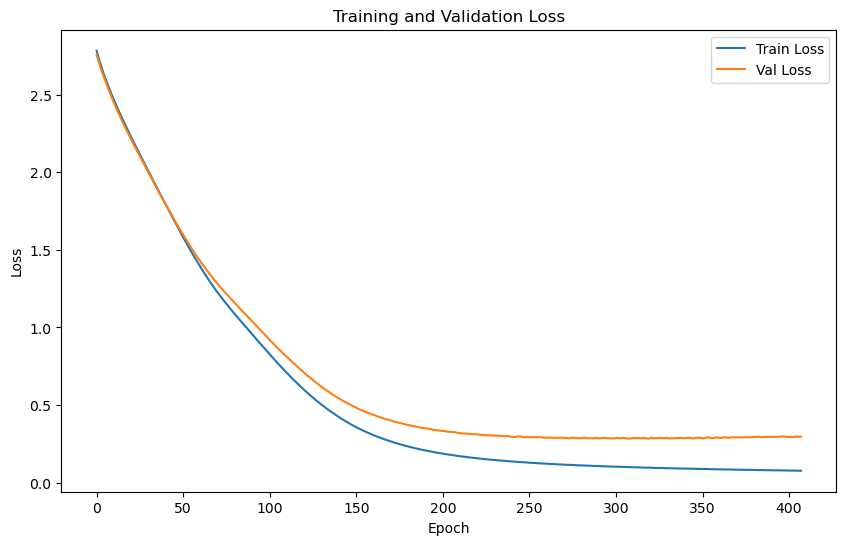

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.5291 | Test Accuracy: 83.97%


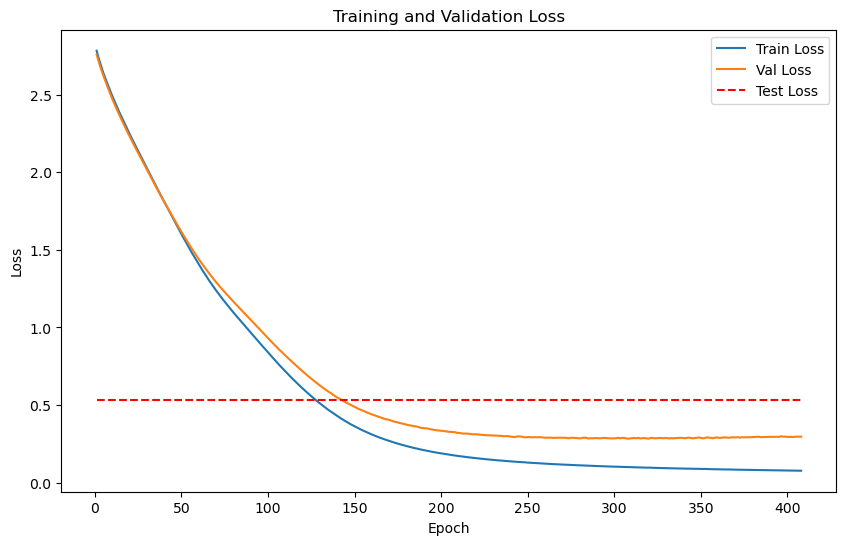

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 320 samples with 64 features each
LOG: Labels shape: (320,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 53729 samples with 64 features each
LOG: Labels shape: (53729,)


Train embeddings shape: (320, 64), 
Train labels shape: (320,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (53729, 64), 
Test labels shape: (53729,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20, 14: 20, 15: 20}
Training batch size: 320


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.3300
    Batch [2/2], Val Loss: 0.4503
Epoch [1/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.3902

Validation loss improved from inf to 0.3902. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.3308
    Batch [2/2], Val Loss: 0.4461
Epoch [2/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.3884

Validation loss improved from 0.3902 to 0.3884. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4584
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.3311
    Batch [2/2], Val Loss: 0.4422
Epoch [3/2000], Avg Train Loss: 0.4584, Avg Val Loss: 0.3867

Validation loss improved from 0.3884 to 0.3867. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4571
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.3311
    Batch [2/2], Val Loss: 0.4398
Epoch [4/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.3854

Validation loss improved from 0.3867 to 0.3854. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.3315
    Batch [2/2], Val Loss: 0.4381
Epoch [5/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.3848

Validation loss improved from 0.3854 to 0.3848. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.3313
    Batch [2/2], Val Loss: 0.4364
Epoch [6/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.3839

Validation loss improved from 0.3848 to 0.3839. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4549
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.3309
    Batch [2/2], Val Loss: 0.4351
Epoch [7/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.3830

Validation loss improved from 0.3839 to 0.3830. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.3307
    Batch [2/2], Val Loss: 0.4333
Epoch [8/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.3820

Validation loss improved from 0.3830 to 0.3820. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4535
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.3304
    Batch [2/2], Val Loss: 0.4314
Epoch [9/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.3809

Validation loss improved from 0.3820 to 0.3809. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.3303
    Batch [2/2], Val Loss: 0.4294
Epoch [10/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.3798

Validation loss improved from 0.3809 to 0.3798. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.3298
    Batch [2/2], Val Loss: 0.4273
Epoch [11/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.3785

Validation loss improved from 0.3798 to 0.3785. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.3290
    Batch [2/2], Val Loss: 0.4252
Epoch [12/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.3771

Validation loss improved from 0.3785 to 0.3771. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.3285
    Batch [2/2], Val Loss: 0.4235
Epoch [13/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.3760

Validation loss improved from 0.3771 to 0.3760. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.3276
    Batch [2/2], Val Loss: 0.4228
Epoch [14/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.3752

Validation loss improved from 0.3760 to 0.3752. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4514
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.3260
    Batch [2/2], Val Loss: 0.4222
Epoch [15/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.3741

Validation loss improved from 0.3752 to 0.3741. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.3243
    Batch [2/2], Val Loss: 0.4214
Epoch [16/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.3728

Validation loss improved from 0.3741 to 0.3728. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.3225
    Batch [2/2], Val Loss: 0.4206
Epoch [17/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.3715

Validation loss improved from 0.3728 to 0.3715. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.3206
    Batch [2/2], Val Loss: 0.4200
Epoch [18/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.3703

Validation loss improved from 0.3715 to 0.3703. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.3185
    Batch [2/2], Val Loss: 0.4191
Epoch [19/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.3688

Validation loss improved from 0.3703 to 0.3688. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.3164
    Batch [2/2], Val Loss: 0.4180
Epoch [20/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.3672

Validation loss improved from 0.3688 to 0.3672. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.3145
    Batch [2/2], Val Loss: 0.4168
Epoch [21/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3657

Validation loss improved from 0.3672 to 0.3657. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.3127
    Batch [2/2], Val Loss: 0.4160
Epoch [22/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3643

Validation loss improved from 0.3657 to 0.3643. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.3109
    Batch [2/2], Val Loss: 0.4153
Epoch [23/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3631

Validation loss improved from 0.3643 to 0.3631. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.3091
    Batch [2/2], Val Loss: 0.4147
Epoch [24/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.3619

Validation loss improved from 0.3631 to 0.3619. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.3072
    Batch [2/2], Val Loss: 0.4139
Epoch [25/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3606

Validation loss improved from 0.3619 to 0.3606. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.3055
    Batch [2/2], Val Loss: 0.4132
Epoch [26/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.3593

Validation loss improved from 0.3606 to 0.3593. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.3038
    Batch [2/2], Val Loss: 0.4126
Epoch [27/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3582

Validation loss improved from 0.3593 to 0.3582. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.3021
    Batch [2/2], Val Loss: 0.4120
Epoch [28/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3571

Validation loss improved from 0.3582 to 0.3571. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.3006
    Batch [2/2], Val Loss: 0.4115
Epoch [29/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.3560

Validation loss improved from 0.3571 to 0.3560. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.2991
    Batch [2/2], Val Loss: 0.4108
Epoch [30/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.3550

Validation loss improved from 0.3560 to 0.3550. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.2977
    Batch [2/2], Val Loss: 0.4102
Epoch [31/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.3540

Validation loss improved from 0.3550 to 0.3540. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.2963
    Batch [2/2], Val Loss: 0.4096
Epoch [32/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.3530

Validation loss improved from 0.3540 to 0.3530. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.2950
    Batch [2/2], Val Loss: 0.4090
Epoch [33/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.3520

Validation loss improved from 0.3530 to 0.3520. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.2938
    Batch [2/2], Val Loss: 0.4084
Epoch [34/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.3511

Validation loss improved from 0.3520 to 0.3511. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.2926
    Batch [2/2], Val Loss: 0.4078
Epoch [35/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.3502

Validation loss improved from 0.3511 to 0.3502. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.2915
    Batch [2/2], Val Loss: 0.4071
Epoch [36/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.3493

Validation loss improved from 0.3502 to 0.3493. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.2904
    Batch [2/2], Val Loss: 0.4064
Epoch [37/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.3484

Validation loss improved from 0.3493 to 0.3484. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.2893
    Batch [2/2], Val Loss: 0.4058
Epoch [38/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.3475

Validation loss improved from 0.3484 to 0.3475. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.2882
    Batch [2/2], Val Loss: 0.4052
Epoch [39/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.3467

Validation loss improved from 0.3475 to 0.3467. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.2872
    Batch [2/2], Val Loss: 0.4046
Epoch [40/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.3459

Validation loss improved from 0.3467 to 0.3459. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.2863
    Batch [2/2], Val Loss: 0.4039
Epoch [41/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.3451

Validation loss improved from 0.3459 to 0.3451. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.2853
    Batch [2/2], Val Loss: 0.4033
Epoch [42/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.3443

Validation loss improved from 0.3451 to 0.3443. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.2843
    Batch [2/2], Val Loss: 0.4027
Epoch [43/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.3435

Validation loss improved from 0.3443 to 0.3435. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.2834
    Batch [2/2], Val Loss: 0.4022
Epoch [44/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.3428

Validation loss improved from 0.3435 to 0.3428. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.2824
    Batch [2/2], Val Loss: 0.4016
Epoch [45/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.3420

Validation loss improved from 0.3428 to 0.3420. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.2815
    Batch [2/2], Val Loss: 0.4011
Epoch [46/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.3413

Validation loss improved from 0.3420 to 0.3413. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.2806
    Batch [2/2], Val Loss: 0.4005
Epoch [47/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.3406

Validation loss improved from 0.3413 to 0.3406. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4234
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.2798
    Batch [2/2], Val Loss: 0.4000
Epoch [48/2000], Avg Train Loss: 0.4234, Avg Val Loss: 0.3399

Validation loss improved from 0.3406 to 0.3399. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.2789
    Batch [2/2], Val Loss: 0.3994
Epoch [49/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.3392

Validation loss improved from 0.3399 to 0.3392. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.2781
    Batch [2/2], Val Loss: 0.3988
Epoch [50/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.3385

Validation loss improved from 0.3392 to 0.3385. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.2773
    Batch [2/2], Val Loss: 0.3983
Epoch [51/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.3378

Validation loss improved from 0.3385 to 0.3378. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.2765
    Batch [2/2], Val Loss: 0.3977
Epoch [52/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.3371

Validation loss improved from 0.3378 to 0.3371. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.2757
    Batch [2/2], Val Loss: 0.3972
Epoch [53/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.3364

Validation loss improved from 0.3371 to 0.3364. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.2748
    Batch [2/2], Val Loss: 0.3967
Epoch [54/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.3358

Validation loss improved from 0.3364 to 0.3358. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.2740
    Batch [2/2], Val Loss: 0.3963
Epoch [55/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.3352

Validation loss improved from 0.3358 to 0.3352. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.2732
    Batch [2/2], Val Loss: 0.3959
Epoch [56/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.3345

Validation loss improved from 0.3352 to 0.3345. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.2724
    Batch [2/2], Val Loss: 0.3955
Epoch [57/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.3339

Validation loss improved from 0.3345 to 0.3339. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.2716
    Batch [2/2], Val Loss: 0.3950
Epoch [58/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.3333

Validation loss improved from 0.3339 to 0.3333. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.2708
    Batch [2/2], Val Loss: 0.3946
Epoch [59/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.3327

Validation loss improved from 0.3333 to 0.3327. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.2700
    Batch [2/2], Val Loss: 0.3941
Epoch [60/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.3321

Validation loss improved from 0.3327 to 0.3321. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.2693
    Batch [2/2], Val Loss: 0.3936
Epoch [61/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.3315

Validation loss improved from 0.3321 to 0.3315. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.2685
    Batch [2/2], Val Loss: 0.3931
Epoch [62/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3308

Validation loss improved from 0.3315 to 0.3308. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.2678
    Batch [2/2], Val Loss: 0.3926
Epoch [63/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3302

Validation loss improved from 0.3308 to 0.3302. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.2671
    Batch [2/2], Val Loss: 0.3921
Epoch [64/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.3296

Validation loss improved from 0.3302 to 0.3296. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.2663
    Batch [2/2], Val Loss: 0.3916
Epoch [65/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.3290

Validation loss improved from 0.3296 to 0.3290. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.2656
    Batch [2/2], Val Loss: 0.3911
Epoch [66/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.3283

Validation loss improved from 0.3290 to 0.3283. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.2649
    Batch [2/2], Val Loss: 0.3906
Epoch [67/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.3278

Validation loss improved from 0.3283 to 0.3278. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.2642
    Batch [2/2], Val Loss: 0.3902
Epoch [68/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.3272

Validation loss improved from 0.3278 to 0.3272. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.2635
    Batch [2/2], Val Loss: 0.3897
Epoch [69/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.3266

Validation loss improved from 0.3272 to 0.3266. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.2628
    Batch [2/2], Val Loss: 0.3892
Epoch [70/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.3260

Validation loss improved from 0.3266 to 0.3260. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.2622
    Batch [2/2], Val Loss: 0.3887
Epoch [71/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.3255

Validation loss improved from 0.3260 to 0.3255. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.2616
    Batch [2/2], Val Loss: 0.3882
Epoch [72/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.3249

Validation loss improved from 0.3255 to 0.3249. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.2610
    Batch [2/2], Val Loss: 0.3877
Epoch [73/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.3244

Validation loss improved from 0.3249 to 0.3244. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.2604
    Batch [2/2], Val Loss: 0.3873
Epoch [74/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.3238

Validation loss improved from 0.3244 to 0.3238. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.2598
    Batch [2/2], Val Loss: 0.3868
Epoch [75/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.3233

Validation loss improved from 0.3238 to 0.3233. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.2592
    Batch [2/2], Val Loss: 0.3863
Epoch [76/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.3228

Validation loss improved from 0.3233 to 0.3228. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.2586
    Batch [2/2], Val Loss: 0.3859
Epoch [77/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.3223

Validation loss improved from 0.3228 to 0.3223. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.2581
    Batch [2/2], Val Loss: 0.3855
Epoch [78/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.3218

Validation loss improved from 0.3223 to 0.3218. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.2575
    Batch [2/2], Val Loss: 0.3852
Epoch [79/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.3213

Validation loss improved from 0.3218 to 0.3213. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.2570
    Batch [2/2], Val Loss: 0.3848
Epoch [80/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.3209

Validation loss improved from 0.3213 to 0.3209. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.2565
    Batch [2/2], Val Loss: 0.3844
Epoch [81/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.3204

Validation loss improved from 0.3209 to 0.3204. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.2559
    Batch [2/2], Val Loss: 0.3841
Epoch [82/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.3200

Validation loss improved from 0.3204 to 0.3200. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4032
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.2554
    Batch [2/2], Val Loss: 0.3838
Epoch [83/2000], Avg Train Loss: 0.4032, Avg Val Loss: 0.3196

Validation loss improved from 0.3200 to 0.3196. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.2549
    Batch [2/2], Val Loss: 0.3835
Epoch [84/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.3192

Validation loss improved from 0.3196 to 0.3192. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.2545
    Batch [2/2], Val Loss: 0.3832
Epoch [85/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3188

Validation loss improved from 0.3192 to 0.3188. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.2540
    Batch [2/2], Val Loss: 0.3829
Epoch [86/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3184

Validation loss improved from 0.3188 to 0.3184. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.2535
    Batch [2/2], Val Loss: 0.3826
Epoch [87/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3180

Validation loss improved from 0.3184 to 0.3180. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.2530
    Batch [2/2], Val Loss: 0.3822
Epoch [88/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.3176

Validation loss improved from 0.3180 to 0.3176. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.2525
    Batch [2/2], Val Loss: 0.3819
Epoch [89/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.3172

Validation loss improved from 0.3176 to 0.3172. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.2521
    Batch [2/2], Val Loss: 0.3815
Epoch [90/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.3168

Validation loss improved from 0.3172 to 0.3168. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.2516
    Batch [2/2], Val Loss: 0.3811
Epoch [91/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3164

Validation loss improved from 0.3168 to 0.3164. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.2511
    Batch [2/2], Val Loss: 0.3807
Epoch [92/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.3159

Validation loss improved from 0.3164 to 0.3159. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.2506
    Batch [2/2], Val Loss: 0.3804
Epoch [93/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3155

Validation loss improved from 0.3159 to 0.3155. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.2501
    Batch [2/2], Val Loss: 0.3800
Epoch [94/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3151

Validation loss improved from 0.3155 to 0.3151. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.2497
    Batch [2/2], Val Loss: 0.3796
Epoch [95/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3147

Validation loss improved from 0.3151 to 0.3147. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.2492
    Batch [2/2], Val Loss: 0.3792
Epoch [96/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.3142

Validation loss improved from 0.3147 to 0.3142. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.2488
    Batch [2/2], Val Loss: 0.3788
Epoch [97/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3138

Validation loss improved from 0.3142 to 0.3138. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.2483
    Batch [2/2], Val Loss: 0.3785
Epoch [98/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3134

Validation loss improved from 0.3138 to 0.3134. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.2478
    Batch [2/2], Val Loss: 0.3780
Epoch [99/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.3129

Validation loss improved from 0.3134 to 0.3129. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.2473
    Batch [2/2], Val Loss: 0.3776
Epoch [100/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3125

Validation loss improved from 0.3129 to 0.3125. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.2468
    Batch [2/2], Val Loss: 0.3772
Epoch [101/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.3120

Validation loss improved from 0.3125 to 0.3120. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.2463
    Batch [2/2], Val Loss: 0.3768
Epoch [102/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3116

Validation loss improved from 0.3120 to 0.3116. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.2458
    Batch [2/2], Val Loss: 0.3765
Epoch [103/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3111

Validation loss improved from 0.3116 to 0.3111. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.2453
    Batch [2/2], Val Loss: 0.3761
Epoch [104/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3107

Validation loss improved from 0.3111 to 0.3107. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.2448
    Batch [2/2], Val Loss: 0.3758
Epoch [105/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.3103

Validation loss improved from 0.3107 to 0.3103. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.2443
    Batch [2/2], Val Loss: 0.3755
Epoch [106/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3099

Validation loss improved from 0.3103 to 0.3099. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.2439
    Batch [2/2], Val Loss: 0.3753
Epoch [107/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3096

Validation loss improved from 0.3099 to 0.3096. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.2434
    Batch [2/2], Val Loss: 0.3750
Epoch [108/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.3092

Validation loss improved from 0.3096 to 0.3092. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.2430
    Batch [2/2], Val Loss: 0.3748
Epoch [109/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.3089

Validation loss improved from 0.3092 to 0.3089. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.2425
    Batch [2/2], Val Loss: 0.3745
Epoch [110/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.3085

Validation loss improved from 0.3089 to 0.3085. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.2421
    Batch [2/2], Val Loss: 0.3743
Epoch [111/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3082

Validation loss improved from 0.3085 to 0.3082. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.2417
    Batch [2/2], Val Loss: 0.3740
Epoch [112/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.3078

Validation loss improved from 0.3082 to 0.3078. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.2413
    Batch [2/2], Val Loss: 0.3737
Epoch [113/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.3075

Validation loss improved from 0.3078 to 0.3075. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.2409
    Batch [2/2], Val Loss: 0.3734
Epoch [114/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.3071

Validation loss improved from 0.3075 to 0.3071. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.2405
    Batch [2/2], Val Loss: 0.3731
Epoch [115/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3068

Validation loss improved from 0.3071 to 0.3068. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.2401
    Batch [2/2], Val Loss: 0.3728
Epoch [116/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.3064

Validation loss improved from 0.3068 to 0.3064. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.3783
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.2396
    Batch [2/2], Val Loss: 0.3726
Epoch [117/2000], Avg Train Loss: 0.3783, Avg Val Loss: 0.3061

Validation loss improved from 0.3064 to 0.3061. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.2392
    Batch [2/2], Val Loss: 0.3723
Epoch [118/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.3058

Validation loss improved from 0.3061 to 0.3058. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.2388
    Batch [2/2], Val Loss: 0.3721
Epoch [119/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.3055

Validation loss improved from 0.3058 to 0.3055. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.2385
    Batch [2/2], Val Loss: 0.3718
Epoch [120/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.3052

Validation loss improved from 0.3055 to 0.3052. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.2381
    Batch [2/2], Val Loss: 0.3717
Epoch [121/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.3049

Validation loss improved from 0.3052 to 0.3049. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.2377
    Batch [2/2], Val Loss: 0.3715
Epoch [122/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3046

Validation loss improved from 0.3049 to 0.3046. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.2373
    Batch [2/2], Val Loss: 0.3713
Epoch [123/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.3043

Validation loss improved from 0.3046 to 0.3043. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.2369
    Batch [2/2], Val Loss: 0.3711
Epoch [124/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.3040

Validation loss improved from 0.3043 to 0.3040. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.2365
    Batch [2/2], Val Loss: 0.3709
Epoch [125/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.3037

Validation loss improved from 0.3040 to 0.3037. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.2361
    Batch [2/2], Val Loss: 0.3707
Epoch [126/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.3034

Validation loss improved from 0.3037 to 0.3034. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.2358
    Batch [2/2], Val Loss: 0.3706
Epoch [127/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.3032

Validation loss improved from 0.3034 to 0.3032. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.2354
    Batch [2/2], Val Loss: 0.3704
Epoch [128/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.3029

Validation loss improved from 0.3032 to 0.3029. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.2350
    Batch [2/2], Val Loss: 0.3702
Epoch [129/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.3026

Validation loss improved from 0.3029 to 0.3026. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.3706
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.2347
    Batch [2/2], Val Loss: 0.3700
Epoch [130/2000], Avg Train Loss: 0.3706, Avg Val Loss: 0.3023

Validation loss improved from 0.3026 to 0.3023. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.2343
    Batch [2/2], Val Loss: 0.3698
Epoch [131/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.3020

Validation loss improved from 0.3023 to 0.3020. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.2339
    Batch [2/2], Val Loss: 0.3696
Epoch [132/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3018

Validation loss improved from 0.3020 to 0.3018. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.2336
    Batch [2/2], Val Loss: 0.3694
Epoch [133/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3015

Validation loss improved from 0.3018 to 0.3015. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.2332
    Batch [2/2], Val Loss: 0.3692
Epoch [134/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.3012

Validation loss improved from 0.3015 to 0.3012. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.2329
    Batch [2/2], Val Loss: 0.3691
Epoch [135/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3010

Validation loss improved from 0.3012 to 0.3010. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.2325
    Batch [2/2], Val Loss: 0.3689
Epoch [136/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.3007

Validation loss improved from 0.3010 to 0.3007. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.2322
    Batch [2/2], Val Loss: 0.3686
Epoch [137/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.3004

Validation loss improved from 0.3007 to 0.3004. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.2318
    Batch [2/2], Val Loss: 0.3684
Epoch [138/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3001

Validation loss improved from 0.3004 to 0.3001. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.2315
    Batch [2/2], Val Loss: 0.3682
Epoch [139/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2999

Validation loss improved from 0.3001 to 0.2999. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.2312
    Batch [2/2], Val Loss: 0.3681
Epoch [140/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2996

Validation loss improved from 0.2999 to 0.2996. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.2309
    Batch [2/2], Val Loss: 0.3679
Epoch [141/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2994

Validation loss improved from 0.2996 to 0.2994. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.2306
    Batch [2/2], Val Loss: 0.3677
Epoch [142/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2991

Validation loss improved from 0.2994 to 0.2991. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.2302
    Batch [2/2], Val Loss: 0.3675
Epoch [143/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2989

Validation loss improved from 0.2991 to 0.2989. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.3644
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.2299
    Batch [2/2], Val Loss: 0.3673
Epoch [144/2000], Avg Train Loss: 0.3644, Avg Val Loss: 0.2986

Validation loss improved from 0.2989 to 0.2986. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.2296
    Batch [2/2], Val Loss: 0.3672
Epoch [145/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2984

Validation loss improved from 0.2986 to 0.2984. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.2292
    Batch [2/2], Val Loss: 0.3670
Epoch [146/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2981

Validation loss improved from 0.2984 to 0.2981. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.2289
    Batch [2/2], Val Loss: 0.3668
Epoch [147/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2979

Validation loss improved from 0.2981 to 0.2979. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.2286
    Batch [2/2], Val Loss: 0.3666
Epoch [148/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2976

Validation loss improved from 0.2979 to 0.2976. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.3592
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.2282
    Batch [2/2], Val Loss: 0.3664
Epoch [149/2000], Avg Train Loss: 0.3592, Avg Val Loss: 0.2973

Validation loss improved from 0.2976 to 0.2973. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.3579
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.2279
    Batch [2/2], Val Loss: 0.3662
Epoch [150/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.2970

Validation loss improved from 0.2973 to 0.2970. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.2275
    Batch [2/2], Val Loss: 0.3660
Epoch [151/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2968

Validation loss improved from 0.2970 to 0.2968. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.3599
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.2272
    Batch [2/2], Val Loss: 0.3658
Epoch [152/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.2965

Validation loss improved from 0.2968 to 0.2965. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.2269
    Batch [2/2], Val Loss: 0.3656
Epoch [153/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2963

Validation loss improved from 0.2965 to 0.2963. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.2266
    Batch [2/2], Val Loss: 0.3654
Epoch [154/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.2960

Validation loss improved from 0.2963 to 0.2960. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.2264
    Batch [2/2], Val Loss: 0.3652
Epoch [155/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2958

Validation loss improved from 0.2960 to 0.2958. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.2262
    Batch [2/2], Val Loss: 0.3650
Epoch [156/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.2956

Validation loss improved from 0.2958 to 0.2956. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.3562
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.2260
    Batch [2/2], Val Loss: 0.3648
Epoch [157/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.2954

Validation loss improved from 0.2956 to 0.2954. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.2257
    Batch [2/2], Val Loss: 0.3646
Epoch [158/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2951

Validation loss improved from 0.2954 to 0.2951. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.2255
    Batch [2/2], Val Loss: 0.3643
Epoch [159/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2949

Validation loss improved from 0.2951 to 0.2949. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.2253
    Batch [2/2], Val Loss: 0.3641
Epoch [160/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.2947

Validation loss improved from 0.2949 to 0.2947. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.2250
    Batch [2/2], Val Loss: 0.3639
Epoch [161/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.2944

Validation loss improved from 0.2947 to 0.2944. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.2247
    Batch [2/2], Val Loss: 0.3636
Epoch [162/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.2942

Validation loss improved from 0.2944 to 0.2942. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.2245
    Batch [2/2], Val Loss: 0.3633
Epoch [163/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.2939

Validation loss improved from 0.2942 to 0.2939. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.2242
    Batch [2/2], Val Loss: 0.3630
Epoch [164/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2936

Validation loss improved from 0.2939 to 0.2936. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.2238
    Batch [2/2], Val Loss: 0.3627
Epoch [165/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2933

Validation loss improved from 0.2936 to 0.2933. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.2235
    Batch [2/2], Val Loss: 0.3624
Epoch [166/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2930

Validation loss improved from 0.2933 to 0.2930. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.2232
    Batch [2/2], Val Loss: 0.3622
Epoch [167/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2927

Validation loss improved from 0.2930 to 0.2927. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.2229
    Batch [2/2], Val Loss: 0.3619
Epoch [168/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2924

Validation loss improved from 0.2927 to 0.2924. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.2226
    Batch [2/2], Val Loss: 0.3616
Epoch [169/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2921

Validation loss improved from 0.2924 to 0.2921. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.2222
    Batch [2/2], Val Loss: 0.3614
Epoch [170/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2918

Validation loss improved from 0.2921 to 0.2918. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.2219
    Batch [2/2], Val Loss: 0.3611
Epoch [171/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2915

Validation loss improved from 0.2918 to 0.2915. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.2215
    Batch [2/2], Val Loss: 0.3610
Epoch [172/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2912

Validation loss improved from 0.2915 to 0.2912. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.2211
    Batch [2/2], Val Loss: 0.3608
Epoch [173/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.2910

Validation loss improved from 0.2912 to 0.2910. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.2208
    Batch [2/2], Val Loss: 0.3606
Epoch [174/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2907

Validation loss improved from 0.2910 to 0.2907. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.2205
    Batch [2/2], Val Loss: 0.3604
Epoch [175/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2904

Validation loss improved from 0.2907 to 0.2904. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.2202
    Batch [2/2], Val Loss: 0.3601
Epoch [176/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2902

Validation loss improved from 0.2904 to 0.2902. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.2199
    Batch [2/2], Val Loss: 0.3598
Epoch [177/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2899

Validation loss improved from 0.2902 to 0.2899. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.2196
    Batch [2/2], Val Loss: 0.3596
Epoch [178/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2896

Validation loss improved from 0.2899 to 0.2896. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.2193
    Batch [2/2], Val Loss: 0.3594
Epoch [179/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2894

Validation loss improved from 0.2896 to 0.2894. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.2190
    Batch [2/2], Val Loss: 0.3591
Epoch [180/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2891

Validation loss improved from 0.2894 to 0.2891. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.2187
    Batch [2/2], Val Loss: 0.3589
Epoch [181/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.2888

Validation loss improved from 0.2891 to 0.2888. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.2184
    Batch [2/2], Val Loss: 0.3587
Epoch [182/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.2885

Validation loss improved from 0.2888 to 0.2885. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.2181
    Batch [2/2], Val Loss: 0.3585
Epoch [183/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2883

Validation loss improved from 0.2885 to 0.2883. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.2177
    Batch [2/2], Val Loss: 0.3582
Epoch [184/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.2880

Validation loss improved from 0.2883 to 0.2880. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.2174
    Batch [2/2], Val Loss: 0.3580
Epoch [185/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.2877

Validation loss improved from 0.2880 to 0.2877. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.2171
    Batch [2/2], Val Loss: 0.3577
Epoch [186/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.2874

Validation loss improved from 0.2877 to 0.2874. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.2168
    Batch [2/2], Val Loss: 0.3574
Epoch [187/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.2871

Validation loss improved from 0.2874 to 0.2871. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.3408
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.2165
    Batch [2/2], Val Loss: 0.3572
Epoch [188/2000], Avg Train Loss: 0.3408, Avg Val Loss: 0.2868

Validation loss improved from 0.2871 to 0.2868. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.3372
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.2162
    Batch [2/2], Val Loss: 0.3571
Epoch [189/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.2866

Validation loss improved from 0.2868 to 0.2866. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.2158
    Batch [2/2], Val Loss: 0.3568
Epoch [190/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.2863

Validation loss improved from 0.2866 to 0.2863. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.3351
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.2156
    Batch [2/2], Val Loss: 0.3566
Epoch [191/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.2861

Validation loss improved from 0.2863 to 0.2861. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.3331
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.2153
    Batch [2/2], Val Loss: 0.3565
Epoch [192/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.2859

Validation loss improved from 0.2861 to 0.2859. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3401
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.2150
    Batch [2/2], Val Loss: 0.3563
Epoch [193/2000], Avg Train Loss: 0.3401, Avg Val Loss: 0.2857

Validation loss improved from 0.2859 to 0.2857. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.2148
    Batch [2/2], Val Loss: 0.3561
Epoch [194/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.2854

Validation loss improved from 0.2857 to 0.2854. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3334
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.2145
    Batch [2/2], Val Loss: 0.3559
Epoch [195/2000], Avg Train Loss: 0.3334, Avg Val Loss: 0.2852

Validation loss improved from 0.2854 to 0.2852. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.2143
    Batch [2/2], Val Loss: 0.3557
Epoch [196/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.2850

Validation loss improved from 0.2852 to 0.2850. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.2141
    Batch [2/2], Val Loss: 0.3555
Epoch [197/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.2848

Validation loss improved from 0.2850 to 0.2848. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.3338
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.2138
    Batch [2/2], Val Loss: 0.3553
Epoch [198/2000], Avg Train Loss: 0.3338, Avg Val Loss: 0.2846

Validation loss improved from 0.2848 to 0.2846. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.2136
    Batch [2/2], Val Loss: 0.3551
Epoch [199/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.2844

Validation loss improved from 0.2846 to 0.2844. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.3333
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.2133
    Batch [2/2], Val Loss: 0.3549
Epoch [200/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.2841

Validation loss improved from 0.2844 to 0.2841. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.2130
    Batch [2/2], Val Loss: 0.3547
Epoch [201/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.2839

Validation loss improved from 0.2841 to 0.2839. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.3325
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.2128
    Batch [2/2], Val Loss: 0.3545
Epoch [202/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.2836

Validation loss improved from 0.2839 to 0.2836. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.3384
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.2124
    Batch [2/2], Val Loss: 0.3543
Epoch [203/2000], Avg Train Loss: 0.3384, Avg Val Loss: 0.2834

Validation loss improved from 0.2836 to 0.2834. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.3250
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.2121
    Batch [2/2], Val Loss: 0.3540
Epoch [204/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.2831

Validation loss improved from 0.2834 to 0.2831. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.3358
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.2117
    Batch [2/2], Val Loss: 0.3538
Epoch [205/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.2828

Validation loss improved from 0.2831 to 0.2828. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3291
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.2113
    Batch [2/2], Val Loss: 0.3535
Epoch [206/2000], Avg Train Loss: 0.3291, Avg Val Loss: 0.2824

Validation loss improved from 0.2828 to 0.2824. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.3350
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.2110
    Batch [2/2], Val Loss: 0.3533
Epoch [207/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.2821

Validation loss improved from 0.2824 to 0.2821. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.2106
    Batch [2/2], Val Loss: 0.3530
Epoch [208/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.2818

Validation loss improved from 0.2821 to 0.2818. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.2103
    Batch [2/2], Val Loss: 0.3527
Epoch [209/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.2815

Validation loss improved from 0.2818 to 0.2815. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.3284
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.2100
    Batch [2/2], Val Loss: 0.3524
Epoch [210/2000], Avg Train Loss: 0.3284, Avg Val Loss: 0.2812

Validation loss improved from 0.2815 to 0.2812. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.3277
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.2096
    Batch [2/2], Val Loss: 0.3522
Epoch [211/2000], Avg Train Loss: 0.3277, Avg Val Loss: 0.2809

Validation loss improved from 0.2812 to 0.2809. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.3257
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.2094
    Batch [2/2], Val Loss: 0.3520
Epoch [212/2000], Avg Train Loss: 0.3257, Avg Val Loss: 0.2807

Validation loss improved from 0.2809 to 0.2807. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.3237
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.2091
    Batch [2/2], Val Loss: 0.3518
Epoch [213/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.2804

Validation loss improved from 0.2807 to 0.2804. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3264
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.2088
    Batch [2/2], Val Loss: 0.3516
Epoch [214/2000], Avg Train Loss: 0.3264, Avg Val Loss: 0.2802

Validation loss improved from 0.2804 to 0.2802. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.3262
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.2085
    Batch [2/2], Val Loss: 0.3515
Epoch [215/2000], Avg Train Loss: 0.3262, Avg Val Loss: 0.2800

Validation loss improved from 0.2802 to 0.2800. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.3266
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.2082
    Batch [2/2], Val Loss: 0.3514
Epoch [216/2000], Avg Train Loss: 0.3266, Avg Val Loss: 0.2798

Validation loss improved from 0.2800 to 0.2798. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.3226
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.2079
    Batch [2/2], Val Loss: 0.3513
Epoch [217/2000], Avg Train Loss: 0.3226, Avg Val Loss: 0.2796

Validation loss improved from 0.2798 to 0.2796. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.3230
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.2076
    Batch [2/2], Val Loss: 0.3512
Epoch [218/2000], Avg Train Loss: 0.3230, Avg Val Loss: 0.2794

Validation loss improved from 0.2796 to 0.2794. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.3227
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.2073
    Batch [2/2], Val Loss: 0.3510
Epoch [219/2000], Avg Train Loss: 0.3227, Avg Val Loss: 0.2792

Validation loss improved from 0.2794 to 0.2792. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.3263
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.2070
    Batch [2/2], Val Loss: 0.3509
Epoch [220/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.2789

Validation loss improved from 0.2792 to 0.2789. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3267
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.2067
    Batch [2/2], Val Loss: 0.3507
Epoch [221/2000], Avg Train Loss: 0.3267, Avg Val Loss: 0.2787

Validation loss improved from 0.2789 to 0.2787. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.3251
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.2064
    Batch [2/2], Val Loss: 0.3505
Epoch [222/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.2784

Validation loss improved from 0.2787 to 0.2784. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.3243
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.2061
    Batch [2/2], Val Loss: 0.3503
Epoch [223/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.2782

Validation loss improved from 0.2784 to 0.2782. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.2059
    Batch [2/2], Val Loss: 0.3501
Epoch [224/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.2780

Validation loss improved from 0.2782 to 0.2780. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.3201
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.2056
    Batch [2/2], Val Loss: 0.3499
Epoch [225/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.2778

Validation loss improved from 0.2780 to 0.2778. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3193
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.2053
    Batch [2/2], Val Loss: 0.3498
Epoch [226/2000], Avg Train Loss: 0.3193, Avg Val Loss: 0.2775

Validation loss improved from 0.2778 to 0.2775. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.3218
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.2050
    Batch [2/2], Val Loss: 0.3496
Epoch [227/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.2773

Validation loss improved from 0.2775 to 0.2773. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.3233
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.2047
    Batch [2/2], Val Loss: 0.3493
Epoch [228/2000], Avg Train Loss: 0.3233, Avg Val Loss: 0.2770

Validation loss improved from 0.2773 to 0.2770. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.3172
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.2044
    Batch [2/2], Val Loss: 0.3491
Epoch [229/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.2768

Validation loss improved from 0.2770 to 0.2768. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.3198
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.2042
    Batch [2/2], Val Loss: 0.3489
Epoch [230/2000], Avg Train Loss: 0.3198, Avg Val Loss: 0.2765

Validation loss improved from 0.2768 to 0.2765. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3178
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.2039
    Batch [2/2], Val Loss: 0.3487
Epoch [231/2000], Avg Train Loss: 0.3178, Avg Val Loss: 0.2763

Validation loss improved from 0.2765 to 0.2763. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.3143
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.2036
    Batch [2/2], Val Loss: 0.3486
Epoch [232/2000], Avg Train Loss: 0.3143, Avg Val Loss: 0.2761

Validation loss improved from 0.2763 to 0.2761. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3174
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.2034
    Batch [2/2], Val Loss: 0.3484
Epoch [233/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.2759

Validation loss improved from 0.2761 to 0.2759. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.3171
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.2031
    Batch [2/2], Val Loss: 0.3482
Epoch [234/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.2757

Validation loss improved from 0.2759 to 0.2757. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.3200
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.2028
    Batch [2/2], Val Loss: 0.3481
Epoch [235/2000], Avg Train Loss: 0.3200, Avg Val Loss: 0.2754

Validation loss improved from 0.2757 to 0.2754. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.3186
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.2025
    Batch [2/2], Val Loss: 0.3479
Epoch [236/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.2752

Validation loss improved from 0.2754 to 0.2752. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.3180
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.2022
    Batch [2/2], Val Loss: 0.3478
Epoch [237/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.2750

Validation loss improved from 0.2752 to 0.2750. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3174
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.2019
    Batch [2/2], Val Loss: 0.3476
Epoch [238/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.2748

Validation loss improved from 0.2750 to 0.2748. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.3150
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.2015
    Batch [2/2], Val Loss: 0.3476
Epoch [239/2000], Avg Train Loss: 0.3150, Avg Val Loss: 0.2745

Validation loss improved from 0.2748 to 0.2745. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.3132
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.2012
    Batch [2/2], Val Loss: 0.3475
Epoch [240/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.2744

Validation loss improved from 0.2745 to 0.2744. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.3115
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.2009
    Batch [2/2], Val Loss: 0.3475
Epoch [241/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.2742

Validation loss improved from 0.2744 to 0.2742. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.3096
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.2006
    Batch [2/2], Val Loss: 0.3474
Epoch [242/2000], Avg Train Loss: 0.3096, Avg Val Loss: 0.2740

Validation loss improved from 0.2742 to 0.2740. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3170
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.2004
    Batch [2/2], Val Loss: 0.3473
Epoch [243/2000], Avg Train Loss: 0.3170, Avg Val Loss: 0.2738

Validation loss improved from 0.2740 to 0.2738. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.3150
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.2001
    Batch [2/2], Val Loss: 0.3472
Epoch [244/2000], Avg Train Loss: 0.3150, Avg Val Loss: 0.2736

Validation loss improved from 0.2738 to 0.2736. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3108
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.1999
    Batch [2/2], Val Loss: 0.3470
Epoch [245/2000], Avg Train Loss: 0.3108, Avg Val Loss: 0.2735

Validation loss improved from 0.2736 to 0.2735. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.3120
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.1997
    Batch [2/2], Val Loss: 0.3469
Epoch [246/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.2733

Validation loss improved from 0.2735 to 0.2733. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.1995
    Batch [2/2], Val Loss: 0.3468
Epoch [247/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.2732

Validation loss improved from 0.2733 to 0.2732. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.3107
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.1993
    Batch [2/2], Val Loss: 0.3467
Epoch [248/2000], Avg Train Loss: 0.3107, Avg Val Loss: 0.2730

Validation loss improved from 0.2732 to 0.2730. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.3118
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.1991
    Batch [2/2], Val Loss: 0.3465
Epoch [249/2000], Avg Train Loss: 0.3118, Avg Val Loss: 0.2728

Validation loss improved from 0.2730 to 0.2728. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.1989
    Batch [2/2], Val Loss: 0.3463
Epoch [250/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.2726

Validation loss improved from 0.2728 to 0.2726. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.3092
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.1986
    Batch [2/2], Val Loss: 0.3462
Epoch [251/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.2724

Validation loss improved from 0.2726 to 0.2724. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.3141
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.1984
    Batch [2/2], Val Loss: 0.3461
Epoch [252/2000], Avg Train Loss: 0.3141, Avg Val Loss: 0.2722

Validation loss improved from 0.2724 to 0.2722. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.3113
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.1982
    Batch [2/2], Val Loss: 0.3460
Epoch [253/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.2721

Validation loss improved from 0.2722 to 0.2721. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.3104
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.1979
    Batch [2/2], Val Loss: 0.3458
Epoch [254/2000], Avg Train Loss: 0.3104, Avg Val Loss: 0.2719

Validation loss improved from 0.2721 to 0.2719. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.3054
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.1977
    Batch [2/2], Val Loss: 0.3457
Epoch [255/2000], Avg Train Loss: 0.3054, Avg Val Loss: 0.2717

Validation loss improved from 0.2719 to 0.2717. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.1974
    Batch [2/2], Val Loss: 0.3456
Epoch [256/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.2715

Validation loss improved from 0.2717 to 0.2715. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3103
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.1970
    Batch [2/2], Val Loss: 0.3455
Epoch [257/2000], Avg Train Loss: 0.3103, Avg Val Loss: 0.2712

Validation loss improved from 0.2715 to 0.2712. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.1967
    Batch [2/2], Val Loss: 0.3453
Epoch [258/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.2710

Validation loss improved from 0.2712 to 0.2710. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.3059
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.1963
    Batch [2/2], Val Loss: 0.3451
Epoch [259/2000], Avg Train Loss: 0.3059, Avg Val Loss: 0.2707

Validation loss improved from 0.2710 to 0.2707. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.3127
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.1960
    Batch [2/2], Val Loss: 0.3449
Epoch [260/2000], Avg Train Loss: 0.3127, Avg Val Loss: 0.2704

Validation loss improved from 0.2707 to 0.2704. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.1957
    Batch [2/2], Val Loss: 0.3447
Epoch [261/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.2702

Validation loss improved from 0.2704 to 0.2702. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3042
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.1954
    Batch [2/2], Val Loss: 0.3445
Epoch [262/2000], Avg Train Loss: 0.3042, Avg Val Loss: 0.2699

Validation loss improved from 0.2702 to 0.2699. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.3014
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.1951
    Batch [2/2], Val Loss: 0.3443
Epoch [263/2000], Avg Train Loss: 0.3014, Avg Val Loss: 0.2697

Validation loss improved from 0.2699 to 0.2697. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.3049
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.1949
    Batch [2/2], Val Loss: 0.3442
Epoch [264/2000], Avg Train Loss: 0.3049, Avg Val Loss: 0.2695

Validation loss improved from 0.2697 to 0.2695. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.3045
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.1947
    Batch [2/2], Val Loss: 0.3440
Epoch [265/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.2694

Validation loss improved from 0.2695 to 0.2694. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.3063
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.1945
    Batch [2/2], Val Loss: 0.3439
Epoch [266/2000], Avg Train Loss: 0.3063, Avg Val Loss: 0.2692

Validation loss improved from 0.2694 to 0.2692. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3041
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.1943
    Batch [2/2], Val Loss: 0.3437
Epoch [267/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.2690

Validation loss improved from 0.2692 to 0.2690. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.2994
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.1940
    Batch [2/2], Val Loss: 0.3435
Epoch [268/2000], Avg Train Loss: 0.2994, Avg Val Loss: 0.2688

Validation loss improved from 0.2690 to 0.2688. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3055
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.1937
    Batch [2/2], Val Loss: 0.3433
Epoch [269/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.2685

Validation loss improved from 0.2688 to 0.2685. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.3013
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.1935
    Batch [2/2], Val Loss: 0.3430
Epoch [270/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.2683

Validation loss improved from 0.2685 to 0.2683. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.1933
    Batch [2/2], Val Loss: 0.3428
Epoch [271/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.2681

Validation loss improved from 0.2683 to 0.2681. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.3024
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.1931
    Batch [2/2], Val Loss: 0.3426
Epoch [272/2000], Avg Train Loss: 0.3024, Avg Val Loss: 0.2678

Validation loss improved from 0.2681 to 0.2678. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.2991
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.1930
    Batch [2/2], Val Loss: 0.3423
Epoch [273/2000], Avg Train Loss: 0.2991, Avg Val Loss: 0.2676

Validation loss improved from 0.2678 to 0.2676. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.3039
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.1928
    Batch [2/2], Val Loss: 0.3420
Epoch [274/2000], Avg Train Loss: 0.3039, Avg Val Loss: 0.2674

Validation loss improved from 0.2676 to 0.2674. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.3031
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.1925
    Batch [2/2], Val Loss: 0.3419
Epoch [275/2000], Avg Train Loss: 0.3031, Avg Val Loss: 0.2672

Validation loss improved from 0.2674 to 0.2672. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3005
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.1923
    Batch [2/2], Val Loss: 0.3417
Epoch [276/2000], Avg Train Loss: 0.3005, Avg Val Loss: 0.2670

Validation loss improved from 0.2672 to 0.2670. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.2984
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.1920
    Batch [2/2], Val Loss: 0.3415
Epoch [277/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.2668

Validation loss improved from 0.2670 to 0.2668. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.1916
    Batch [2/2], Val Loss: 0.3413
Epoch [278/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.2665

Validation loss improved from 0.2668 to 0.2665. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.2984
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.1913
    Batch [2/2], Val Loss: 0.3411
Epoch [279/2000], Avg Train Loss: 0.2984, Avg Val Loss: 0.2662

Validation loss improved from 0.2665 to 0.2662. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.2971
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.1910
    Batch [2/2], Val Loss: 0.3408
Epoch [280/2000], Avg Train Loss: 0.2971, Avg Val Loss: 0.2659

Validation loss improved from 0.2662 to 0.2659. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.2978
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.1907
    Batch [2/2], Val Loss: 0.3406
Epoch [281/2000], Avg Train Loss: 0.2978, Avg Val Loss: 0.2656

Validation loss improved from 0.2659 to 0.2656. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.2962
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.1903
    Batch [2/2], Val Loss: 0.3404
Epoch [282/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.2654

Validation loss improved from 0.2656 to 0.2654. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.2975
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.1900
    Batch [2/2], Val Loss: 0.3402
Epoch [283/2000], Avg Train Loss: 0.2975, Avg Val Loss: 0.2651

Validation loss improved from 0.2654 to 0.2651. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.2971
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.1897
    Batch [2/2], Val Loss: 0.3400
Epoch [284/2000], Avg Train Loss: 0.2971, Avg Val Loss: 0.2649

Validation loss improved from 0.2651 to 0.2649. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.2975
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.1894
    Batch [2/2], Val Loss: 0.3398
Epoch [285/2000], Avg Train Loss: 0.2975, Avg Val Loss: 0.2646

Validation loss improved from 0.2649 to 0.2646. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.2985
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.1891
    Batch [2/2], Val Loss: 0.3396
Epoch [286/2000], Avg Train Loss: 0.2985, Avg Val Loss: 0.2644

Validation loss improved from 0.2646 to 0.2644. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.2940
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.1888
    Batch [2/2], Val Loss: 0.3394
Epoch [287/2000], Avg Train Loss: 0.2940, Avg Val Loss: 0.2641

Validation loss improved from 0.2644 to 0.2641. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.2969
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.1886
    Batch [2/2], Val Loss: 0.3392
Epoch [288/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.2639

Validation loss improved from 0.2641 to 0.2639. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.2943
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.1884
    Batch [2/2], Val Loss: 0.3390
Epoch [289/2000], Avg Train Loss: 0.2943, Avg Val Loss: 0.2637

Validation loss improved from 0.2639 to 0.2637. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.2960
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.1882
    Batch [2/2], Val Loss: 0.3388
Epoch [290/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.2635

Validation loss improved from 0.2637 to 0.2635. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.2933
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.1880
    Batch [2/2], Val Loss: 0.3386
Epoch [291/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.2633

Validation loss improved from 0.2635 to 0.2633. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.2892
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.1879
    Batch [2/2], Val Loss: 0.3384
Epoch [292/2000], Avg Train Loss: 0.2892, Avg Val Loss: 0.2631

Validation loss improved from 0.2633 to 0.2631. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.2962
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.1878
    Batch [2/2], Val Loss: 0.3382
Epoch [293/2000], Avg Train Loss: 0.2962, Avg Val Loss: 0.2630

Validation loss improved from 0.2631 to 0.2630. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.1876
    Batch [2/2], Val Loss: 0.3380
Epoch [294/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.2628

Validation loss improved from 0.2630 to 0.2628. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.1875
    Batch [2/2], Val Loss: 0.3378
Epoch [295/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.2627

Validation loss improved from 0.2628 to 0.2627. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.1873
    Batch [2/2], Val Loss: 0.3377
Epoch [296/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.2625

Validation loss improved from 0.2627 to 0.2625. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.2926
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.1871
    Batch [2/2], Val Loss: 0.3376
Epoch [297/2000], Avg Train Loss: 0.2926, Avg Val Loss: 0.2624

Validation loss improved from 0.2625 to 0.2624. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.2950
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.1869
    Batch [2/2], Val Loss: 0.3375
Epoch [298/2000], Avg Train Loss: 0.2950, Avg Val Loss: 0.2622

Validation loss improved from 0.2624 to 0.2622. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.2934
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.1868
    Batch [2/2], Val Loss: 0.3372
Epoch [299/2000], Avg Train Loss: 0.2934, Avg Val Loss: 0.2620

Validation loss improved from 0.2622 to 0.2620. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.2915
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.1865
    Batch [2/2], Val Loss: 0.3370
Epoch [300/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.2618

Validation loss improved from 0.2620 to 0.2618. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.2932
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.1863
    Batch [2/2], Val Loss: 0.3368
Epoch [301/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.2616

Validation loss improved from 0.2618 to 0.2616. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.1861
    Batch [2/2], Val Loss: 0.3366
Epoch [302/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.2614

Validation loss improved from 0.2616 to 0.2614. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.2933
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.1860
    Batch [2/2], Val Loss: 0.3364
Epoch [303/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.2612

Validation loss improved from 0.2614 to 0.2612. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.1858
    Batch [2/2], Val Loss: 0.3362
Epoch [304/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.2610

Validation loss improved from 0.2612 to 0.2610. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.1857
    Batch [2/2], Val Loss: 0.3359
Epoch [305/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.2608

Validation loss improved from 0.2610 to 0.2608. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.2881
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.1856
    Batch [2/2], Val Loss: 0.3356
Epoch [306/2000], Avg Train Loss: 0.2881, Avg Val Loss: 0.2606

Validation loss improved from 0.2608 to 0.2606. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.2900
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.1854
    Batch [2/2], Val Loss: 0.3354
Epoch [307/2000], Avg Train Loss: 0.2900, Avg Val Loss: 0.2604

Validation loss improved from 0.2606 to 0.2604. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.2899
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.1852
    Batch [2/2], Val Loss: 0.3351
Epoch [308/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.2602

Validation loss improved from 0.2604 to 0.2602. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.2883
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.1849
    Batch [2/2], Val Loss: 0.3349
Epoch [309/2000], Avg Train Loss: 0.2883, Avg Val Loss: 0.2599

Validation loss improved from 0.2602 to 0.2599. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.2868
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.1847
    Batch [2/2], Val Loss: 0.3347
Epoch [310/2000], Avg Train Loss: 0.2868, Avg Val Loss: 0.2597

Validation loss improved from 0.2599 to 0.2597. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.2861
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.1845
    Batch [2/2], Val Loss: 0.3345
Epoch [311/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.2595

Validation loss improved from 0.2597 to 0.2595. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.2963
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.1843
    Batch [2/2], Val Loss: 0.3344
Epoch [312/2000], Avg Train Loss: 0.2963, Avg Val Loss: 0.2593

Validation loss improved from 0.2595 to 0.2593. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.2856
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.1841
    Batch [2/2], Val Loss: 0.3344
Epoch [313/2000], Avg Train Loss: 0.2856, Avg Val Loss: 0.2592

Validation loss improved from 0.2593 to 0.2592. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.2913
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.1839
    Batch [2/2], Val Loss: 0.3343
Epoch [314/2000], Avg Train Loss: 0.2913, Avg Val Loss: 0.2591

Validation loss improved from 0.2592 to 0.2591. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.2879
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.1837
    Batch [2/2], Val Loss: 0.3342
Epoch [315/2000], Avg Train Loss: 0.2879, Avg Val Loss: 0.2589

Validation loss improved from 0.2591 to 0.2589. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.2876
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.1834
    Batch [2/2], Val Loss: 0.3341
Epoch [316/2000], Avg Train Loss: 0.2876, Avg Val Loss: 0.2588

Validation loss improved from 0.2589 to 0.2588. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.2860
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.1833
    Batch [2/2], Val Loss: 0.3341
Epoch [317/2000], Avg Train Loss: 0.2860, Avg Val Loss: 0.2587

Validation loss improved from 0.2588 to 0.2587. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.2917
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.1831
    Batch [2/2], Val Loss: 0.3341
Epoch [318/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.2586

Validation loss improved from 0.2587 to 0.2586. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.2820
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.1830
    Batch [2/2], Val Loss: 0.3340
Epoch [319/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.2585

Validation loss improved from 0.2586 to 0.2585. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.2849
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.1828
    Batch [2/2], Val Loss: 0.3340
Epoch [320/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.2584

Validation loss improved from 0.2585 to 0.2584. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.1827
    Batch [2/2], Val Loss: 0.3340
Epoch [321/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.2583

Validation loss improved from 0.2584 to 0.2583. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.1825
    Batch [2/2], Val Loss: 0.3339
Epoch [322/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.2582

Validation loss improved from 0.2583 to 0.2582. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.2840
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.1824
    Batch [2/2], Val Loss: 0.3339
Epoch [323/2000], Avg Train Loss: 0.2840, Avg Val Loss: 0.2581

Validation loss improved from 0.2582 to 0.2581. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.1823
    Batch [2/2], Val Loss: 0.3338
Epoch [324/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2581

Validation loss improved from 0.2581 to 0.2581. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.2811
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.1822
    Batch [2/2], Val Loss: 0.3338
Epoch [325/2000], Avg Train Loss: 0.2811, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.2830
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.1821
    Batch [2/2], Val Loss: 0.3336
Epoch [326/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.2845
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.1820
    Batch [2/2], Val Loss: 0.3335
Epoch [327/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.2577

Validation loss improved from 0.2579 to 0.2577. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.2851
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.1818
    Batch [2/2], Val Loss: 0.3334
Epoch [328/2000], Avg Train Loss: 0.2851, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.2806
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.1817
    Batch [2/2], Val Loss: 0.3333
Epoch [329/2000], Avg Train Loss: 0.2806, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.1816
    Batch [2/2], Val Loss: 0.3332
Epoch [330/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.1814
    Batch [2/2], Val Loss: 0.3330
Epoch [331/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.2572

Validation loss improved from 0.2574 to 0.2572. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.2794
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.1812
    Batch [2/2], Val Loss: 0.3329
Epoch [332/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2570

Validation loss improved from 0.2572 to 0.2570. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.2771
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.1810
    Batch [2/2], Val Loss: 0.3327
Epoch [333/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.2569

Validation loss improved from 0.2570 to 0.2569. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.2775
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.1808
    Batch [2/2], Val Loss: 0.3324
Epoch [334/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.2566

Validation loss improved from 0.2569 to 0.2566. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.2773
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.1806
    Batch [2/2], Val Loss: 0.3322
Epoch [335/2000], Avg Train Loss: 0.2773, Avg Val Loss: 0.2564

Validation loss improved from 0.2566 to 0.2564. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.2778
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.1805
    Batch [2/2], Val Loss: 0.3321
Epoch [336/2000], Avg Train Loss: 0.2778, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.1803
    Batch [2/2], Val Loss: 0.3320
Epoch [337/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.2561

Validation loss improved from 0.2563 to 0.2561. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.2804
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.1801
    Batch [2/2], Val Loss: 0.3319
Epoch [338/2000], Avg Train Loss: 0.2804, Avg Val Loss: 0.2560

Validation loss improved from 0.2561 to 0.2560. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.2809
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.1799
    Batch [2/2], Val Loss: 0.3318
Epoch [339/2000], Avg Train Loss: 0.2809, Avg Val Loss: 0.2559

Validation loss improved from 0.2560 to 0.2559. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.2769
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.1797
    Batch [2/2], Val Loss: 0.3317
Epoch [340/2000], Avg Train Loss: 0.2769, Avg Val Loss: 0.2557

Validation loss improved from 0.2559 to 0.2557. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.2784
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.1795
    Batch [2/2], Val Loss: 0.3317
Epoch [341/2000], Avg Train Loss: 0.2784, Avg Val Loss: 0.2556

Validation loss improved from 0.2557 to 0.2556. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.2768
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.1794
    Batch [2/2], Val Loss: 0.3316
Epoch [342/2000], Avg Train Loss: 0.2768, Avg Val Loss: 0.2555

Validation loss improved from 0.2556 to 0.2555. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.1793
    Batch [2/2], Val Loss: 0.3316
Epoch [343/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2554

Validation loss improved from 0.2555 to 0.2554. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.2776
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.1791
    Batch [2/2], Val Loss: 0.3315
Epoch [344/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.2553

Validation loss improved from 0.2554 to 0.2553. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.1788
    Batch [2/2], Val Loss: 0.3314
Epoch [345/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.2551

Validation loss improved from 0.2553 to 0.2551. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.1786
    Batch [2/2], Val Loss: 0.3313
Epoch [346/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.2550

Validation loss improved from 0.2551 to 0.2550. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.2788
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.1784
    Batch [2/2], Val Loss: 0.3312
Epoch [347/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.2548

Validation loss improved from 0.2550 to 0.2548. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.1782
    Batch [2/2], Val Loss: 0.3311
Epoch [348/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2547

Validation loss improved from 0.2548 to 0.2547. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.2766
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.1780
    Batch [2/2], Val Loss: 0.3310
Epoch [349/2000], Avg Train Loss: 0.2766, Avg Val Loss: 0.2545

Validation loss improved from 0.2547 to 0.2545. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.1778
    Batch [2/2], Val Loss: 0.3308
Epoch [350/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.2543

Validation loss improved from 0.2545 to 0.2543. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.1776
    Batch [2/2], Val Loss: 0.3306
Epoch [351/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.2541

Validation loss improved from 0.2543 to 0.2541. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.2779
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.1774
    Batch [2/2], Val Loss: 0.3304
Epoch [352/2000], Avg Train Loss: 0.2779, Avg Val Loss: 0.2539

Validation loss improved from 0.2541 to 0.2539. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.1772
    Batch [2/2], Val Loss: 0.3302
Epoch [353/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2537

Validation loss improved from 0.2539 to 0.2537. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.2758
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.1770
    Batch [2/2], Val Loss: 0.3301
Epoch [354/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.2535

Validation loss improved from 0.2537 to 0.2535. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.1768
    Batch [2/2], Val Loss: 0.3300
Epoch [355/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.2534

Validation loss improved from 0.2535 to 0.2534. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.1766
    Batch [2/2], Val Loss: 0.3299
Epoch [356/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.2533

Validation loss improved from 0.2534 to 0.2533. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.1764
    Batch [2/2], Val Loss: 0.3300
Epoch [357/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.2532

Validation loss improved from 0.2533 to 0.2532. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.2735
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.1762
    Batch [2/2], Val Loss: 0.3300
Epoch [358/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.2531

Validation loss improved from 0.2532 to 0.2531. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.2726
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.1760
    Batch [2/2], Val Loss: 0.3301
Epoch [359/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.2531

Validation loss improved from 0.2531 to 0.2531. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.2709
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.1759
    Batch [2/2], Val Loss: 0.3301
Epoch [360/2000], Avg Train Loss: 0.2709, Avg Val Loss: 0.2530

Validation loss improved from 0.2531 to 0.2530. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.2663
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.1758
    Batch [2/2], Val Loss: 0.3301
Epoch [361/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.2529

Validation loss improved from 0.2530 to 0.2529. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.1757
    Batch [2/2], Val Loss: 0.3300
Epoch [362/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.2529

Validation loss improved from 0.2529 to 0.2529. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.1757
    Batch [2/2], Val Loss: 0.3299
Epoch [363/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.2528

Validation loss improved from 0.2529 to 0.2528. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.2696
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.1756
    Batch [2/2], Val Loss: 0.3299
Epoch [364/2000], Avg Train Loss: 0.2696, Avg Val Loss: 0.2527

Validation loss improved from 0.2528 to 0.2527. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.1754
    Batch [2/2], Val Loss: 0.3298
Epoch [365/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2526

Validation loss improved from 0.2527 to 0.2526. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.2697
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.1752
    Batch [2/2], Val Loss: 0.3297
Epoch [366/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.2525

Validation loss improved from 0.2526 to 0.2525. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2692
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.1750
    Batch [2/2], Val Loss: 0.3294
Epoch [367/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2522

Validation loss improved from 0.2525 to 0.2522. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.2675
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.1747
    Batch [2/2], Val Loss: 0.3292
Epoch [368/2000], Avg Train Loss: 0.2675, Avg Val Loss: 0.2520

Validation loss improved from 0.2522 to 0.2520. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.1744
    Batch [2/2], Val Loss: 0.3290
Epoch [369/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2517

Validation loss improved from 0.2520 to 0.2517. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.2656
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.1742
    Batch [2/2], Val Loss: 0.3288
Epoch [370/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.2515

Validation loss improved from 0.2517 to 0.2515. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.2680
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.1739
    Batch [2/2], Val Loss: 0.3287
Epoch [371/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.2513

Validation loss improved from 0.2515 to 0.2513. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.2664
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.1737
    Batch [2/2], Val Loss: 0.3285
Epoch [372/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2511

Validation loss improved from 0.2513 to 0.2511. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.2636
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.1735
    Batch [2/2], Val Loss: 0.3283
Epoch [373/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.2509

Validation loss improved from 0.2511 to 0.2509. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.2681
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.1733
    Batch [2/2], Val Loss: 0.3282
Epoch [374/2000], Avg Train Loss: 0.2681, Avg Val Loss: 0.2507

Validation loss improved from 0.2509 to 0.2507. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.1731
    Batch [2/2], Val Loss: 0.3280
Epoch [375/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.2506

Validation loss improved from 0.2507 to 0.2506. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.1728
    Batch [2/2], Val Loss: 0.3279
Epoch [376/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.2504

Validation loss improved from 0.2506 to 0.2504. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.2699
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.1726
    Batch [2/2], Val Loss: 0.3278
Epoch [377/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2502

Validation loss improved from 0.2504 to 0.2502. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2631
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.1724
    Batch [2/2], Val Loss: 0.3277
Epoch [378/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.2501

Validation loss improved from 0.2502 to 0.2501. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.2651
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.1723
    Batch [2/2], Val Loss: 0.3276
Epoch [379/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.2499

Validation loss improved from 0.2501 to 0.2499. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2687
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.1721
    Batch [2/2], Val Loss: 0.3276
Epoch [380/2000], Avg Train Loss: 0.2687, Avg Val Loss: 0.2498

Validation loss improved from 0.2499 to 0.2498. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.2629
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.1719
    Batch [2/2], Val Loss: 0.3275
Epoch [381/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.2497

Validation loss improved from 0.2498 to 0.2497. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.1718
    Batch [2/2], Val Loss: 0.3274
Epoch [382/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.2496

Validation loss improved from 0.2497 to 0.2496. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.2666
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.1717
    Batch [2/2], Val Loss: 0.3273
Epoch [383/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.2495

Validation loss improved from 0.2496 to 0.2495. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.1715
    Batch [2/2], Val Loss: 0.3273
Epoch [384/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2494

Validation loss improved from 0.2495 to 0.2494. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.1713
    Batch [2/2], Val Loss: 0.3273
Epoch [385/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.2493

Validation loss improved from 0.2494 to 0.2493. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2672
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.1711
    Batch [2/2], Val Loss: 0.3273
Epoch [386/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2492

Validation loss improved from 0.2493 to 0.2492. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.2624
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.1709
    Batch [2/2], Val Loss: 0.3274
Epoch [387/2000], Avg Train Loss: 0.2624, Avg Val Loss: 0.2491

Validation loss improved from 0.2492 to 0.2491. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2657
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.1706
    Batch [2/2], Val Loss: 0.3274
Epoch [388/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.2490

Validation loss improved from 0.2491 to 0.2490. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.1703
    Batch [2/2], Val Loss: 0.3275
Epoch [389/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.2489

Validation loss improved from 0.2490 to 0.2489. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.1701
    Batch [2/2], Val Loss: 0.3275
Epoch [390/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.2488

Validation loss improved from 0.2489 to 0.2488. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.2602
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.1698
    Batch [2/2], Val Loss: 0.3275
Epoch [391/2000], Avg Train Loss: 0.2602, Avg Val Loss: 0.2486

Validation loss improved from 0.2488 to 0.2486. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.1696
    Batch [2/2], Val Loss: 0.3274
Epoch [392/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.2485

Validation loss improved from 0.2486 to 0.2485. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.2599
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.1694
    Batch [2/2], Val Loss: 0.3274
Epoch [393/2000], Avg Train Loss: 0.2599, Avg Val Loss: 0.2484

Validation loss improved from 0.2485 to 0.2484. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.1691
    Batch [2/2], Val Loss: 0.3273
Epoch [394/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.2482

Validation loss improved from 0.2484 to 0.2482. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.2646
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.1689
    Batch [2/2], Val Loss: 0.3273
Epoch [395/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.2481

Validation loss improved from 0.2482 to 0.2481. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.1687
    Batch [2/2], Val Loss: 0.3273
Epoch [396/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.2480

Validation loss improved from 0.2481 to 0.2480. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.1686
    Batch [2/2], Val Loss: 0.3273
Epoch [397/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2479

Validation loss improved from 0.2480 to 0.2479. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.1684
    Batch [2/2], Val Loss: 0.3273
Epoch [398/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.2479

Validation loss improved from 0.2479 to 0.2479. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.2570
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.1683
    Batch [2/2], Val Loss: 0.3273
Epoch [399/2000], Avg Train Loss: 0.2570, Avg Val Loss: 0.2478

Validation loss improved from 0.2479 to 0.2478. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.1682
    Batch [2/2], Val Loss: 0.3273
Epoch [400/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2478

Validation loss improved from 0.2478 to 0.2478. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.1681
    Batch [2/2], Val Loss: 0.3273
Epoch [401/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.2477

Validation loss improved from 0.2478 to 0.2477. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.1681
    Batch [2/2], Val Loss: 0.3273
Epoch [402/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2477

Validation loss improved from 0.2477 to 0.2477. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.1680
    Batch [2/2], Val Loss: 0.3272
Epoch [403/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.2476

Validation loss improved from 0.2477 to 0.2476. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2642
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.1679
    Batch [2/2], Val Loss: 0.3271
Epoch [404/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.2475

Validation loss improved from 0.2476 to 0.2475. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.1678
    Batch [2/2], Val Loss: 0.3270
Epoch [405/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2474

Validation loss improved from 0.2475 to 0.2474. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.1677
    Batch [2/2], Val Loss: 0.3268
Epoch [406/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.2473

Validation loss improved from 0.2474 to 0.2473. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.1676
    Batch [2/2], Val Loss: 0.3267
Epoch [407/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.2471

Validation loss improved from 0.2473 to 0.2471. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.2568
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.1675
    Batch [2/2], Val Loss: 0.3266
Epoch [408/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.2470

Validation loss improved from 0.2471 to 0.2470. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.2564
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.1673
    Batch [2/2], Val Loss: 0.3266
Epoch [409/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.2469

Validation loss improved from 0.2470 to 0.2469. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.2575
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.1671
    Batch [2/2], Val Loss: 0.3266
Epoch [410/2000], Avg Train Loss: 0.2575, Avg Val Loss: 0.2468

Validation loss improved from 0.2469 to 0.2468. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2580
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.1670
    Batch [2/2], Val Loss: 0.3265
Epoch [411/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.2468

Validation loss improved from 0.2468 to 0.2468. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.1669
    Batch [2/2], Val Loss: 0.3265
Epoch [412/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2467

Validation loss improved from 0.2468 to 0.2467. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.1667
    Batch [2/2], Val Loss: 0.3265
Epoch [413/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.2466

Validation loss improved from 0.2467 to 0.2466. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.2528
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.1665
    Batch [2/2], Val Loss: 0.3266
Epoch [414/2000], Avg Train Loss: 0.2528, Avg Val Loss: 0.2466

Validation loss improved from 0.2466 to 0.2466. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.2579
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.1663
    Batch [2/2], Val Loss: 0.3267
Epoch [415/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.2465

Validation loss improved from 0.2466 to 0.2465. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.2564
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.1661
    Batch [2/2], Val Loss: 0.3268
Epoch [416/2000], Avg Train Loss: 0.2564, Avg Val Loss: 0.2464

Validation loss improved from 0.2465 to 0.2464. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.2543
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.1658
    Batch [2/2], Val Loss: 0.3268
Epoch [417/2000], Avg Train Loss: 0.2543, Avg Val Loss: 0.2463

Validation loss improved from 0.2464 to 0.2463. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.2531
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.1656
    Batch [2/2], Val Loss: 0.3268
Epoch [418/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.2462

Validation loss improved from 0.2463 to 0.2462. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.1654
    Batch [2/2], Val Loss: 0.3268
Epoch [419/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.2461

Validation loss improved from 0.2462 to 0.2461. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2576
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.1652
    Batch [2/2], Val Loss: 0.3268
Epoch [420/2000], Avg Train Loss: 0.2576, Avg Val Loss: 0.2460

Validation loss improved from 0.2461 to 0.2460. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.1649
    Batch [2/2], Val Loss: 0.3268
Epoch [421/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.2459

Validation loss improved from 0.2460 to 0.2459. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2512
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.1647
    Batch [2/2], Val Loss: 0.3268
Epoch [422/2000], Avg Train Loss: 0.2512, Avg Val Loss: 0.2457

Validation loss improved from 0.2459 to 0.2457. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.2574
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.1645
    Batch [2/2], Val Loss: 0.3267
Epoch [423/2000], Avg Train Loss: 0.2574, Avg Val Loss: 0.2456

Validation loss improved from 0.2457 to 0.2456. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.1642
    Batch [2/2], Val Loss: 0.3267
Epoch [424/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2454

Validation loss improved from 0.2456 to 0.2454. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2528
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.1641
    Batch [2/2], Val Loss: 0.3267
Epoch [425/2000], Avg Train Loss: 0.2528, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.2507
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.1640
    Batch [2/2], Val Loss: 0.3267
Epoch [426/2000], Avg Train Loss: 0.2507, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2513
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.1639
    Batch [2/2], Val Loss: 0.3268
Epoch [427/2000], Avg Train Loss: 0.2513, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.1638
    Batch [2/2], Val Loss: 0.3268
Epoch [428/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.2453

Validation loss improved from 0.2454 to 0.2453. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2529
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.1637
    Batch [2/2], Val Loss: 0.3269
Epoch [429/2000], Avg Train Loss: 0.2529, Avg Val Loss: 0.2453

Validation loss improved from 0.2453 to 0.2453. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.2537
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.1635
    Batch [2/2], Val Loss: 0.3268
Epoch [430/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.2452

Validation loss improved from 0.2453 to 0.2452. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.2541
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.1634
    Batch [2/2], Val Loss: 0.3267
Epoch [431/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.2450

Validation loss improved from 0.2452 to 0.2450. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.2526
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.1632
    Batch [2/2], Val Loss: 0.3266
Epoch [432/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.2449

Validation loss improved from 0.2450 to 0.2449. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2517
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.1632
    Batch [2/2], Val Loss: 0.3265
Epoch [433/2000], Avg Train Loss: 0.2517, Avg Val Loss: 0.2448

Validation loss improved from 0.2449 to 0.2448. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.2479
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.1631
    Batch [2/2], Val Loss: 0.3264
Epoch [434/2000], Avg Train Loss: 0.2479, Avg Val Loss: 0.2447

Validation loss improved from 0.2448 to 0.2447. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.2502
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.1629
    Batch [2/2], Val Loss: 0.3264
Epoch [435/2000], Avg Train Loss: 0.2502, Avg Val Loss: 0.2446

Validation loss improved from 0.2447 to 0.2446. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.1628
    Batch [2/2], Val Loss: 0.3263
Epoch [436/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.2445

Validation loss improved from 0.2446 to 0.2445. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.2497
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.1627
    Batch [2/2], Val Loss: 0.3262
Epoch [437/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.2445

Validation loss improved from 0.2445 to 0.2445. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2483
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.1626
    Batch [2/2], Val Loss: 0.3261
Epoch [438/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.2444

Validation loss improved from 0.2445 to 0.2444. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.2480
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.1625
    Batch [2/2], Val Loss: 0.3259
Epoch [439/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.2442

Validation loss improved from 0.2444 to 0.2442. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.1623
    Batch [2/2], Val Loss: 0.3258
Epoch [440/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.2441

Validation loss improved from 0.2442 to 0.2441. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.1620
    Batch [2/2], Val Loss: 0.3258
Epoch [441/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.2439

Validation loss improved from 0.2441 to 0.2439. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.2508
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.1617
    Batch [2/2], Val Loss: 0.3258
Epoch [442/2000], Avg Train Loss: 0.2508, Avg Val Loss: 0.2438

Validation loss improved from 0.2439 to 0.2438. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.2491
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.1615
    Batch [2/2], Val Loss: 0.3258
Epoch [443/2000], Avg Train Loss: 0.2491, Avg Val Loss: 0.2436

Validation loss improved from 0.2438 to 0.2436. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.2487
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.1612
    Batch [2/2], Val Loss: 0.3257
Epoch [444/2000], Avg Train Loss: 0.2487, Avg Val Loss: 0.2435

Validation loss improved from 0.2436 to 0.2435. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.2471
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.1610
    Batch [2/2], Val Loss: 0.3257
Epoch [445/2000], Avg Train Loss: 0.2471, Avg Val Loss: 0.2433

Validation loss improved from 0.2435 to 0.2433. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.2474
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.1607
    Batch [2/2], Val Loss: 0.3256
Epoch [446/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.2432

Validation loss improved from 0.2433 to 0.2432. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.2539
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.1605
    Batch [2/2], Val Loss: 0.3255
Epoch [447/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.2430

Validation loss improved from 0.2432 to 0.2430. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.1603
    Batch [2/2], Val Loss: 0.3254
Epoch [448/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.2428

Validation loss improved from 0.2430 to 0.2428. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.1600
    Batch [2/2], Val Loss: 0.3253
Epoch [449/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.2427

Validation loss improved from 0.2428 to 0.2427. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.2451
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.1598
    Batch [2/2], Val Loss: 0.3252
Epoch [450/2000], Avg Train Loss: 0.2451, Avg Val Loss: 0.2425

Validation loss improved from 0.2427 to 0.2425. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2472
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.1596
    Batch [2/2], Val Loss: 0.3251
Epoch [451/2000], Avg Train Loss: 0.2472, Avg Val Loss: 0.2424

Validation loss improved from 0.2425 to 0.2424. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.2490
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.1594
    Batch [2/2], Val Loss: 0.3250
Epoch [452/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.2422

Validation loss improved from 0.2424 to 0.2422. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.1592
    Batch [2/2], Val Loss: 0.3249
Epoch [453/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.2420

Validation loss improved from 0.2422 to 0.2420. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.1591
    Batch [2/2], Val Loss: 0.3248
Epoch [454/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.2419

Validation loss improved from 0.2420 to 0.2419. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.1590
    Batch [2/2], Val Loss: 0.3247
Epoch [455/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.2418

Validation loss improved from 0.2419 to 0.2418. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.2440
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.1589
    Batch [2/2], Val Loss: 0.3246
Epoch [456/2000], Avg Train Loss: 0.2440, Avg Val Loss: 0.2417

Validation loss improved from 0.2418 to 0.2417. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.2478
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.1588
    Batch [2/2], Val Loss: 0.3245
Epoch [457/2000], Avg Train Loss: 0.2478, Avg Val Loss: 0.2416

Validation loss improved from 0.2417 to 0.2416. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2464
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.1587
    Batch [2/2], Val Loss: 0.3244
Epoch [458/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.2416

Validation loss improved from 0.2416 to 0.2416. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.2452
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.1586
    Batch [2/2], Val Loss: 0.3244
Epoch [459/2000], Avg Train Loss: 0.2452, Avg Val Loss: 0.2415

Validation loss improved from 0.2416 to 0.2415. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.1585
    Batch [2/2], Val Loss: 0.3243
Epoch [460/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.2414

Validation loss improved from 0.2415 to 0.2414. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.2435
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.1584
    Batch [2/2], Val Loss: 0.3243
Epoch [461/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.2413

Validation loss improved from 0.2414 to 0.2413. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2450
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.1583
    Batch [2/2], Val Loss: 0.3242
Epoch [462/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.2412

Validation loss improved from 0.2413 to 0.2412. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.2398
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.1582
    Batch [2/2], Val Loss: 0.3241
Epoch [463/2000], Avg Train Loss: 0.2398, Avg Val Loss: 0.2411

Validation loss improved from 0.2412 to 0.2411. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.2435
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.1580
    Batch [2/2], Val Loss: 0.3240
Epoch [464/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.2410

Validation loss improved from 0.2411 to 0.2410. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.1578
    Batch [2/2], Val Loss: 0.3240
Epoch [465/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.2409

Validation loss improved from 0.2410 to 0.2409. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.2455
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.1577
    Batch [2/2], Val Loss: 0.3240
Epoch [466/2000], Avg Train Loss: 0.2455, Avg Val Loss: 0.2408

Validation loss improved from 0.2409 to 0.2408. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.2417
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.1575
    Batch [2/2], Val Loss: 0.3240
Epoch [467/2000], Avg Train Loss: 0.2417, Avg Val Loss: 0.2407

Validation loss improved from 0.2408 to 0.2407. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.1573
    Batch [2/2], Val Loss: 0.3238
Epoch [468/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.2406

Validation loss improved from 0.2407 to 0.2406. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.1571
    Batch [2/2], Val Loss: 0.3238
Epoch [469/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.2404

Validation loss improved from 0.2406 to 0.2404. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2463
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.1569
    Batch [2/2], Val Loss: 0.3237
Epoch [470/2000], Avg Train Loss: 0.2463, Avg Val Loss: 0.2403

Validation loss improved from 0.2404 to 0.2403. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.2398
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.1566
    Batch [2/2], Val Loss: 0.3237
Epoch [471/2000], Avg Train Loss: 0.2398, Avg Val Loss: 0.2401

Validation loss improved from 0.2403 to 0.2401. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.2444
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.1564
    Batch [2/2], Val Loss: 0.3236
Epoch [472/2000], Avg Train Loss: 0.2444, Avg Val Loss: 0.2400

Validation loss improved from 0.2401 to 0.2400. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.2435
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.1563
    Batch [2/2], Val Loss: 0.3236
Epoch [473/2000], Avg Train Loss: 0.2435, Avg Val Loss: 0.2399

Validation loss improved from 0.2400 to 0.2399. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2424
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.1562
    Batch [2/2], Val Loss: 0.3236
Epoch [474/2000], Avg Train Loss: 0.2424, Avg Val Loss: 0.2399

Validation loss improved from 0.2399 to 0.2399. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.2379
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.1561
    Batch [2/2], Val Loss: 0.3235
Epoch [475/2000], Avg Train Loss: 0.2379, Avg Val Loss: 0.2398

Validation loss improved from 0.2399 to 0.2398. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2415
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.1560
    Batch [2/2], Val Loss: 0.3235
Epoch [476/2000], Avg Train Loss: 0.2415, Avg Val Loss: 0.2398

Validation loss improved from 0.2398 to 0.2398. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.2427
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.1560
    Batch [2/2], Val Loss: 0.3235
Epoch [477/2000], Avg Train Loss: 0.2427, Avg Val Loss: 0.2397

Validation loss improved from 0.2398 to 0.2397. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2380
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.1558
    Batch [2/2], Val Loss: 0.3235
Epoch [478/2000], Avg Train Loss: 0.2380, Avg Val Loss: 0.2397

Validation loss improved from 0.2397 to 0.2397. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.1556
    Batch [2/2], Val Loss: 0.3235
Epoch [479/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.2396

Validation loss improved from 0.2397 to 0.2396. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2380
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.1554
    Batch [2/2], Val Loss: 0.3235
Epoch [480/2000], Avg Train Loss: 0.2380, Avg Val Loss: 0.2395

Validation loss improved from 0.2396 to 0.2395. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.2425
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.1552
    Batch [2/2], Val Loss: 0.3236
Epoch [481/2000], Avg Train Loss: 0.2425, Avg Val Loss: 0.2394

Validation loss improved from 0.2395 to 0.2394. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.1550
    Batch [2/2], Val Loss: 0.3235
Epoch [482/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.2393

Validation loss improved from 0.2394 to 0.2393. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.2378
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.1548
    Batch [2/2], Val Loss: 0.3236
Epoch [483/2000], Avg Train Loss: 0.2378, Avg Val Loss: 0.2392

Validation loss improved from 0.2393 to 0.2392. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.2403
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.1546
    Batch [2/2], Val Loss: 0.3236
Epoch [484/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.2391

Validation loss improved from 0.2392 to 0.2391. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.2377
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.1544
    Batch [2/2], Val Loss: 0.3237
Epoch [485/2000], Avg Train Loss: 0.2377, Avg Val Loss: 0.2391

Validation loss improved from 0.2391 to 0.2391. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.2381
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.1543
    Batch [2/2], Val Loss: 0.3236
Epoch [486/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.2389

Validation loss improved from 0.2391 to 0.2389. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.2403
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.1541
    Batch [2/2], Val Loss: 0.3235
Epoch [487/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.2388

Validation loss improved from 0.2389 to 0.2388. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.2403
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.1540
    Batch [2/2], Val Loss: 0.3235
Epoch [488/2000], Avg Train Loss: 0.2403, Avg Val Loss: 0.2387

Validation loss improved from 0.2388 to 0.2387. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.2376
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.1538
    Batch [2/2], Val Loss: 0.3234
Epoch [489/2000], Avg Train Loss: 0.2376, Avg Val Loss: 0.2386

Validation loss improved from 0.2387 to 0.2386. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2375
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.1537
    Batch [2/2], Val Loss: 0.3234
Epoch [490/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.2385

Validation loss improved from 0.2386 to 0.2385. Saving model...
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.2389
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.1536
    Batch [2/2], Val Loss: 0.3233
Epoch [491/2000], Avg Train Loss: 0.2389, Avg Val Loss: 0.2385

Validation loss improved from 0.2385 to 0.2385. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2383
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.1535
    Batch [2/2], Val Loss: 0.3231
Epoch [492/2000], Avg Train Loss: 0.2383, Avg Val Loss: 0.2383

Validation loss improved from 0.2385 to 0.2383. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.2349
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.1534
    Batch [2/2], Val Loss: 0.3229
Epoch [493/2000], Avg Train Loss: 0.2349, Avg Val Loss: 0.2381

Validation loss improved from 0.2383 to 0.2381. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.2364
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.1533
    Batch [2/2], Val Loss: 0.3227
Epoch [494/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.2380

Validation loss improved from 0.2381 to 0.2380. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.2405
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.1534
    Batch [2/2], Val Loss: 0.3224
Epoch [495/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.2379

Validation loss improved from 0.2380 to 0.2379. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.2406
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.1534
    Batch [2/2], Val Loss: 0.3221
Epoch [496/2000], Avg Train Loss: 0.2406, Avg Val Loss: 0.2378

Validation loss improved from 0.2379 to 0.2378. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.1535
    Batch [2/2], Val Loss: 0.3218
Epoch [497/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.2377

Validation loss improved from 0.2378 to 0.2377. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.1536
    Batch [2/2], Val Loss: 0.3216
Epoch [498/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.2376

Validation loss improved from 0.2377 to 0.2376. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.1537
    Batch [2/2], Val Loss: 0.3213
Epoch [499/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.2375

Validation loss improved from 0.2376 to 0.2375. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.2358
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.1537
    Batch [2/2], Val Loss: 0.3211
Epoch [500/2000], Avg Train Loss: 0.2358, Avg Val Loss: 0.2374

Validation loss improved from 0.2375 to 0.2374. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.2350
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.1537
    Batch [2/2], Val Loss: 0.3209
Epoch [501/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.2373

Validation loss improved from 0.2374 to 0.2373. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.2323
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.1536
    Batch [2/2], Val Loss: 0.3208
Epoch [502/2000], Avg Train Loss: 0.2323, Avg Val Loss: 0.2372

Validation loss improved from 0.2373 to 0.2372. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.2333
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.1535
    Batch [2/2], Val Loss: 0.3206
Epoch [503/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.2371

Validation loss improved from 0.2372 to 0.2371. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.2374
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.1534
    Batch [2/2], Val Loss: 0.3205
Epoch [504/2000], Avg Train Loss: 0.2374, Avg Val Loss: 0.2370

Validation loss improved from 0.2371 to 0.2370. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.2326
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.1533
    Batch [2/2], Val Loss: 0.3204
Epoch [505/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.2369

Validation loss improved from 0.2370 to 0.2369. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.2345
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.1532
    Batch [2/2], Val Loss: 0.3204
Epoch [506/2000], Avg Train Loss: 0.2345, Avg Val Loss: 0.2368

Validation loss improved from 0.2369 to 0.2368. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2342
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.1530
    Batch [2/2], Val Loss: 0.3204
Epoch [507/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.2367

Validation loss improved from 0.2368 to 0.2367. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.2350
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.1528
    Batch [2/2], Val Loss: 0.3204
Epoch [508/2000], Avg Train Loss: 0.2350, Avg Val Loss: 0.2366

Validation loss improved from 0.2367 to 0.2366. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.1526
    Batch [2/2], Val Loss: 0.3204
Epoch [509/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.2365

Validation loss improved from 0.2366 to 0.2365. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.1523
    Batch [2/2], Val Loss: 0.3205
Epoch [510/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.2364

Validation loss improved from 0.2365 to 0.2364. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.2294
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.1521
    Batch [2/2], Val Loss: 0.3205
Epoch [511/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.2363

Validation loss improved from 0.2364 to 0.2363. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.2342
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.1519
    Batch [2/2], Val Loss: 0.3205
Epoch [512/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.2362

Validation loss improved from 0.2363 to 0.2362. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.2327
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.1517
    Batch [2/2], Val Loss: 0.3205
Epoch [513/2000], Avg Train Loss: 0.2327, Avg Val Loss: 0.2361

Validation loss improved from 0.2362 to 0.2361. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2299
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.1516
    Batch [2/2], Val Loss: 0.3205
Epoch [514/2000], Avg Train Loss: 0.2299, Avg Val Loss: 0.2361

Validation loss improved from 0.2361 to 0.2361. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.1515
    Batch [2/2], Val Loss: 0.3205
Epoch [515/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.2360

Validation loss improved from 0.2361 to 0.2360. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.2337
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.1515
    Batch [2/2], Val Loss: 0.3205
Epoch [516/2000], Avg Train Loss: 0.2337, Avg Val Loss: 0.2360

Validation loss improved from 0.2360 to 0.2360. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.2320
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.1515
    Batch [2/2], Val Loss: 0.3206
Epoch [517/2000], Avg Train Loss: 0.2320, Avg Val Loss: 0.2360

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.1514
    Batch [2/2], Val Loss: 0.3206
Epoch [518/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.2360

Validation loss improved from 0.2360 to 0.2360. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.1513
    Batch [2/2], Val Loss: 0.3205
Epoch [519/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.2359

Validation loss improved from 0.2360 to 0.2359. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.2364
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.1512
    Batch [2/2], Val Loss: 0.3205
Epoch [520/2000], Avg Train Loss: 0.2364, Avg Val Loss: 0.2359

Validation loss improved from 0.2359 to 0.2359. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2325
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.1511
    Batch [2/2], Val Loss: 0.3205
Epoch [521/2000], Avg Train Loss: 0.2325, Avg Val Loss: 0.2358

Validation loss improved from 0.2359 to 0.2358. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.2327
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.1510
    Batch [2/2], Val Loss: 0.3205
Epoch [522/2000], Avg Train Loss: 0.2327, Avg Val Loss: 0.2358

Validation loss improved from 0.2358 to 0.2358. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.2335
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.1510
    Batch [2/2], Val Loss: 0.3205
Epoch [523/2000], Avg Train Loss: 0.2335, Avg Val Loss: 0.2358

Validation loss improved from 0.2358 to 0.2358. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.2325
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.1510
    Batch [2/2], Val Loss: 0.3205
Epoch [524/2000], Avg Train Loss: 0.2325, Avg Val Loss: 0.2357

Validation loss improved from 0.2358 to 0.2357. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.1509
    Batch [2/2], Val Loss: 0.3205
Epoch [525/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.1509
    Batch [2/2], Val Loss: 0.3205
Epoch [526/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.1508
    Batch [2/2], Val Loss: 0.3206
Epoch [527/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.2357

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2241
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.1508
    Batch [2/2], Val Loss: 0.3206
Epoch [528/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.1507
    Batch [2/2], Val Loss: 0.3206
Epoch [529/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.2356

Validation loss improved from 0.2357 to 0.2356. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2312
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.1507
    Batch [2/2], Val Loss: 0.3205
Epoch [530/2000], Avg Train Loss: 0.2312, Avg Val Loss: 0.2356

Validation loss improved from 0.2356 to 0.2356. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.2288
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.1505
    Batch [2/2], Val Loss: 0.3206
Epoch [531/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.2356

Validation loss improved from 0.2356 to 0.2356. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.1504
    Batch [2/2], Val Loss: 0.3206
Epoch [532/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.2355

Validation loss improved from 0.2356 to 0.2355. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.2308
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.1501
    Batch [2/2], Val Loss: 0.3206
Epoch [533/2000], Avg Train Loss: 0.2308, Avg Val Loss: 0.2354

Validation loss improved from 0.2355 to 0.2354. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2282
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.1499
    Batch [2/2], Val Loss: 0.3206
Epoch [534/2000], Avg Train Loss: 0.2282, Avg Val Loss: 0.2352

Validation loss improved from 0.2354 to 0.2352. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.2315
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.1496
    Batch [2/2], Val Loss: 0.3206
Epoch [535/2000], Avg Train Loss: 0.2315, Avg Val Loss: 0.2351

Validation loss improved from 0.2352 to 0.2351. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2297
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.1494
    Batch [2/2], Val Loss: 0.3206
Epoch [536/2000], Avg Train Loss: 0.2297, Avg Val Loss: 0.2350

Validation loss improved from 0.2351 to 0.2350. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.2280
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.1492
    Batch [2/2], Val Loss: 0.3205
Epoch [537/2000], Avg Train Loss: 0.2280, Avg Val Loss: 0.2349

Validation loss improved from 0.2350 to 0.2349. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.1490
    Batch [2/2], Val Loss: 0.3205
Epoch [538/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.2347

Validation loss improved from 0.2349 to 0.2347. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.1488
    Batch [2/2], Val Loss: 0.3205
Epoch [539/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.2347

Validation loss improved from 0.2347 to 0.2347. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.2271
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.1487
    Batch [2/2], Val Loss: 0.3206
Epoch [540/2000], Avg Train Loss: 0.2271, Avg Val Loss: 0.2346

Validation loss improved from 0.2347 to 0.2346. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.2264
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.1487
    Batch [2/2], Val Loss: 0.3206
Epoch [541/2000], Avg Train Loss: 0.2264, Avg Val Loss: 0.2347

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.2244
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.1485
    Batch [2/2], Val Loss: 0.3207
Epoch [542/2000], Avg Train Loss: 0.2244, Avg Val Loss: 0.2346

Validation loss improved from 0.2346 to 0.2346. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2275
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.1484
    Batch [2/2], Val Loss: 0.3208
Epoch [543/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.2346

Validation loss improved from 0.2346 to 0.2346. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.1483
    Batch [2/2], Val Loss: 0.3208
Epoch [544/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.2345

Validation loss improved from 0.2346 to 0.2345. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2207
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.1482
    Batch [2/2], Val Loss: 0.3209
Epoch [545/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.2345

Validation loss improved from 0.2345 to 0.2345. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.2273
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.1481
    Batch [2/2], Val Loss: 0.3210
Epoch [546/2000], Avg Train Loss: 0.2273, Avg Val Loss: 0.2345

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.2306
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.1481
    Batch [2/2], Val Loss: 0.3211
Epoch [547/2000], Avg Train Loss: 0.2306, Avg Val Loss: 0.2346

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.2293
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.1481
    Batch [2/2], Val Loss: 0.3212
Epoch [548/2000], Avg Train Loss: 0.2293, Avg Val Loss: 0.2347

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.1481
    Batch [2/2], Val Loss: 0.3213
Epoch [549/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.2347

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.2250
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.1480
    Batch [2/2], Val Loss: 0.3214
Epoch [550/2000], Avg Train Loss: 0.2250, Avg Val Loss: 0.2347

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.2267
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.1480
    Batch [2/2], Val Loss: 0.3213
Epoch [551/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.2346

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.2330
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.1479
    Batch [2/2], Val Loss: 0.3213
Epoch [552/2000], Avg Train Loss: 0.2330, Avg Val Loss: 0.2346

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.1478
    Batch [2/2], Val Loss: 0.3214
Epoch [553/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.2346

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.1478
    Batch [2/2], Val Loss: 0.3213
Epoch [554/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2346

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.2239
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.1477
    Batch [2/2], Val Loss: 0.3213
Epoch [555/2000], Avg Train Loss: 0.2239, Avg Val Loss: 0.2345

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.2289
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.1476
    Batch [2/2], Val Loss: 0.3214
Epoch [556/2000], Avg Train Loss: 0.2289, Avg Val Loss: 0.2345

Validation loss improved from 0.2345 to 0.2345. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.2219
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.1475
    Batch [2/2], Val Loss: 0.3213
Epoch [557/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.2344

Validation loss improved from 0.2345 to 0.2344. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.2228
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.1472
    Batch [2/2], Val Loss: 0.3213
Epoch [558/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.2342

Validation loss improved from 0.2344 to 0.2342. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2227
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.1471
    Batch [2/2], Val Loss: 0.3212
Epoch [559/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.2341

Validation loss improved from 0.2342 to 0.2341. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.1469
    Batch [2/2], Val Loss: 0.3212
Epoch [560/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.2340

Validation loss improved from 0.2341 to 0.2340. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2260
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.1468
    Batch [2/2], Val Loss: 0.3211
Epoch [561/2000], Avg Train Loss: 0.2260, Avg Val Loss: 0.2339

Validation loss improved from 0.2340 to 0.2339. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.1466
    Batch [2/2], Val Loss: 0.3210
Epoch [562/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.2338

Validation loss improved from 0.2339 to 0.2338. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.2230
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.1464
    Batch [2/2], Val Loss: 0.3210
Epoch [563/2000], Avg Train Loss: 0.2230, Avg Val Loss: 0.2337

Validation loss improved from 0.2338 to 0.2337. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.2262
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.1464
    Batch [2/2], Val Loss: 0.3209
Epoch [564/2000], Avg Train Loss: 0.2262, Avg Val Loss: 0.2336

Validation loss improved from 0.2337 to 0.2336. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.2237
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.1463
    Batch [2/2], Val Loss: 0.3209
Epoch [565/2000], Avg Train Loss: 0.2237, Avg Val Loss: 0.2336

Validation loss improved from 0.2336 to 0.2336. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2176
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.1463
    Batch [2/2], Val Loss: 0.3208
Epoch [566/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.2335

Validation loss improved from 0.2336 to 0.2335. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.2238
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.1462
    Batch [2/2], Val Loss: 0.3208
Epoch [567/2000], Avg Train Loss: 0.2238, Avg Val Loss: 0.2335

Validation loss improved from 0.2335 to 0.2335. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.2204
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.1462
    Batch [2/2], Val Loss: 0.3207
Epoch [568/2000], Avg Train Loss: 0.2204, Avg Val Loss: 0.2334

Validation loss improved from 0.2335 to 0.2334. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.2223
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.1462
    Batch [2/2], Val Loss: 0.3205
Epoch [569/2000], Avg Train Loss: 0.2223, Avg Val Loss: 0.2334

Validation loss improved from 0.2334 to 0.2334. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.2248
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.1462
    Batch [2/2], Val Loss: 0.3204
Epoch [570/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.2333

Validation loss improved from 0.2334 to 0.2333. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.2207
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.1461
    Batch [2/2], Val Loss: 0.3202
Epoch [571/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.2332

Validation loss improved from 0.2333 to 0.2332. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.2261
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.1460
    Batch [2/2], Val Loss: 0.3201
Epoch [572/2000], Avg Train Loss: 0.2261, Avg Val Loss: 0.2331

Validation loss improved from 0.2332 to 0.2331. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.2190
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.1459
    Batch [2/2], Val Loss: 0.3200
Epoch [573/2000], Avg Train Loss: 0.2190, Avg Val Loss: 0.2329

Validation loss improved from 0.2331 to 0.2329. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.2254
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.1457
    Batch [2/2], Val Loss: 0.3199
Epoch [574/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.2328

Validation loss improved from 0.2329 to 0.2328. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2253
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.1456
    Batch [2/2], Val Loss: 0.3198
Epoch [575/2000], Avg Train Loss: 0.2253, Avg Val Loss: 0.2327

Validation loss improved from 0.2328 to 0.2327. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.1455
    Batch [2/2], Val Loss: 0.3198
Epoch [576/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.2327

Validation loss improved from 0.2327 to 0.2327. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.2219
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.3198
Epoch [577/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.2326

Validation loss improved from 0.2327 to 0.2326. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.2165
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.1454
    Batch [2/2], Val Loss: 0.3198
Epoch [578/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.2326

Validation loss improved from 0.2326 to 0.2326. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.2229
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.3199
Epoch [579/2000], Avg Train Loss: 0.2229, Avg Val Loss: 0.2326

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2248
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.1453
    Batch [2/2], Val Loss: 0.3201
Epoch [580/2000], Avg Train Loss: 0.2248, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.3201
Epoch [581/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2179
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.3201
Epoch [582/2000], Avg Train Loss: 0.2179, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.2228
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.3200
Epoch [583/2000], Avg Train Loss: 0.2228, Avg Val Loss: 0.2326

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.2189
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.3199
Epoch [584/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.2326

Validation loss improved from 0.2326 to 0.2326. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.3199
Epoch [585/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.2326

Validation loss improved from 0.2326 to 0.2326. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.2222
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.1452
    Batch [2/2], Val Loss: 0.3199
Epoch [586/2000], Avg Train Loss: 0.2222, Avg Val Loss: 0.2326

Validation loss improved from 0.2326 to 0.2326. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.1451
    Batch [2/2], Val Loss: 0.3199
Epoch [587/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2325

Validation loss improved from 0.2326 to 0.2325. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.2259
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.1450
    Batch [2/2], Val Loss: 0.3199
Epoch [588/2000], Avg Train Loss: 0.2259, Avg Val Loss: 0.2325

Validation loss improved from 0.2325 to 0.2325. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2213
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.1450
    Batch [2/2], Val Loss: 0.3198
Epoch [589/2000], Avg Train Loss: 0.2213, Avg Val Loss: 0.2324

Validation loss improved from 0.2325 to 0.2324. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.2186
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.1449
    Batch [2/2], Val Loss: 0.3197
Epoch [590/2000], Avg Train Loss: 0.2186, Avg Val Loss: 0.2323

Validation loss improved from 0.2324 to 0.2323. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.2138
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.1448
    Batch [2/2], Val Loss: 0.3196
Epoch [591/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.2322

Validation loss improved from 0.2323 to 0.2322. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.2165
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.1446
    Batch [2/2], Val Loss: 0.3195
Epoch [592/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.2321

Validation loss improved from 0.2322 to 0.2321. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.2151
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.1445
    Batch [2/2], Val Loss: 0.3194
Epoch [593/2000], Avg Train Loss: 0.2151, Avg Val Loss: 0.2320

Validation loss improved from 0.2321 to 0.2320. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.2180
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.1444
    Batch [2/2], Val Loss: 0.3194
Epoch [594/2000], Avg Train Loss: 0.2180, Avg Val Loss: 0.2319

Validation loss improved from 0.2320 to 0.2319. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.2133
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.1443
    Batch [2/2], Val Loss: 0.3193
Epoch [595/2000], Avg Train Loss: 0.2133, Avg Val Loss: 0.2318

Validation loss improved from 0.2319 to 0.2318. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.1442
    Batch [2/2], Val Loss: 0.3192
Epoch [596/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.2317

Validation loss improved from 0.2318 to 0.2317. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.2143
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.1441
    Batch [2/2], Val Loss: 0.3191
Epoch [597/2000], Avg Train Loss: 0.2143, Avg Val Loss: 0.2316

Validation loss improved from 0.2317 to 0.2316. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.1440
    Batch [2/2], Val Loss: 0.3190
Epoch [598/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.2315

Validation loss improved from 0.2316 to 0.2315. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.2139
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.1439
    Batch [2/2], Val Loss: 0.3191
Epoch [599/2000], Avg Train Loss: 0.2139, Avg Val Loss: 0.2315

Validation loss improved from 0.2315 to 0.2315. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.2176
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.3192
Epoch [600/2000], Avg Train Loss: 0.2176, Avg Val Loss: 0.2315

Validation loss improved from 0.2315 to 0.2315. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.2188
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.1437
    Batch [2/2], Val Loss: 0.3192
Epoch [601/2000], Avg Train Loss: 0.2188, Avg Val Loss: 0.2314

Validation loss improved from 0.2315 to 0.2314. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.2218
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.1436
    Batch [2/2], Val Loss: 0.3192
Epoch [602/2000], Avg Train Loss: 0.2218, Avg Val Loss: 0.2314

Validation loss improved from 0.2314 to 0.2314. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.2136
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.1435
    Batch [2/2], Val Loss: 0.3192
Epoch [603/2000], Avg Train Loss: 0.2136, Avg Val Loss: 0.2313

Validation loss improved from 0.2314 to 0.2313. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.1434
    Batch [2/2], Val Loss: 0.3191
Epoch [604/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.2312

Validation loss improved from 0.2313 to 0.2312. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.2159
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.1432
    Batch [2/2], Val Loss: 0.3191
Epoch [605/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.2312

Validation loss improved from 0.2312 to 0.2312. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.2132
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.1430
    Batch [2/2], Val Loss: 0.3191
Epoch [606/2000], Avg Train Loss: 0.2132, Avg Val Loss: 0.2310

Validation loss improved from 0.2312 to 0.2310. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.2158
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.1428
    Batch [2/2], Val Loss: 0.3190
Epoch [607/2000], Avg Train Loss: 0.2158, Avg Val Loss: 0.2309

Validation loss improved from 0.2310 to 0.2309. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.1426
    Batch [2/2], Val Loss: 0.3189
Epoch [608/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.2307

Validation loss improved from 0.2309 to 0.2307. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.2153
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.1424
    Batch [2/2], Val Loss: 0.3188
Epoch [609/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.2306

Validation loss improved from 0.2307 to 0.2306. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.1421
    Batch [2/2], Val Loss: 0.3187
Epoch [610/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.2304

Validation loss improved from 0.2306 to 0.2304. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.3187
Epoch [611/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.2303

Validation loss improved from 0.2304 to 0.2303. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.2134
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.1417
    Batch [2/2], Val Loss: 0.3187
Epoch [612/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.2302

Validation loss improved from 0.2303 to 0.2302. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.2156
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.1415
    Batch [2/2], Val Loss: 0.3187
Epoch [613/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.2301

Validation loss improved from 0.2302 to 0.2301. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.2140
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.1413
    Batch [2/2], Val Loss: 0.3187
Epoch [614/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.2300

Validation loss improved from 0.2301 to 0.2300. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.2206
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.1412
    Batch [2/2], Val Loss: 0.3188
Epoch [615/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.2300

Validation loss improved from 0.2300 to 0.2300. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.2152
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.1412
    Batch [2/2], Val Loss: 0.3188
Epoch [616/2000], Avg Train Loss: 0.2152, Avg Val Loss: 0.2300

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.2169
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.1413
    Batch [2/2], Val Loss: 0.3188
Epoch [617/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.2300

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.2174
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.1415
    Batch [2/2], Val Loss: 0.3188
Epoch [618/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.2301

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.2144
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.1416
    Batch [2/2], Val Loss: 0.3188
Epoch [619/2000], Avg Train Loss: 0.2144, Avg Val Loss: 0.2302

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.2134
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.1418
    Batch [2/2], Val Loss: 0.3188
Epoch [620/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.2303

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.2115
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.1420
    Batch [2/2], Val Loss: 0.3187
Epoch [621/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.2303

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.2156
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.1421
    Batch [2/2], Val Loss: 0.3186
Epoch [622/2000], Avg Train Loss: 0.2156, Avg Val Loss: 0.2304

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.2127
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.1422
    Batch [2/2], Val Loss: 0.3185
Epoch [623/2000], Avg Train Loss: 0.2127, Avg Val Loss: 0.2303

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.2081
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.1422
    Batch [2/2], Val Loss: 0.3183
Epoch [624/2000], Avg Train Loss: 0.2081, Avg Val Loss: 0.2303

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.1421
    Batch [2/2], Val Loss: 0.3181
Epoch [625/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.2301

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.2159
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.1421
    Batch [2/2], Val Loss: 0.3179
Epoch [626/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.2300

Validation loss improved from 0.2300 to 0.2300. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.2157
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.1420
    Batch [2/2], Val Loss: 0.3176
Epoch [627/2000], Avg Train Loss: 0.2157, Avg Val Loss: 0.2298

Validation loss improved from 0.2300 to 0.2298. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.1419
    Batch [2/2], Val Loss: 0.3173
Epoch [628/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.2296

Validation loss improved from 0.2298 to 0.2296. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.1417
    Batch [2/2], Val Loss: 0.3170
Epoch [629/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.2294

Validation loss improved from 0.2296 to 0.2294. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.2129
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.1416
    Batch [2/2], Val Loss: 0.3168
Epoch [630/2000], Avg Train Loss: 0.2129, Avg Val Loss: 0.2292

Validation loss improved from 0.2294 to 0.2292. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2161
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.1415
    Batch [2/2], Val Loss: 0.3166
Epoch [631/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.2290

Validation loss improved from 0.2292 to 0.2290. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.1413
    Batch [2/2], Val Loss: 0.3164
Epoch [632/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.2289

Validation loss improved from 0.2290 to 0.2289. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.2122
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.1411
    Batch [2/2], Val Loss: 0.3163
Epoch [633/2000], Avg Train Loss: 0.2122, Avg Val Loss: 0.2287

Validation loss improved from 0.2289 to 0.2287. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.1409
    Batch [2/2], Val Loss: 0.3162
Epoch [634/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.2285

Validation loss improved from 0.2287 to 0.2285. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.2113
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.1408
    Batch [2/2], Val Loss: 0.3161
Epoch [635/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.2284

Validation loss improved from 0.2285 to 0.2284. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.1407
    Batch [2/2], Val Loss: 0.3161
Epoch [636/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.2094
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.1406
    Batch [2/2], Val Loss: 0.3161
Epoch [637/2000], Avg Train Loss: 0.2094, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.2125
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.1406
    Batch [2/2], Val Loss: 0.3163
Epoch [638/2000], Avg Train Loss: 0.2125, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.1405
    Batch [2/2], Val Loss: 0.3164
Epoch [639/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.2109
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.1404
    Batch [2/2], Val Loss: 0.3165
Epoch [640/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.2285

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.2101
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.1404
    Batch [2/2], Val Loss: 0.3166
Epoch [641/2000], Avg Train Loss: 0.2101, Avg Val Loss: 0.2285

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.2062
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.1404
    Batch [2/2], Val Loss: 0.3168
Epoch [642/2000], Avg Train Loss: 0.2062, Avg Val Loss: 0.2286

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.1403
    Batch [2/2], Val Loss: 0.3169
Epoch [643/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.2286

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.1403
    Batch [2/2], Val Loss: 0.3170
Epoch [644/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.2287

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.1403
    Batch [2/2], Val Loss: 0.3171
Epoch [645/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.2287

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.1402
    Batch [2/2], Val Loss: 0.3171
Epoch [646/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.2287

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.1400
    Batch [2/2], Val Loss: 0.3172
Epoch [647/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.2286

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.2057
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.1397
    Batch [2/2], Val Loss: 0.3173
Epoch [648/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.2285

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.1395
    Batch [2/2], Val Loss: 0.3174
Epoch [649/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.2285

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.1393
    Batch [2/2], Val Loss: 0.3175
Epoch [650/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.2099
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.1392
    Batch [2/2], Val Loss: 0.3174
Epoch [651/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.2283

Validation loss improved from 0.2284 to 0.2283. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.1390
    Batch [2/2], Val Loss: 0.3175
Epoch [652/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.2282

Validation loss improved from 0.2283 to 0.2282. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.1388
    Batch [2/2], Val Loss: 0.3175
Epoch [653/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.1387
    Batch [2/2], Val Loss: 0.3176
Epoch [654/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.1387
    Batch [2/2], Val Loss: 0.3176
Epoch [655/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.2073
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.1387
    Batch [2/2], Val Loss: 0.3177
Epoch [656/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.2077
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.1387
    Batch [2/2], Val Loss: 0.3177
Epoch [657/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.2085
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.1387
    Batch [2/2], Val Loss: 0.3177
Epoch [658/2000], Avg Train Loss: 0.2085, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.2025
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.1388
    Batch [2/2], Val Loss: 0.3176
Epoch [659/2000], Avg Train Loss: 0.2025, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.1387
    Batch [2/2], Val Loss: 0.3174
Epoch [660/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.2281

Validation loss improved from 0.2282 to 0.2281. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.1388
    Batch [2/2], Val Loss: 0.3173
Epoch [661/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.2281

Validation loss improved from 0.2281 to 0.2281. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.1387
    Batch [2/2], Val Loss: 0.3173
Epoch [662/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.2280

Validation loss improved from 0.2281 to 0.2280. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.2099
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.1387
    Batch [2/2], Val Loss: 0.3172
Epoch [663/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.2279

Validation loss improved from 0.2280 to 0.2279. Saving model...
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.2060
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.1386
    Batch [2/2], Val Loss: 0.3170
Epoch [664/2000], Avg Train Loss: 0.2060, Avg Val Loss: 0.2278

Validation loss improved from 0.2279 to 0.2278. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.2047
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.1385
    Batch [2/2], Val Loss: 0.3168
Epoch [665/2000], Avg Train Loss: 0.2047, Avg Val Loss: 0.2277

Validation loss improved from 0.2278 to 0.2277. Saving model...
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.2070
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.1385
    Batch [2/2], Val Loss: 0.3167
Epoch [666/2000], Avg Train Loss: 0.2070, Avg Val Loss: 0.2276

Validation loss improved from 0.2277 to 0.2276. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.2068
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.1384
    Batch [2/2], Val Loss: 0.3166
Epoch [667/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.2275

Validation loss improved from 0.2276 to 0.2275. Saving model...
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.2067
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.1383
    Batch [2/2], Val Loss: 0.3165
Epoch [668/2000], Avg Train Loss: 0.2067, Avg Val Loss: 0.2274

Validation loss improved from 0.2275 to 0.2274. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.1383
    Batch [2/2], Val Loss: 0.3164
Epoch [669/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.2274

Validation loss improved from 0.2274 to 0.2274. Saving model...
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.1382
    Batch [2/2], Val Loss: 0.3164
Epoch [670/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.2273

Validation loss improved from 0.2274 to 0.2273. Saving model...
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.1381
    Batch [2/2], Val Loss: 0.3164
Epoch [671/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.2273

Validation loss improved from 0.2273 to 0.2273. Saving model...
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.1379
    Batch [2/2], Val Loss: 0.3164
Epoch [672/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.2272

Validation loss improved from 0.2273 to 0.2272. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.2042
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.1378
    Batch [2/2], Val Loss: 0.3164
Epoch [673/2000], Avg Train Loss: 0.2042, Avg Val Loss: 0.2271

Validation loss improved from 0.2272 to 0.2271. Saving model...
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.1377
    Batch [2/2], Val Loss: 0.3163
Epoch [674/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.2270

Validation loss improved from 0.2271 to 0.2270. Saving model...
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.1377
    Batch [2/2], Val Loss: 0.3162
Epoch [675/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.2269

Validation loss improved from 0.2270 to 0.2269. Saving model...
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.2069
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.1377
    Batch [2/2], Val Loss: 0.3161
Epoch [676/2000], Avg Train Loss: 0.2069, Avg Val Loss: 0.2269

Validation loss improved from 0.2269 to 0.2269. Saving model...
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.1377
    Batch [2/2], Val Loss: 0.3160
Epoch [677/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.2268

Validation loss improved from 0.2269 to 0.2268. Saving model...
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.1378
    Batch [2/2], Val Loss: 0.3158
Epoch [678/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.2268

Validation loss improved from 0.2268 to 0.2268. Saving model...
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.1983
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.1378
    Batch [2/2], Val Loss: 0.3156
Epoch [679/2000], Avg Train Loss: 0.1983, Avg Val Loss: 0.2267

Validation loss improved from 0.2268 to 0.2267. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.2071
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.1378
    Batch [2/2], Val Loss: 0.3154
Epoch [680/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.2266

Validation loss improved from 0.2267 to 0.2266. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.2061
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.1378
    Batch [2/2], Val Loss: 0.3152
Epoch [681/2000], Avg Train Loss: 0.2061, Avg Val Loss: 0.2265

Validation loss improved from 0.2266 to 0.2265. Saving model...
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.1378
    Batch [2/2], Val Loss: 0.3151
Epoch [682/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.2264

Validation loss improved from 0.2265 to 0.2264. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.1378
    Batch [2/2], Val Loss: 0.3149
Epoch [683/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.2264

Validation loss improved from 0.2264 to 0.2264. Saving model...
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.1377
    Batch [2/2], Val Loss: 0.3148
Epoch [684/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.2262

Validation loss improved from 0.2264 to 0.2262. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.2108
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.1375
    Batch [2/2], Val Loss: 0.3146
Epoch [685/2000], Avg Train Loss: 0.2108, Avg Val Loss: 0.2261

Validation loss improved from 0.2262 to 0.2261. Saving model...
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.1374
    Batch [2/2], Val Loss: 0.3145
Epoch [686/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.2259

Validation loss improved from 0.2261 to 0.2259. Saving model...
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.1373
    Batch [2/2], Val Loss: 0.3143
Epoch [687/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.2258

Validation loss improved from 0.2259 to 0.2258. Saving model...
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.2038
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.1371
    Batch [2/2], Val Loss: 0.3141
Epoch [688/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.2256

Validation loss improved from 0.2258 to 0.2256. Saving model...
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.1370
    Batch [2/2], Val Loss: 0.3140
Epoch [689/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.2255

Validation loss improved from 0.2256 to 0.2255. Saving model...
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.1369
    Batch [2/2], Val Loss: 0.3140
Epoch [690/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.2255

Validation loss improved from 0.2255 to 0.2255. Saving model...
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.2049
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.1368
    Batch [2/2], Val Loss: 0.3141
Epoch [691/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.2254

Validation loss improved from 0.2255 to 0.2254. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.1368
    Batch [2/2], Val Loss: 0.3142
Epoch [692/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.2024
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.1367
    Batch [2/2], Val Loss: 0.3143
Epoch [693/2000], Avg Train Loss: 0.2024, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.1368
    Batch [2/2], Val Loss: 0.3144
Epoch [694/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.1368
    Batch [2/2], Val Loss: 0.3144
Epoch [695/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.1368
    Batch [2/2], Val Loss: 0.3146
Epoch [696/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.2257

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.2014
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.1369
    Batch [2/2], Val Loss: 0.3146
Epoch [697/2000], Avg Train Loss: 0.2014, Avg Val Loss: 0.2258

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.1370
    Batch [2/2], Val Loss: 0.3147
Epoch [698/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.2258

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.1370
    Batch [2/2], Val Loss: 0.3147
Epoch [699/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.2258

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.1995
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.1371
    Batch [2/2], Val Loss: 0.3147
Epoch [700/2000], Avg Train Loss: 0.1995, Avg Val Loss: 0.2259

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.1372
    Batch [2/2], Val Loss: 0.3148
Epoch [701/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.2260

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.2055
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.1372
    Batch [2/2], Val Loss: 0.3149
Epoch [702/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.2261

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.1372
    Batch [2/2], Val Loss: 0.3150
Epoch [703/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.2261

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.2012
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.1370
    Batch [2/2], Val Loss: 0.3151
Epoch [704/2000], Avg Train Loss: 0.2012, Avg Val Loss: 0.2260

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.1369
    Batch [2/2], Val Loss: 0.3151
Epoch [705/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.2260

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.2026
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.1367
    Batch [2/2], Val Loss: 0.3150
Epoch [706/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.2259

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.1366
    Batch [2/2], Val Loss: 0.3149
Epoch [707/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.2257

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.1364
    Batch [2/2], Val Loss: 0.3148
Epoch [708/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.2256

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.1362
    Batch [2/2], Val Loss: 0.3148
Epoch [709/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.2255

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.1361
    Batch [2/2], Val Loss: 0.3147
Epoch [710/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.2254

Validation loss improved from 0.2254 to 0.2254. Saving model...
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.2009
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.1360
    Batch [2/2], Val Loss: 0.3148
Epoch [711/2000], Avg Train Loss: 0.2009, Avg Val Loss: 0.2254

Validation loss improved from 0.2254 to 0.2254. Saving model...
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.2020
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.1359
    Batch [2/2], Val Loss: 0.3148
Epoch [712/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.2253

Validation loss improved from 0.2254 to 0.2253. Saving model...
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.1358
    Batch [2/2], Val Loss: 0.3149
Epoch [713/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.2253

Validation loss improved from 0.2253 to 0.2253. Saving model...
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.2026
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.1357
    Batch [2/2], Val Loss: 0.3150
Epoch [714/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.2253

Validation loss improved from 0.2253 to 0.2253. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.2056
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.1356
    Batch [2/2], Val Loss: 0.3150
Epoch [715/2000], Avg Train Loss: 0.2056, Avg Val Loss: 0.2253

Validation loss improved from 0.2253 to 0.2253. Saving model...
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.1999
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.1356
    Batch [2/2], Val Loss: 0.3150
Epoch [716/2000], Avg Train Loss: 0.1999, Avg Val Loss: 0.2253

Validation loss improved from 0.2253 to 0.2253. Saving model...
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.1355
    Batch [2/2], Val Loss: 0.3149
Epoch [717/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.2252

Validation loss improved from 0.2253 to 0.2252. Saving model...
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.1355
    Batch [2/2], Val Loss: 0.3149
Epoch [718/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.2252

Validation loss improved from 0.2252 to 0.2252. Saving model...
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.1354
    Batch [2/2], Val Loss: 0.3148
Epoch [719/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.2251

Validation loss improved from 0.2252 to 0.2251. Saving model...
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.1353
    Batch [2/2], Val Loss: 0.3147
Epoch [720/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.2250

Validation loss improved from 0.2251 to 0.2250. Saving model...
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.1352
    Batch [2/2], Val Loss: 0.3146
Epoch [721/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.2249

Validation loss improved from 0.2250 to 0.2249. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.1351
    Batch [2/2], Val Loss: 0.3144
Epoch [722/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.2247

Validation loss improved from 0.2249 to 0.2247. Saving model...
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.1350
    Batch [2/2], Val Loss: 0.3143
Epoch [723/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.2246

Validation loss improved from 0.2247 to 0.2246. Saving model...
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.1349
    Batch [2/2], Val Loss: 0.3142
Epoch [724/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.2245

Validation loss improved from 0.2246 to 0.2245. Saving model...
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.1348
    Batch [2/2], Val Loss: 0.3142
Epoch [725/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.2245

Validation loss improved from 0.2245 to 0.2245. Saving model...
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.1347
    Batch [2/2], Val Loss: 0.3141
Epoch [726/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.2244

Validation loss improved from 0.2245 to 0.2244. Saving model...
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.1347
    Batch [2/2], Val Loss: 0.3141
Epoch [727/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.2244

Validation loss improved from 0.2244 to 0.2244. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.1346
    Batch [2/2], Val Loss: 0.3141
Epoch [728/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.2243

Validation loss improved from 0.2244 to 0.2243. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.1989
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.1346
    Batch [2/2], Val Loss: 0.3142
Epoch [729/2000], Avg Train Loss: 0.1989, Avg Val Loss: 0.2244

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.1346
    Batch [2/2], Val Loss: 0.3142
Epoch [730/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.2244

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.1348
    Batch [2/2], Val Loss: 0.3144
Epoch [731/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.2246

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.1974
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.1349
    Batch [2/2], Val Loss: 0.3145
Epoch [732/2000], Avg Train Loss: 0.1974, Avg Val Loss: 0.2247

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.1351
    Batch [2/2], Val Loss: 0.3145
Epoch [733/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.2248

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.1353
    Batch [2/2], Val Loss: 0.3145
Epoch [734/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.2249

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.1355
    Batch [2/2], Val Loss: 0.3145
Epoch [735/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.2250

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.1356
    Batch [2/2], Val Loss: 0.3145
Epoch [736/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.2250

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.1357
    Batch [2/2], Val Loss: 0.3146
Epoch [737/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.2252

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.1992
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.1358
    Batch [2/2], Val Loss: 0.3147
Epoch [738/2000], Avg Train Loss: 0.1992, Avg Val Loss: 0.2252

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.1358
    Batch [2/2], Val Loss: 0.3148
Epoch [739/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.2253

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.1927
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.1359
    Batch [2/2], Val Loss: 0.3148
Epoch [740/2000], Avg Train Loss: 0.1927, Avg Val Loss: 0.2253

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.1359
    Batch [2/2], Val Loss: 0.3147
Epoch [741/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.2253

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.1358
    Batch [2/2], Val Loss: 0.3146
Epoch [742/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.2252

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.1970
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.1357
    Batch [2/2], Val Loss: 0.3146
Epoch [743/2000], Avg Train Loss: 0.1970, Avg Val Loss: 0.2252

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.1357
    Batch [2/2], Val Loss: 0.3146
Epoch [744/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.2251

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.1938
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.1356
    Batch [2/2], Val Loss: 0.3145
Epoch [745/2000], Avg Train Loss: 0.1938, Avg Val Loss: 0.2251

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.1972
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.1355
    Batch [2/2], Val Loss: 0.3144
Epoch [746/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.2249

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.1353
    Batch [2/2], Val Loss: 0.3143
Epoch [747/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.2248

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.1351
    Batch [2/2], Val Loss: 0.3141
Epoch [748/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.2246

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.1943
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.1349
    Batch [2/2], Val Loss: 0.3139
Epoch [749/2000], Avg Train Loss: 0.1943, Avg Val Loss: 0.2244

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.1348
    Batch [2/2], Val Loss: 0.3137
Epoch [750/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.2242

Validation loss improved from 0.2243 to 0.2242. Saving model...
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.1966
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.1346
    Batch [2/2], Val Loss: 0.3135
Epoch [751/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.2241

Validation loss improved from 0.2242 to 0.2241. Saving model...
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.1918
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.1344
    Batch [2/2], Val Loss: 0.3134
Epoch [752/2000], Avg Train Loss: 0.1918, Avg Val Loss: 0.2239

Validation loss improved from 0.2241 to 0.2239. Saving model...
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.1960
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.1343
    Batch [2/2], Val Loss: 0.3132
Epoch [753/2000], Avg Train Loss: 0.1960, Avg Val Loss: 0.2237

Validation loss improved from 0.2239 to 0.2237. Saving model...
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.1944
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.1343
    Batch [2/2], Val Loss: 0.3130
Epoch [754/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.2236

Validation loss improved from 0.2237 to 0.2236. Saving model...
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.1342
    Batch [2/2], Val Loss: 0.3128
Epoch [755/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.2235

Validation loss improved from 0.2236 to 0.2235. Saving model...
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.1341
    Batch [2/2], Val Loss: 0.3125
Epoch [756/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.2233

Validation loss improved from 0.2235 to 0.2233. Saving model...
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.1937
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.1341
    Batch [2/2], Val Loss: 0.3124
Epoch [757/2000], Avg Train Loss: 0.1937, Avg Val Loss: 0.2232

Validation loss improved from 0.2233 to 0.2232. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.1964
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.1341
    Batch [2/2], Val Loss: 0.3123
Epoch [758/2000], Avg Train Loss: 0.1964, Avg Val Loss: 0.2232

Validation loss improved from 0.2232 to 0.2232. Saving model...
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.1340
    Batch [2/2], Val Loss: 0.3122
Epoch [759/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.2231

Validation loss improved from 0.2232 to 0.2231. Saving model...
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.1341
    Batch [2/2], Val Loss: 0.3123
Epoch [760/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.1973
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.1341
    Batch [2/2], Val Loss: 0.3124
Epoch [761/2000], Avg Train Loss: 0.1973, Avg Val Loss: 0.2233

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.1341
    Batch [2/2], Val Loss: 0.3125
Epoch [762/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.2233

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.1342
    Batch [2/2], Val Loss: 0.3125
Epoch [763/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.2233

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.1978
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.1342
    Batch [2/2], Val Loss: 0.3125
Epoch [764/2000], Avg Train Loss: 0.1978, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.1342
    Batch [2/2], Val Loss: 0.3125
Epoch [765/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2233

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.1341
    Batch [2/2], Val Loss: 0.3126
Epoch [766/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.1341
    Batch [2/2], Val Loss: 0.3127
Epoch [767/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.1340
    Batch [2/2], Val Loss: 0.3128
Epoch [768/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.1339
    Batch [2/2], Val Loss: 0.3128
Epoch [769/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.1339
    Batch [2/2], Val Loss: 0.3129
Epoch [770/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3129
Epoch [771/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3131
Epoch [772/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2235

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.1942
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.1339
    Batch [2/2], Val Loss: 0.3132
Epoch [773/2000], Avg Train Loss: 0.1942, Avg Val Loss: 0.2235

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3133
Epoch [774/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.2235

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.1859
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3133
Epoch [775/2000], Avg Train Loss: 0.1859, Avg Val Loss: 0.2235

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3133
Epoch [776/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2235

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.1339
    Batch [2/2], Val Loss: 0.3133
Epoch [777/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.1340
    Batch [2/2], Val Loss: 0.3133
Epoch [778/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.1950
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.1340
    Batch [2/2], Val Loss: 0.3132
Epoch [779/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.1884
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.1340
    Batch [2/2], Val Loss: 0.3132
Epoch [780/2000], Avg Train Loss: 0.1884, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.1952
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.1340
    Batch [2/2], Val Loss: 0.3132
Epoch [781/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.2236

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.1921
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.1339
    Batch [2/2], Val Loss: 0.3131
Epoch [782/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.2235

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.1339
    Batch [2/2], Val Loss: 0.3129
Epoch [783/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.2234

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3128
Epoch [784/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.2233

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.1875
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3127
Epoch [785/2000], Avg Train Loss: 0.1875, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3127
Epoch [786/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.1951
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3127
Epoch [787/2000], Avg Train Loss: 0.1951, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3127
Epoch [788/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3127
Epoch [789/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3126
Epoch [790/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3126
Epoch [791/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.1338
    Batch [2/2], Val Loss: 0.3126
Epoch [792/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.1337
    Batch [2/2], Val Loss: 0.3126
Epoch [793/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.1337
    Batch [2/2], Val Loss: 0.3126
Epoch [794/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.1337
    Batch [2/2], Val Loss: 0.3126
Epoch [795/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.1337
    Batch [2/2], Val Loss: 0.3126
Epoch [796/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.2232

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.1947
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.1337
    Batch [2/2], Val Loss: 0.3126
Epoch [797/2000], Avg Train Loss: 0.1947, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.1336
    Batch [2/2], Val Loss: 0.3126
Epoch [798/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.1933
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.1336
    Batch [2/2], Val Loss: 0.3126
Epoch [799/2000], Avg Train Loss: 0.1933, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.1841
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.1336
    Batch [2/2], Val Loss: 0.3127
Epoch [800/2000], Avg Train Loss: 0.1841, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.1336
    Batch [2/2], Val Loss: 0.3127
Epoch [801/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.1335
    Batch [2/2], Val Loss: 0.3127
Epoch [802/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.1851
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.1335
    Batch [2/2], Val Loss: 0.3127
Epoch [803/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.1335
    Batch [2/2], Val Loss: 0.3127
Epoch [804/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.1863
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.1335
    Batch [2/2], Val Loss: 0.3128
Epoch [805/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.1335
    Batch [2/2], Val Loss: 0.3128
Epoch [806/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [807/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [808/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [809/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.2231

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [810/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.1858
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [811/2000], Avg Train Loss: 0.1858, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.1876
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [812/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [813/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.1882
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [814/2000], Avg Train Loss: 0.1882, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [815/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [816/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [817/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.1910
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [818/2000], Avg Train Loss: 0.1910, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [819/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [820/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.1881
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [821/2000], Avg Train Loss: 0.1881, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [822/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [823/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.1922
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3128
Epoch [824/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [825/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [826/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [827/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [828/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [829/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.1888
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [830/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [831/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [832/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [833/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.1869
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [834/2000], Avg Train Loss: 0.1869, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [835/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.1885
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [836/2000], Avg Train Loss: 0.1885, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [837/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2231

Validation loss improved from 0.2231 to 0.2231. Saving model...
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [838/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.2230

Validation loss improved from 0.2231 to 0.2230. Saving model...
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [839/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [840/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [841/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [842/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.1876
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [843/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [844/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.1853
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [845/2000], Avg Train Loss: 0.1853, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.1928
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [846/2000], Avg Train Loss: 0.1928, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [847/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [848/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.1849
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [849/2000], Avg Train Loss: 0.1849, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.1883
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [850/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [851/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.1954
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [852/2000], Avg Train Loss: 0.1954, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.1872
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [853/2000], Avg Train Loss: 0.1872, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [854/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.1923
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [855/2000], Avg Train Loss: 0.1923, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.1912
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [856/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.1924
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [857/2000], Avg Train Loss: 0.1924, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [858/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [859/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.1863
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [860/2000], Avg Train Loss: 0.1863, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [861/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [862/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.1909
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [863/2000], Avg Train Loss: 0.1909, Avg Val Loss: 0.2230

Validation loss improved from 0.2230 to 0.2230. Saving model...
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [864/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.1953
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [865/2000], Avg Train Loss: 0.1953, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.1896
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [866/2000], Avg Train Loss: 0.1896, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [867/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.1868
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [868/2000], Avg Train Loss: 0.1868, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.1333
    Batch [2/2], Val Loss: 0.3127
Epoch [869/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [870/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [871/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.1888
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [872/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.1857
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [873/2000], Avg Train Loss: 0.1857, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.1870
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [874/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [875/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.1893
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [876/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.1976
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [877/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [878/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.1855
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [879/2000], Avg Train Loss: 0.1855, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.1866
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [880/2000], Avg Train Loss: 0.1866, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [881/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.1906
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [882/2000], Avg Train Loss: 0.1906, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [883/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [884/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [885/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.1894
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [886/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.1880
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [887/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [888/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [889/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.1864
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [890/2000], Avg Train Loss: 0.1864, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [891/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [892/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.1904
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [893/2000], Avg Train Loss: 0.1904, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.1877
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [894/2000], Avg Train Loss: 0.1877, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [895/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [896/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.1835
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [897/2000], Avg Train Loss: 0.1835, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.1874
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [898/2000], Avg Train Loss: 0.1874, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.1908
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [899/2000], Avg Train Loss: 0.1908, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [900/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.1889
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [901/2000], Avg Train Loss: 0.1889, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [902/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.1892
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [903/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [904/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [905/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.1886
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [906/2000], Avg Train Loss: 0.1886, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [907/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [908/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.1834
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [909/2000], Avg Train Loss: 0.1834, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [910/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.1905
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [911/2000], Avg Train Loss: 0.1905, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.1891
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [912/2000], Avg Train Loss: 0.1891, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [913/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [914/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.1903
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [915/2000], Avg Train Loss: 0.1903, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [916/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [917/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.1836
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [918/2000], Avg Train Loss: 0.1836, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.1871
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [919/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [920/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.1851
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [921/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [922/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.1916
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [923/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [924/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.1940
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [925/2000], Avg Train Loss: 0.1940, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [926/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.1867
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [927/2000], Avg Train Loss: 0.1867, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.1873
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [928/2000], Avg Train Loss: 0.1873, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.1899
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [929/2000], Avg Train Loss: 0.1899, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [930/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.1876
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [931/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.1893
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [932/2000], Avg Train Loss: 0.1893, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.1898
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [933/2000], Avg Train Loss: 0.1898, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.1847
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [934/2000], Avg Train Loss: 0.1847, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [935/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.1879
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [936/2000], Avg Train Loss: 0.1879, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.1851
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [937/2000], Avg Train Loss: 0.1851, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.1888
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [938/2000], Avg Train Loss: 0.1888, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.1913
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [939/2000], Avg Train Loss: 0.1913, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.1932
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [940/2000], Avg Train Loss: 0.1932, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.1876
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [941/2000], Avg Train Loss: 0.1876, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.1929
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [942/2000], Avg Train Loss: 0.1929, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.1846
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [943/2000], Avg Train Loss: 0.1846, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [944/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.1926
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [945/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [946/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.1902
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [947/2000], Avg Train Loss: 0.1902, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.1850
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [948/2000], Avg Train Loss: 0.1850, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.1895
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [949/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.1911
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [950/2000], Avg Train Loss: 0.1911, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.1907
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [951/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.1917
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [952/2000], Avg Train Loss: 0.1917, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.1871
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [953/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.1901
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [954/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [955/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [956/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.1915
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [957/2000], Avg Train Loss: 0.1915, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 0.1878
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [958/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.1862
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [959/2000], Avg Train Loss: 0.1862, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.1930
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [960/2000], Avg Train Loss: 0.1930, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.1897
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [961/2000], Avg Train Loss: 0.1897, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.1875
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [962/2000], Avg Train Loss: 0.1875, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.1914
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.1334
    Batch [2/2], Val Loss: 0.3127
Epoch [963/2000], Avg Train Loss: 0.1914, Avg Val Loss: 0.2230

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 963!!
No improvement for 100 epochs


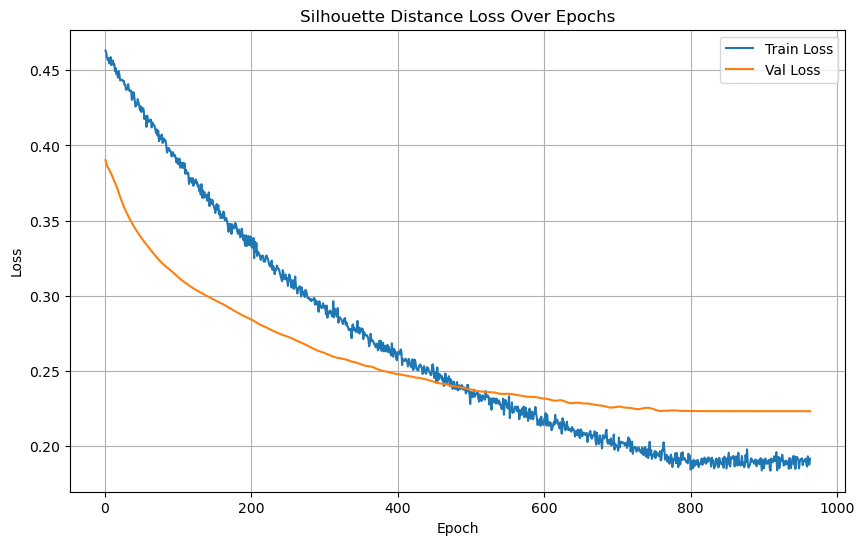

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/840], Loss: 0.0579


Test Batch [20/840], Loss: 0.1239
Test Batch [30/840], Loss: 0.1456
Test Batch [40/840], Loss: 0.1780
Test Batch [50/840], Loss: 0.1334
Test Batch [60/840], Loss: 0.1035
Test Batch [70/840], Loss: 0.1104


Test Batch [80/840], Loss: 0.5000


Test Batch [90/840], Loss: 0.1699
Test Batch [100/840], Loss: 0.2446
Test Batch [110/840], Loss: 0.5000
Test Batch [120/840], Loss: 0.1128
Test Batch [130/840], Loss: 0.1289
Test Batch [140/840], Loss: 0.1524
Test Batch [150/840], Loss: 0.1222


Test Batch [160/840], Loss: 0.2123


Test Batch [170/840], Loss: 0.0735
Test Batch [180/840], Loss: 0.0936
Test Batch [190/840], Loss: 0.1262
Test Batch [200/840], Loss: 0.0781
Test Batch [210/840], Loss: 0.0950


Test Batch [220/840], Loss: 0.0658
Test Batch [230/840], Loss: 0.0579
Test Batch [240/840], Loss: 0.0662
Test Batch [250/840], Loss: 0.1236


Test Batch [260/840], Loss: 0.2505
Test Batch [270/840], Loss: 0.2043
Test Batch [280/840], Loss: 0.3234
Test Batch [290/840], Loss: 0.1107


Test Batch [300/840], Loss: 0.2127
Test Batch [310/840], Loss: 0.1594
Test Batch [320/840], Loss: 0.1497
Test Batch [330/840], Loss: 0.1832
Test Batch [340/840], Loss: 0.1798
Test Batch [350/840], Loss: 0.5000


Test Batch [360/840], Loss: 0.5000
Test Batch [370/840], Loss: 0.5000
Test Batch [380/840], Loss: 0.5000
Test Batch [390/840], Loss: 0.5000
Test Batch [400/840], Loss: 0.5000
Test Batch [410/840], Loss: 0.5000
Test Batch [420/840], Loss: 0.5000
Test Batch [430/840], Loss: 0.0682
Test Batch [440/840], Loss: 0.0836
Test Batch [450/840], Loss: 0.1546
Test Batch [460/840], Loss: 0.0559


Test Batch [470/840], Loss: 0.1038
Test Batch [480/840], Loss: 0.0971
Test Batch [490/840], Loss: 0.5000
Test Batch [500/840], Loss: 0.0458
Test Batch [510/840], Loss: 0.0879
Test Batch [520/840], Loss: 0.1361


Test Batch [530/840], Loss: 0.5000
Test Batch [540/840], Loss: 0.1330
Test Batch [550/840], Loss: 0.1563
Test Batch [560/840], Loss: 0.1242
Test Batch [570/840], Loss: 0.1170


Test Batch [580/840], Loss: 0.1782
Test Batch [590/840], Loss: 0.0809
Test Batch [600/840], Loss: 0.1899
Test Batch [610/840], Loss: 0.1620
Test Batch [620/840], Loss: 0.0625
Test Batch [630/840], Loss: 0.1554


Test Batch [640/840], Loss: 0.0676
Test Batch [650/840], Loss: 0.1683
Test Batch [660/840], Loss: 0.3426
Test Batch [670/840], Loss: 0.0809
Test Batch [680/840], Loss: 0.0802


Test Batch [690/840], Loss: 0.2810
Test Batch [700/840], Loss: 0.2856
Test Batch [710/840], Loss: 0.1208
Test Batch [720/840], Loss: 0.1096
Test Batch [730/840], Loss: 0.1120


Test Batch [740/840], Loss: 0.2146
Test Batch [750/840], Loss: 0.1367
Test Batch [760/840], Loss: 0.5000
Test Batch [770/840], Loss: 0.1639
Test Batch [780/840], Loss: 0.5000
Test Batch [790/840], Loss: 0.2510


Test Batch [800/840], Loss: 0.1373
Test Batch [810/840], Loss: 0.5000
Test Batch [820/840], Loss: 0.1344
Test Batch [830/840], Loss: 0.5000
Test Batch [840/840], Loss: 0.5000

Test Loss: 0.2039


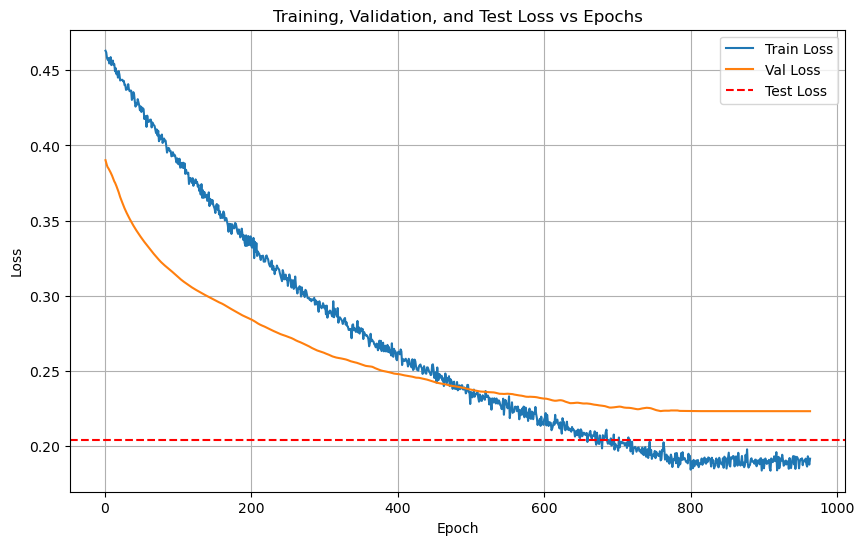

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/840 for test dataset.
  Processed batch 20/840 for test dataset.
  Processed batch 30/840 for test dataset.


  Processed batch 40/840 for test dataset.
  Processed batch 50/840 for test dataset.
  Processed batch 60/840 for test dataset.


  Processed batch 70/840 for test dataset.
  Processed batch 80/840 for test dataset.
  Processed batch 90/840 for test dataset.


  Processed batch 100/840 for test dataset.
  Processed batch 110/840 for test dataset.
  Processed batch 120/840 for test dataset.


  Processed batch 130/840 for test dataset.
  Processed batch 140/840 for test dataset.
  Processed batch 150/840 for test dataset.


  Processed batch 160/840 for test dataset.
  Processed batch 170/840 for test dataset.
  Processed batch 180/840 for test dataset.


  Processed batch 190/840 for test dataset.
  Processed batch 200/840 for test dataset.
  Processed batch 210/840 for test dataset.


  Processed batch 220/840 for test dataset.
  Processed batch 230/840 for test dataset.
  Processed batch 240/840 for test dataset.


  Processed batch 250/840 for test dataset.
  Processed batch 260/840 for test dataset.
  Processed batch 270/840 for test dataset.


  Processed batch 280/840 for test dataset.
  Processed batch 290/840 for test dataset.
  Processed batch 300/840 for test dataset.


  Processed batch 310/840 for test dataset.
  Processed batch 320/840 for test dataset.
  Processed batch 330/840 for test dataset.


  Processed batch 340/840 for test dataset.
  Processed batch 350/840 for test dataset.
  Processed batch 360/840 for test dataset.


  Processed batch 370/840 for test dataset.
  Processed batch 380/840 for test dataset.
  Processed batch 390/840 for test dataset.


  Processed batch 400/840 for test dataset.
  Processed batch 410/840 for test dataset.
  Processed batch 420/840 for test dataset.


  Processed batch 430/840 for test dataset.
  Processed batch 440/840 for test dataset.
  Processed batch 450/840 for test dataset.
  Processed batch 460/840 for test dataset.


  Processed batch 470/840 for test dataset.
  Processed batch 480/840 for test dataset.
  Processed batch 490/840 for test dataset.
  Processed batch 500/840 for test dataset.


  Processed batch 510/840 for test dataset.
  Processed batch 520/840 for test dataset.
  Processed batch 530/840 for test dataset.
  Processed batch 540/840 for test dataset.


  Processed batch 550/840 for test dataset.
  Processed batch 560/840 for test dataset.
  Processed batch 570/840 for test dataset.
  Processed batch 580/840 for test dataset.


  Processed batch 590/840 for test dataset.
  Processed batch 600/840 for test dataset.
  Processed batch 610/840 for test dataset.
  Processed batch 620/840 for test dataset.


  Processed batch 630/840 for test dataset.
  Processed batch 640/840 for test dataset.
  Processed batch 650/840 for test dataset.


  Processed batch 660/840 for test dataset.
  Processed batch 670/840 for test dataset.
  Processed batch 680/840 for test dataset.


  Processed batch 690/840 for test dataset.
  Processed batch 700/840 for test dataset.
  Processed batch 710/840 for test dataset.


  Processed batch 720/840 for test dataset.
  Processed batch 730/840 for test dataset.
  Processed batch 740/840 for test dataset.


  Processed batch 750/840 for test dataset.
  Processed batch 760/840 for test dataset.
  Processed batch 770/840 for test dataset.
  Processed batch 780/840 for test dataset.


  Processed batch 790/840 for test dataset.
  Processed batch 800/840 for test dataset.
  Processed batch 810/840 for test dataset.
  Processed batch 820/840 for test dataset.


  Processed batch 830/840 for test dataset.
  Processed batch 840/840 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 92.50%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         5
           9       0.83      1.00      0.91         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (320, 128)
Train labels shape: (320,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (53729, 128)
Test labels shape: (53729,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 3.0055  |  Val Loss: 3.0309
Validation loss improved from inf to 3.0309.
[Epoch 2/1000] Train Loss: 2.9417  |  Val Loss: 2.9606
Validation loss improved from 3.0309 to 2.9606.
[Epoch 3/1000] Train Loss: 2.8757  |  Val Loss: 2.8958
Validation loss improved from 2.9606 to 2.8958.
[Epoch 4/1000] Train Loss: 2.8137  |  Val Loss: 2.8378
Validation loss improved from 2.8958 to 2.8378.
[Epoch 5/1000] Train Loss: 2.7601  |  Val Loss: 2.7824
Validation loss improved from 2.8378 to 2.7824.
[Epoch 6/1000] Train Loss: 2.7085  |  Val Loss: 2.7307
Validation loss improved from 2.7824 to 2.7307.
[Epoch 7/1000] Train Loss: 2.6592  |  Val Loss: 2.6840
Validation loss improved from 2.7307 to 2.6840.
[Epoch 8/1000] Train Loss: 2.6131  |  Val Loss: 2.6415
Validation loss improved from 2.6840 to 2.6415.
[Epoch 9/1000] Train Loss: 2.5715  |  Val Loss: 2.6016
Validation loss improved from 2.6415 to 2.6016.
[Epoch 10/1000] Train Loss: 2.5303  |  Val Loss: 2.5639
Validation loss impr

[Epoch 16/1000] Train Loss: 2.3292  |  Val Loss: 2.3721
Validation loss improved from 2.4003 to 2.3721.
[Epoch 17/1000] Train Loss: 2.3010  |  Val Loss: 2.3442
Validation loss improved from 2.3721 to 2.3442.
[Epoch 18/1000] Train Loss: 2.2739  |  Val Loss: 2.3168
Validation loss improved from 2.3442 to 2.3168.
[Epoch 19/1000] Train Loss: 2.2475  |  Val Loss: 2.2903
Validation loss improved from 2.3168 to 2.2903.


[Epoch 20/1000] Train Loss: 2.2200  |  Val Loss: 2.2652
Validation loss improved from 2.2903 to 2.2652.
[Epoch 21/1000] Train Loss: 2.1953  |  Val Loss: 2.2404
Validation loss improved from 2.2652 to 2.2404.
[Epoch 22/1000] Train Loss: 2.1696  |  Val Loss: 2.2164
Validation loss improved from 2.2404 to 2.2164.
[Epoch 23/1000] Train Loss: 2.1449  |  Val Loss: 2.1927
Validation loss improved from 2.2164 to 2.1927.
[Epoch 24/1000] Train Loss: 2.1208  |  Val Loss: 2.1694
Validation loss improved from 2.1927 to 2.1694.
[Epoch 25/1000] Train Loss: 2.0967  |  Val Loss: 2.1462
Validation loss improved from 2.1694 to 2.1462.
[Epoch 26/1000] Train Loss: 2.0726  |  Val Loss: 2.1228
Validation loss improved from 2.1462 to 2.1228.
[Epoch 27/1000] Train Loss: 2.0484  |  Val Loss: 2.0994
Validation loss improved from 2.1228 to 2.0994.
[Epoch 28/1000] Train Loss: 2.0254  |  Val Loss: 2.0753
Validation loss improved from 2.0994 to 2.0753.
[Epoch 29/1000] Train Loss: 1.9998  |  Val Loss: 2.0520
Validati

[Epoch 35/1000] Train Loss: 1.8566  |  Val Loss: 1.9130
Validation loss improved from 1.9361 to 1.9130.
[Epoch 36/1000] Train Loss: 1.8329  |  Val Loss: 1.8899
Validation loss improved from 1.9130 to 1.8899.
[Epoch 37/1000] Train Loss: 1.8085  |  Val Loss: 1.8673
Validation loss improved from 1.8899 to 1.8673.
[Epoch 38/1000] Train Loss: 1.7850  |  Val Loss: 1.8443
Validation loss improved from 1.8673 to 1.8443.


[Epoch 39/1000] Train Loss: 1.7613  |  Val Loss: 1.8218
Validation loss improved from 1.8443 to 1.8218.
[Epoch 40/1000] Train Loss: 1.7379  |  Val Loss: 1.7994
Validation loss improved from 1.8218 to 1.7994.
[Epoch 41/1000] Train Loss: 1.7148  |  Val Loss: 1.7771
Validation loss improved from 1.7994 to 1.7771.
[Epoch 42/1000] Train Loss: 1.6908  |  Val Loss: 1.7548
Validation loss improved from 1.7771 to 1.7548.
[Epoch 43/1000] Train Loss: 1.6678  |  Val Loss: 1.7325
Validation loss improved from 1.7548 to 1.7325.
[Epoch 44/1000] Train Loss: 1.6451  |  Val Loss: 1.7101
Validation loss improved from 1.7325 to 1.7101.
[Epoch 45/1000] Train Loss: 1.6219  |  Val Loss: 1.6882
Validation loss improved from 1.7101 to 1.6882.
[Epoch 46/1000] Train Loss: 1.5989  |  Val Loss: 1.6665
Validation loss improved from 1.6882 to 1.6665.
[Epoch 47/1000] Train Loss: 1.5763  |  Val Loss: 1.6449
Validation loss improved from 1.6665 to 1.6449.
[Epoch 48/1000] Train Loss: 1.5541  |  Val Loss: 1.6235
Validati

[Epoch 54/1000] Train Loss: 1.4211  |  Val Loss: 1.4989
Validation loss improved from 1.5196 to 1.4989.
[Epoch 55/1000] Train Loss: 1.3989  |  Val Loss: 1.4783
Validation loss improved from 1.4989 to 1.4783.
[Epoch 56/1000] Train Loss: 1.3775  |  Val Loss: 1.4577
Validation loss improved from 1.4783 to 1.4577.
[Epoch 57/1000] Train Loss: 1.3560  |  Val Loss: 1.4377
Validation loss improved from 1.4577 to 1.4377.
[Epoch 58/1000] Train Loss: 1.3346  |  Val Loss: 1.4172
Validation loss improved from 1.4377 to 1.4172.


[Epoch 59/1000] Train Loss: 1.3129  |  Val Loss: 1.3967
Validation loss improved from 1.4172 to 1.3967.
[Epoch 60/1000] Train Loss: 1.2916  |  Val Loss: 1.3762
Validation loss improved from 1.3967 to 1.3762.
[Epoch 61/1000] Train Loss: 1.2700  |  Val Loss: 1.3559
Validation loss improved from 1.3762 to 1.3559.
[Epoch 62/1000] Train Loss: 1.2492  |  Val Loss: 1.3354
Validation loss improved from 1.3559 to 1.3354.
[Epoch 63/1000] Train Loss: 1.2280  |  Val Loss: 1.3151
Validation loss improved from 1.3354 to 1.3151.
[Epoch 64/1000] Train Loss: 1.2068  |  Val Loss: 1.2952
Validation loss improved from 1.3151 to 1.2952.
[Epoch 65/1000] Train Loss: 1.1855  |  Val Loss: 1.2751
Validation loss improved from 1.2952 to 1.2751.
[Epoch 66/1000] Train Loss: 1.1646  |  Val Loss: 1.2554
Validation loss improved from 1.2751 to 1.2554.
[Epoch 67/1000] Train Loss: 1.1437  |  Val Loss: 1.2357
Validation loss improved from 1.2554 to 1.2357.
[Epoch 68/1000] Train Loss: 1.1230  |  Val Loss: 1.2166
Validati

[Epoch 73/1000] Train Loss: 1.0219  |  Val Loss: 1.1230
Validation loss improved from 1.1410 to 1.1230.
[Epoch 74/1000] Train Loss: 1.0019  |  Val Loss: 1.1051
Validation loss improved from 1.1230 to 1.1051.
[Epoch 75/1000] Train Loss: 0.9820  |  Val Loss: 1.0876
Validation loss improved from 1.1051 to 1.0876.
[Epoch 76/1000] Train Loss: 0.9623  |  Val Loss: 1.0701
Validation loss improved from 1.0876 to 1.0701.


[Epoch 77/1000] Train Loss: 0.9425  |  Val Loss: 1.0526
Validation loss improved from 1.0701 to 1.0526.
[Epoch 78/1000] Train Loss: 0.9233  |  Val Loss: 1.0353
Validation loss improved from 1.0526 to 1.0353.
[Epoch 79/1000] Train Loss: 0.9037  |  Val Loss: 1.0185
Validation loss improved from 1.0353 to 1.0185.
[Epoch 80/1000] Train Loss: 0.8843  |  Val Loss: 1.0019
Validation loss improved from 1.0185 to 1.0019.
[Epoch 81/1000] Train Loss: 0.8652  |  Val Loss: 0.9851
Validation loss improved from 1.0019 to 0.9851.
[Epoch 82/1000] Train Loss: 0.8456  |  Val Loss: 0.9685
Validation loss improved from 0.9851 to 0.9685.
[Epoch 83/1000] Train Loss: 0.8269  |  Val Loss: 0.9526
Validation loss improved from 0.9685 to 0.9526.
[Epoch 84/1000] Train Loss: 0.8086  |  Val Loss: 0.9368
Validation loss improved from 0.9526 to 0.9368.
[Epoch 85/1000] Train Loss: 0.7898  |  Val Loss: 0.9212
Validation loss improved from 0.9368 to 0.9212.
[Epoch 86/1000] Train Loss: 0.7716  |  Val Loss: 0.9059
Validati

[Epoch 90/1000] Train Loss: 0.7025  |  Val Loss: 0.8477
Validation loss improved from 0.8620 to 0.8477.
[Epoch 91/1000] Train Loss: 0.6861  |  Val Loss: 0.8333
Validation loss improved from 0.8477 to 0.8333.
[Epoch 92/1000] Train Loss: 0.6695  |  Val Loss: 0.8193
Validation loss improved from 0.8333 to 0.8193.
[Epoch 93/1000] Train Loss: 0.6543  |  Val Loss: 0.8059
Validation loss improved from 0.8193 to 0.8059.


[Epoch 94/1000] Train Loss: 0.6390  |  Val Loss: 0.7926
Validation loss improved from 0.8059 to 0.7926.
[Epoch 95/1000] Train Loss: 0.6244  |  Val Loss: 0.7796
Validation loss improved from 0.7926 to 0.7796.
[Epoch 96/1000] Train Loss: 0.6092  |  Val Loss: 0.7667
Validation loss improved from 0.7796 to 0.7667.
[Epoch 97/1000] Train Loss: 0.5951  |  Val Loss: 0.7539
Validation loss improved from 0.7667 to 0.7539.
[Epoch 98/1000] Train Loss: 0.5811  |  Val Loss: 0.7416
Validation loss improved from 0.7539 to 0.7416.
[Epoch 99/1000] Train Loss: 0.5679  |  Val Loss: 0.7295
Validation loss improved from 0.7416 to 0.7295.
[Epoch 100/1000] Train Loss: 0.5549  |  Val Loss: 0.7180
Validation loss improved from 0.7295 to 0.7180.
[Epoch 101/1000] Train Loss: 0.5418  |  Val Loss: 0.7070
Validation loss improved from 0.7180 to 0.7070.
[Epoch 102/1000] Train Loss: 0.5289  |  Val Loss: 0.6956
Validation loss improved from 0.7070 to 0.6956.
[Epoch 103/1000] Train Loss: 0.5169  |  Val Loss: 0.6850
Vali

[Epoch 109/1000] Train Loss: 0.4493  |  Val Loss: 0.6251
Validation loss improved from 0.6344 to 0.6251.
[Epoch 110/1000] Train Loss: 0.4396  |  Val Loss: 0.6156
Validation loss improved from 0.6251 to 0.6156.
[Epoch 111/1000] Train Loss: 0.4288  |  Val Loss: 0.6065
Validation loss improved from 0.6156 to 0.6065.
[Epoch 112/1000] Train Loss: 0.4193  |  Val Loss: 0.5976
Validation loss improved from 0.6065 to 0.5976.


[Epoch 113/1000] Train Loss: 0.4101  |  Val Loss: 0.5892
Validation loss improved from 0.5976 to 0.5892.
[Epoch 114/1000] Train Loss: 0.4007  |  Val Loss: 0.5809
Validation loss improved from 0.5892 to 0.5809.
[Epoch 115/1000] Train Loss: 0.3916  |  Val Loss: 0.5727
Validation loss improved from 0.5809 to 0.5727.
[Epoch 116/1000] Train Loss: 0.3829  |  Val Loss: 0.5648
Validation loss improved from 0.5727 to 0.5648.
[Epoch 117/1000] Train Loss: 0.3741  |  Val Loss: 0.5572
Validation loss improved from 0.5648 to 0.5572.
[Epoch 118/1000] Train Loss: 0.3657  |  Val Loss: 0.5498
Validation loss improved from 0.5572 to 0.5498.
[Epoch 119/1000] Train Loss: 0.3576  |  Val Loss: 0.5420
Validation loss improved from 0.5498 to 0.5420.
[Epoch 120/1000] Train Loss: 0.3497  |  Val Loss: 0.5351
Validation loss improved from 0.5420 to 0.5351.
[Epoch 121/1000] Train Loss: 0.3418  |  Val Loss: 0.5282
Validation loss improved from 0.5351 to 0.5282.
[Epoch 122/1000] Train Loss: 0.3345  |  Val Loss: 0.521

[Epoch 129/1000] Train Loss: 0.2871  |  Val Loss: 0.4773
Validation loss improved from 0.4835 to 0.4773.
[Epoch 130/1000] Train Loss: 0.2808  |  Val Loss: 0.4720
Validation loss improved from 0.4773 to 0.4720.
[Epoch 131/1000] Train Loss: 0.2751  |  Val Loss: 0.4666
Validation loss improved from 0.4720 to 0.4666.
[Epoch 132/1000] Train Loss: 0.2694  |  Val Loss: 0.4613
Validation loss improved from 0.4666 to 0.4613.


[Epoch 133/1000] Train Loss: 0.2638  |  Val Loss: 0.4564
Validation loss improved from 0.4613 to 0.4564.
[Epoch 134/1000] Train Loss: 0.2586  |  Val Loss: 0.4518
Validation loss improved from 0.4564 to 0.4518.
[Epoch 135/1000] Train Loss: 0.2535  |  Val Loss: 0.4478
Validation loss improved from 0.4518 to 0.4478.
[Epoch 136/1000] Train Loss: 0.2484  |  Val Loss: 0.4431
Validation loss improved from 0.4478 to 0.4431.
[Epoch 137/1000] Train Loss: 0.2434  |  Val Loss: 0.4386
Validation loss improved from 0.4431 to 0.4386.
[Epoch 138/1000] Train Loss: 0.2387  |  Val Loss: 0.4344
Validation loss improved from 0.4386 to 0.4344.
[Epoch 139/1000] Train Loss: 0.2339  |  Val Loss: 0.4303
Validation loss improved from 0.4344 to 0.4303.
[Epoch 140/1000] Train Loss: 0.2294  |  Val Loss: 0.4261
Validation loss improved from 0.4303 to 0.4261.
[Epoch 141/1000] Train Loss: 0.2250  |  Val Loss: 0.4221
Validation loss improved from 0.4261 to 0.4221.
[Epoch 142/1000] Train Loss: 0.2210  |  Val Loss: 0.418

[Epoch 148/1000] Train Loss: 0.1978  |  Val Loss: 0.3996
Validation loss improved from 0.4027 to 0.3996.
[Epoch 149/1000] Train Loss: 0.1947  |  Val Loss: 0.3963
Validation loss improved from 0.3996 to 0.3963.
[Epoch 150/1000] Train Loss: 0.1909  |  Val Loss: 0.3936
Validation loss improved from 0.3963 to 0.3936.
[Epoch 151/1000] Train Loss: 0.1876  |  Val Loss: 0.3908
Validation loss improved from 0.3936 to 0.3908.
[Epoch 152/1000] Train Loss: 0.1844  |  Val Loss: 0.3887
Validation loss improved from 0.3908 to 0.3887.
[Epoch 153/1000] Train Loss: 0.1813  |  Val Loss: 0.3861
Validation loss improved from 0.3887 to 0.3861.
[Epoch 154/1000] Train Loss: 0.1783  |  Val Loss: 0.3835
Validation loss improved from 0.3861 to 0.3835.
[Epoch 155/1000] Train Loss: 0.1755  |  Val Loss: 0.3817
Validation loss improved from 0.3835 to 0.3817.
[Epoch 156/1000] Train Loss: 0.1726  |  Val Loss: 0.3800
Validation loss improved from 0.3817 to 0.3800.
[Epoch 157/1000] Train Loss: 0.1700  |  Val Loss: 0.378

[Epoch 165/1000] Train Loss: 0.1505  |  Val Loss: 0.3639
Validation loss improved from 0.3648 to 0.3639.
[Epoch 166/1000] Train Loss: 0.1483  |  Val Loss: 0.3624
Validation loss improved from 0.3639 to 0.3624.
[Epoch 167/1000] Train Loss: 0.1464  |  Val Loss: 0.3616
Validation loss improved from 0.3624 to 0.3616.
[Epoch 168/1000] Train Loss: 0.1446  |  Val Loss: 0.3607
Validation loss improved from 0.3616 to 0.3607.
[Epoch 169/1000] Train Loss: 0.1423  |  Val Loss: 0.3595
Validation loss improved from 0.3607 to 0.3595.
[Epoch 170/1000] Train Loss: 0.1405  |  Val Loss: 0.3585
Validation loss improved from 0.3595 to 0.3585.
[Epoch 171/1000] Train Loss: 0.1385  |  Val Loss: 0.3568
Validation loss improved from 0.3585 to 0.3568.
[Epoch 172/1000] Train Loss: 0.1367  |  Val Loss: 0.3556
Validation loss improved from 0.3568 to 0.3556.
[Epoch 173/1000] Train Loss: 0.1349  |  Val Loss: 0.3551
Validation loss improved from 0.3556 to 0.3551.
[Epoch 174/1000] Train Loss: 0.1332  |  Val Loss: 0.354

[Epoch 184/1000] Train Loss: 0.1179  |  Val Loss: 0.3490
Validation loss improved from 0.3497 to 0.3490.
[Epoch 185/1000] Train Loss: 0.1166  |  Val Loss: 0.3493
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 186/1000] Train Loss: 0.1154  |  Val Loss: 0.3490
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 187/1000] Train Loss: 0.1144  |  Val Loss: 0.3474
Validation loss improved from 0.3490 to 0.3474.
[Epoch 188/1000] Train Loss: 0.1129  |  Val Loss: 0.3468
Validation loss improved from 0.3474 to 0.3468.
[Epoch 189/1000] Train Loss: 0.1116  |  Val Loss: 0.3470
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 190/1000] Train Loss: 0.1104  |  Val Loss: 0.3465
Validation loss improved from 0.3468 to 0.3465.
[Epoch 191/1000] Train Loss: 0.1092  |  Val Loss: 0.3468
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 192/1000] Train Loss: 0.1081  |  Val Loss: 0.3469
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 193/1000] Train Lo

[Epoch 201/1000] Train Loss: 0.0988  |  Val Loss: 0.3428
Validation loss improved from 0.3430 to 0.3428.
[Epoch 202/1000] Train Loss: 0.0978  |  Val Loss: 0.3427
Validation loss improved from 0.3428 to 0.3427.
[Epoch 203/1000] Train Loss: 0.0969  |  Val Loss: 0.3433
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 204/1000] Train Loss: 0.0962  |  Val Loss: 0.3440
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 205/1000] Train Loss: 0.0951  |  Val Loss: 0.3434
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 206/1000] Train Loss: 0.0946  |  Val Loss: 0.3413
Validation loss improved from 0.3427 to 0.3413.
[Epoch 207/1000] Train Loss: 0.0934  |  Val Loss: 0.3408
Validation loss improved from 0.3413 to 0.3408.
[Epoch 208/1000] Train Loss: 0.0925  |  Val Loss: 0.3421
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 209/1000] Train Loss: 0.0918  |  Val Loss: 0.3429
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 210/1000] Train Lo

[Epoch 221/1000] Train Loss: 0.0828  |  Val Loss: 0.3432
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 222/1000] Train Loss: 0.0824  |  Val Loss: 0.3416
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 223/1000] Train Loss: 0.0815  |  Val Loss: 0.3424
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 224/1000] Train Loss: 0.0808  |  Val Loss: 0.3427
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 225/1000] Train Loss: 0.0802  |  Val Loss: 0.3431
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 226/1000] Train Loss: 0.0798  |  Val Loss: 0.3442
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 227/1000] Train Loss: 0.0789  |  Val Loss: 0.3437
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 228/1000] Train Loss: 0.0784  |  Val Loss: 0.3439
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 229/1000] Train Loss: 0.0777  |  Val Loss: 0.3432
!! Validation loss did NOT improve !! Patience: 15

[Epoch 239/1000] Train Loss: 0.0721  |  Val Loss: 0.3467
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 240/1000] Train Loss: 0.0715  |  Val Loss: 0.3473
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 241/1000] Train Loss: 0.0711  |  Val Loss: 0.3479
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 242/1000] Train Loss: 0.0708  |  Val Loss: 0.3458
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 243/1000] Train Loss: 0.0701  |  Val Loss: 0.3463
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 244/1000] Train Loss: 0.0696  |  Val Loss: 0.3473
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 245/1000] Train Loss: 0.0690  |  Val Loss: 0.3481
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 246/1000] Train Loss: 0.0687  |  Val Loss: 0.3495
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 247/1000] Train Loss: 0.0681  |  Val Loss: 0.3484
!! Validation loss did NOT improve !! Patience:

[Epoch 257/1000] Train Loss: 0.0636  |  Val Loss: 0.3528
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 258/1000] Train Loss: 0.0633  |  Val Loss: 0.3540
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 259/1000] Train Loss: 0.0628  |  Val Loss: 0.3555
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 260/1000] Train Loss: 0.0624  |  Val Loss: 0.3550
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 261/1000] Train Loss: 0.0620  |  Val Loss: 0.3549
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 262/1000] Train Loss: 0.0617  |  Val Loss: 0.3556
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 263/1000] Train Loss: 0.0611  |  Val Loss: 0.3557
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 264/1000] Train Loss: 0.0608  |  Val Loss: 0.3559
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 265/1000] Train Loss: 0.0604  |  Val Loss: 0.3568
!! Validation loss did NOT improve !! Patience:

[Epoch 276/1000] Train Loss: 0.0565  |  Val Loss: 0.3632
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 277/1000] Train Loss: 0.0561  |  Val Loss: 0.3632
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 278/1000] Train Loss: 0.0558  |  Val Loss: 0.3620
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 279/1000] Train Loss: 0.0554  |  Val Loss: 0.3620
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 280/1000] Train Loss: 0.0551  |  Val Loss: 0.3634
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 281/1000] Train Loss: 0.0548  |  Val Loss: 0.3653
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 282/1000] Train Loss: 0.0545  |  Val Loss: 0.3652
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 283/1000] Train Loss: 0.0543  |  Val Loss: 0.3672
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 284/1000] Train Loss: 0.0540  |  Val Loss: 0.3687
!! Validation loss did NOT improve !! Patience:

[Epoch 295/1000] Train Loss: 0.0507  |  Val Loss: 0.3705
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 296/1000] Train Loss: 0.0502  |  Val Loss: 0.3733
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 297/1000] Train Loss: 0.0499  |  Val Loss: 0.3753
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 298/1000] Train Loss: 0.0497  |  Val Loss: 0.3772
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 299/1000] Train Loss: 0.0494  |  Val Loss: 0.3772
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 300/1000] Train Loss: 0.0491  |  Val Loss: 0.3776
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 301/1000] Train Loss: 0.0488  |  Val Loss: 0.3773
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 302/1000] Train Loss: 0.0485  |  Val Loss: 0.3772
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 303/1000] Train Loss: 0.0483  |  Val Loss: 0.3785
!! Validation loss did NOT improve !! Patience:

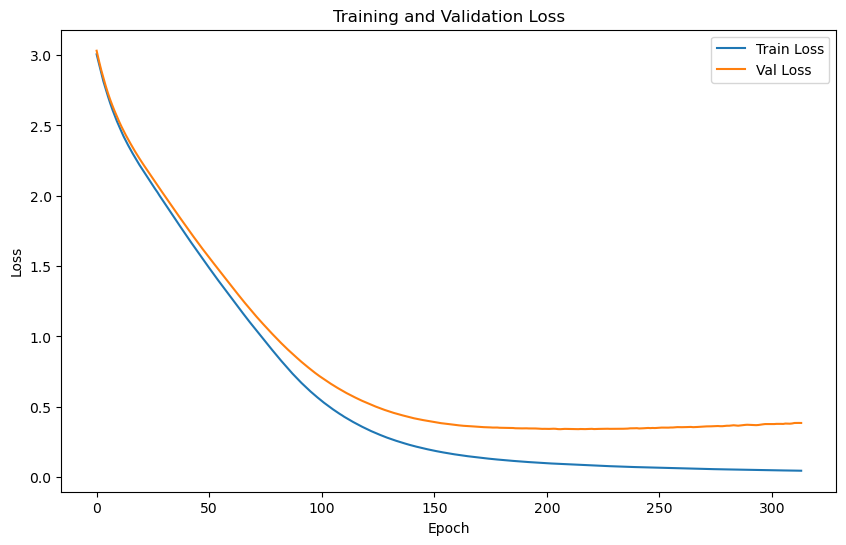

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.5520 | Test Accuracy: 85.99%


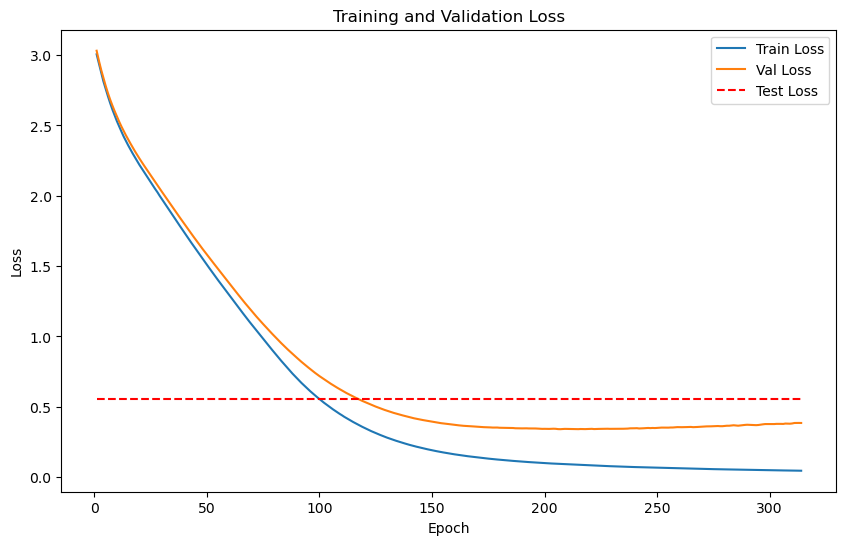

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


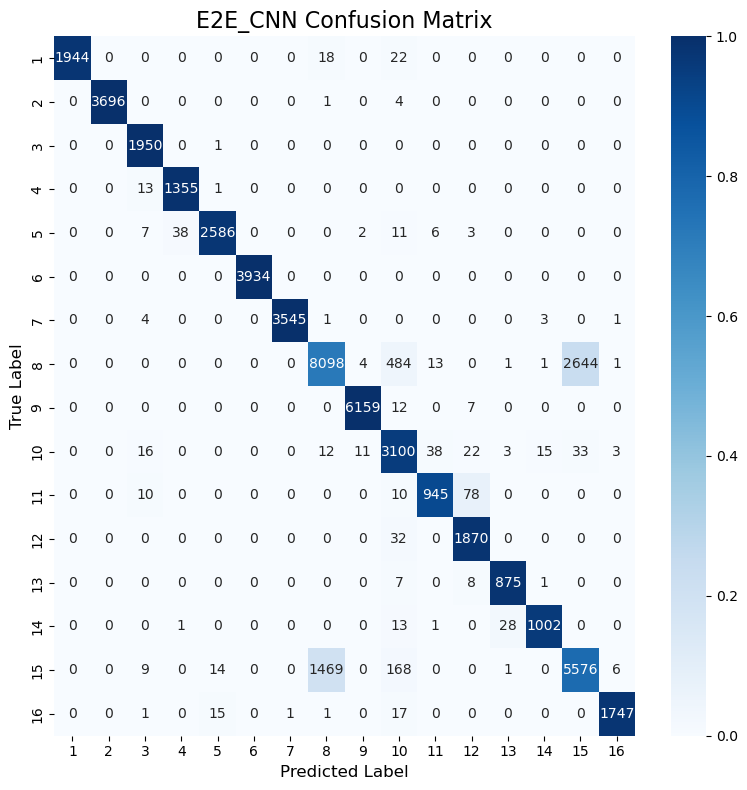

Classification Accuracy: 90.05%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


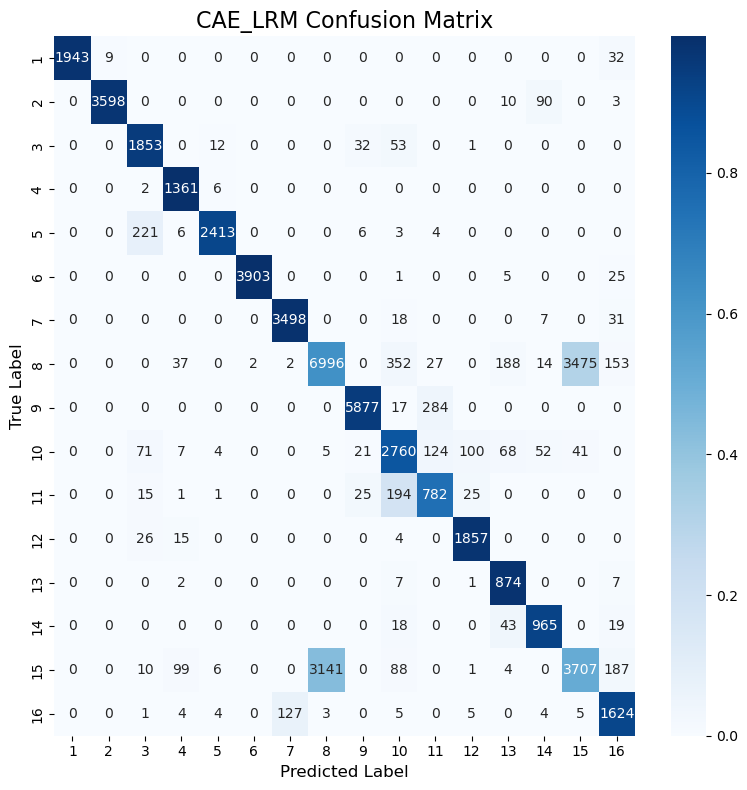

Classification Accuracy: 81.91%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


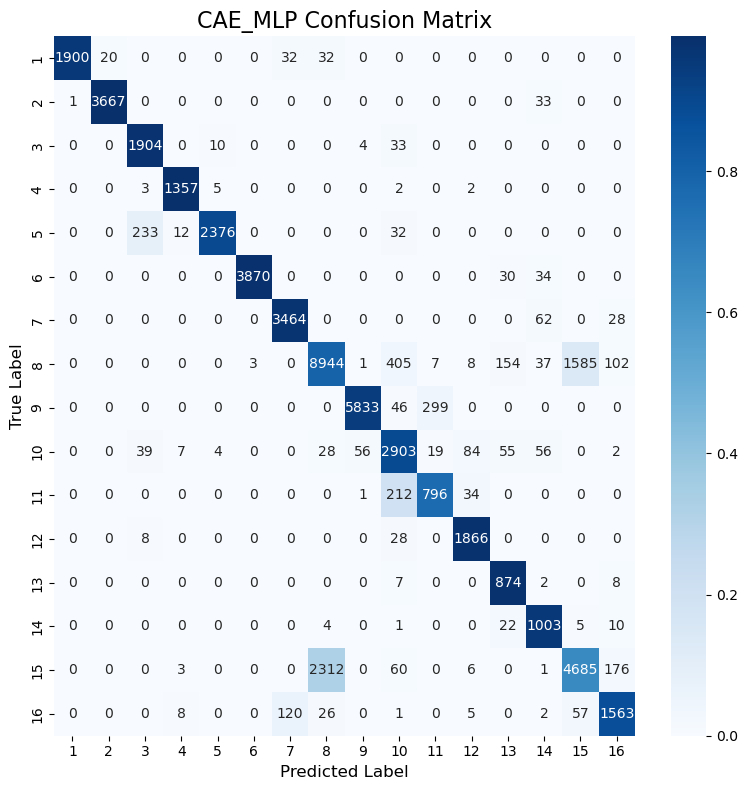

Classification Accuracy: 87.49%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


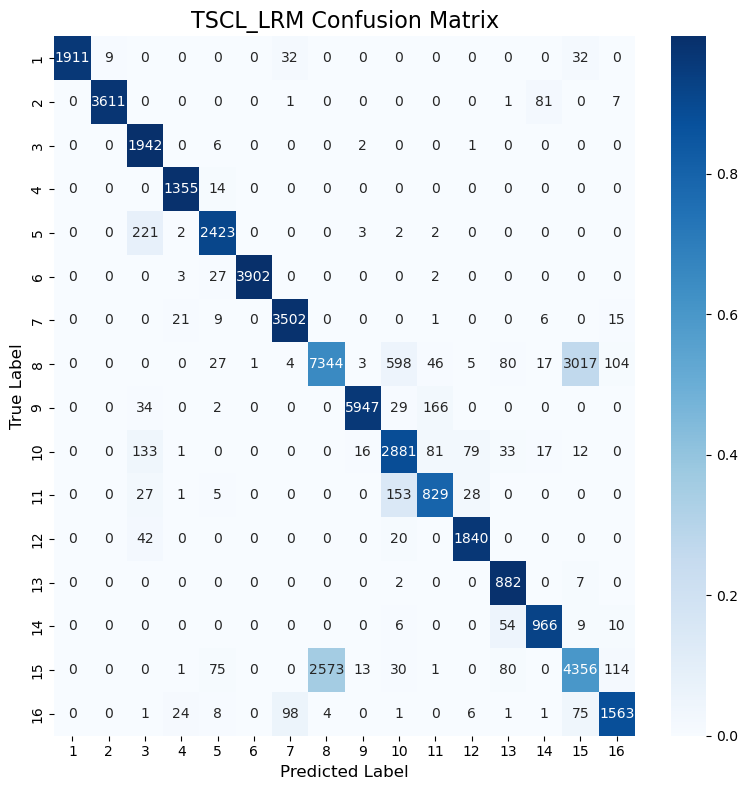

Classification Accuracy: 84.23%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


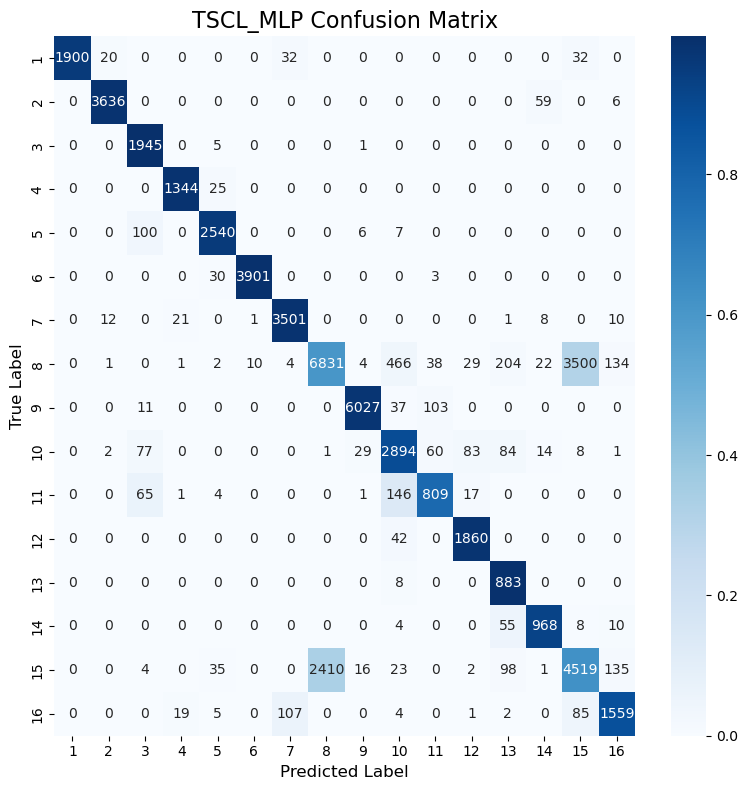

Classification Accuracy: 83.97%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


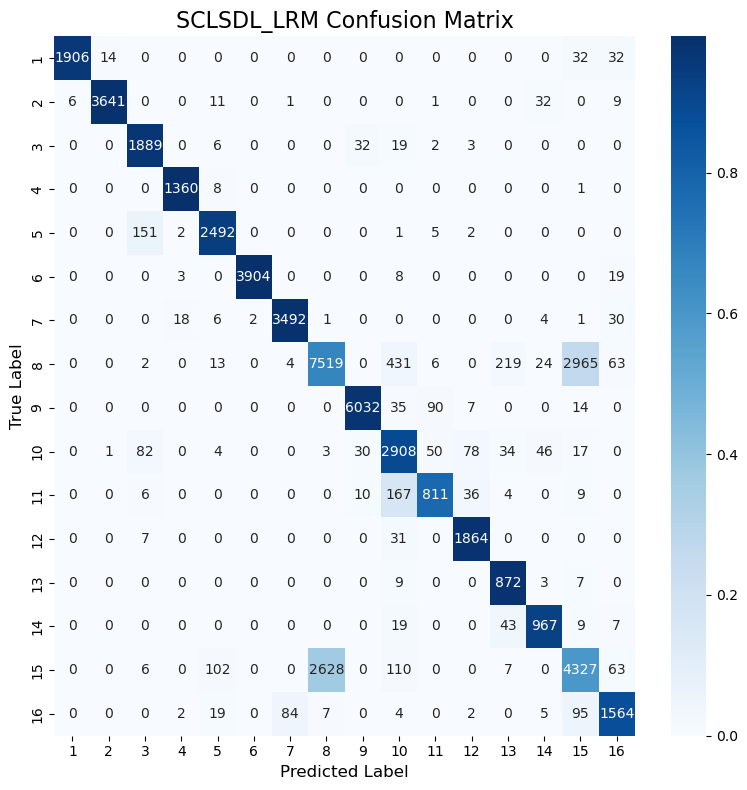

Classification Accuracy: 84.77%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


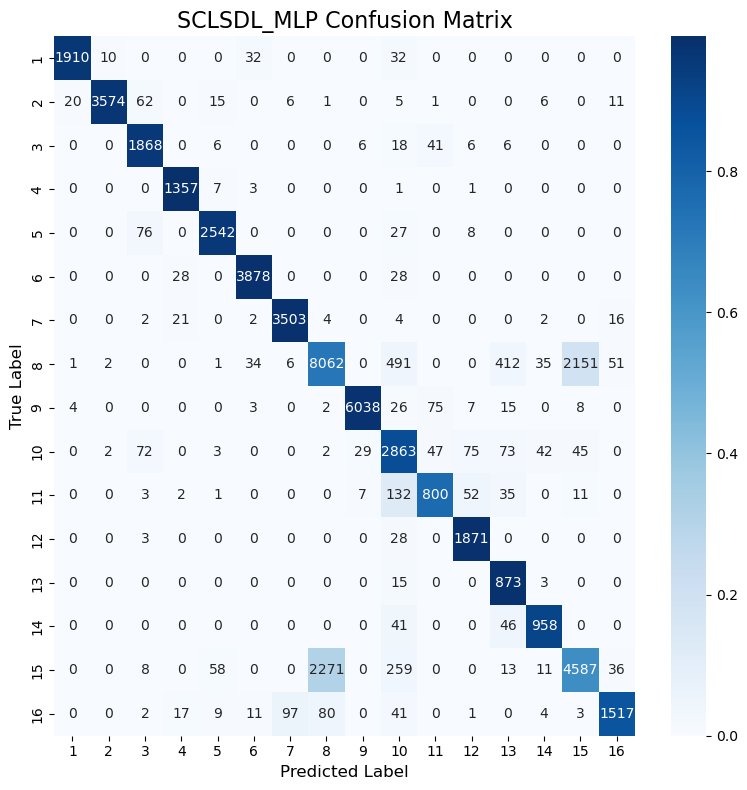

Classification Accuracy: 85.99%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          90.05
1    LRM (CAE)          81.91
2    MLP (CAE)          87.49
3     TSCL LRM          84.23
4     TSCL MLP          83.97
5  SCL_SDL LRM          84.77
6  SCL_SDL MLP          85.99

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          90.05
2    MLP (CAE)          87.49
6  SCL_SDL MLP          85.99
5  SCL_SDL LRM          84.77
3     TSCL LRM          84.23
4     TSCL MLP          83.97
1    LRM (CAE)          81.91
